# 중남미(페루, 멕시코, 콜롬비아) 국가 비만율 예측 분석

In [21]:
# 한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [4]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# 불필요한 경고 메시지 삭제
import warnings
warnings.filterwarnings('ignore')

In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mticker
%matplotlib inline

cmaps = plt.colormaps()
# for cm in cmaps:
    # print(cm)

import seaborn as sns
sns.set(style='darkgrid')

from hyperopt import hp, fmin, Trials, tpe
from hyperopt import hp

In [26]:
# 한글 font 가져오기
import matplotlib.font_manager as fm

# 글꼴 경로 설정
font_path = '/content/drive/MyDrive/MLP-33-ML-DL/semi_project/Project/김은아/font'

font_files = fm.findSystemFonts(fontpaths=font_path)
for font_file in font_files:
    fm.fontManager.addfont(font_file)

# 글꼴 경로 설정
font_path = '/content/drive/MyDrive/MLP-33-ML-DL/semi_project/Project/김은아/font/NotoSansKR-VariableFont_wght.ttf'

# 폰트 이름 가져오기
font_name = fm.FontProperties(fname=font_path).get_name()

# 폰트 설정
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 가져오기

In [6]:
# 데이터 경로 설정
BASE_DATA_PATH = "/content/drive/MyDrive/MLP-33-ML-DL/semi_project/Project/Data"

ORIGIN_DATA_PATH = BASE_DATA_PATH + "/ObesityDataSet.csv"
LABELED_DATA_PATH = BASE_DATA_PATH + "/ObesityDataSet_Labeled.csv"

In [8]:
# CSV 파일 데이터 프레임으로 변환
obe_df = pd.read_csv(LABELED_DATA_PATH)

obe_df.head()

Gender   Age  Height  Weight  family_history_with_overweight  FAVC  FCVC  \
0       0  21.0    1.62    64.0                               1     0   2.0   
1       0  21.0    1.52    56.0                               1     0   3.0   
2       1  23.0    1.80    77.0                               1     0   2.0   
3       1  27.0    1.80    87.0                               0     0   3.0   
4       1  22.0    1.78    89.8                               0     0   2.0   

   NCP  CAEC  SMOKE  CH2O  SCC  FAF  TUE  CALC  MTRANS  NObeyesdad  
0  3.0     1      0   2.0    0  0.0  1.0     0       4           1  
1  3.0     1      1   3.0    1  3.0  0.0     1       4           1  
2  3.0     1      0   2.0    0  2.0  1.0     2       4           1  
3  3.0     1      0   2.0    0  2.0  0.0     2       5           5  
4  1.0     1      0   2.0    0  0.0  0.0     1       4           6

In [9]:
## MTRANS / NObeyesdad 레이블링 값 수정
# 주석처리처럼 각각 바꿀 수도 있음
# obe_df.loc[(obe_df.MTRANS == 1), 'MTRANS'] = 1

change_MTRANS_value_dict = {
    1: 1,
    2: 3,
    3: 1,
    4: 2,
    5: 3
}

change_NObeyesdad_value_dict = {
    0 : 0,
    1 : 1,
    2 : 4,
    3 : 5,
    4 : 6,
    5 : 2,
    6 : 3
}

obe_df = obe_df.replace({'MTRANS': change_MTRANS_value_dict})
obe_df = obe_df.replace({'NObeyesdad': change_NObeyesdad_value_dict})
obe_df.head()

Gender   Age  Height  Weight  family_history_with_overweight  FAVC  FCVC  \
0       0  21.0    1.62    64.0                               1     0   2.0   
1       0  21.0    1.52    56.0                               1     0   3.0   
2       1  23.0    1.80    77.0                               1     0   2.0   
3       1  27.0    1.80    87.0                               0     0   3.0   
4       1  22.0    1.78    89.8                               0     0   2.0   

   NCP  CAEC  SMOKE  CH2O  SCC  FAF  TUE  CALC  MTRANS  NObeyesdad  
0  3.0     1      0   2.0    0  0.0  1.0     0       2           1  
1  3.0     1      1   3.0    1  3.0  0.0     1       2           1  
2  3.0     1      0   2.0    0  2.0  1.0     2       2           1  
3  3.0     1      0   2.0    0  2.0  0.0     2       3           2  
4  1.0     1      0   2.0    0  0.0  0.0     1       2           3

- 팀원들과 논의 후 교통수단/비만도 레이블 값 재수정

In [10]:
obe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   int64  
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   int64  
 5   FAVC                            2111 non-null   int64  
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   int64  
 9   SMOKE                           2111 non-null   int64  
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   int64  
 12  FAF                             21

- 결측치 없는 것을 확인
- 추가 인코딩할 값이 없는 것 확인
- 나이나 빈도 수로 보았을 때 해당 피처에 적절하지 않은 float 값이 보이지만, 더 세분화해서 계산할 수 있기 때문에 수치를 그대로 사용

- 데이터 표본의 개수 : 2112개
- 피처 데이터 개수 : 16개
- 타겟 데이터 개수 : 1개
  - 타겟 데이터 레이블은 BMI 수치 구간별로 레이블링 되어 있음
  - $BMI = \frac{\text Height}{\text Weight^2}$

In [11]:
# 컬럼명 확인
obe_df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [12]:
# 컬럼명 리스트화
feature_names = ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS']

# 피처 데이터 컬럼별 레이블링 dict화
MTRANS_label = {
    1 : "Automobile & Motorbike(1)",
    2 : "Public_Transportation(2)",
    3 : "Walking & Bike(3)",
}

# CAEC, CALC 컬럼 관련
Frequency_label = {
    0 : "no(0)",
    1 : "Sometimes(1)",
    2 : "Frequently(2)",
    3 : "Always(3)"
}
# Gender 컬럼 관련
Gender_label = {
    0 : "Female(0)",
    1 : "Male(1)"
}

# family_history_with_overweight, FAVC, SMOKE, SCC 컬럼 관련
YN_label = {
    0 : "no(0)",
    1 : "yes(1)"
}

In [13]:
# 타겟 값 레이블링 된 이름 dict화로 저장 - 나중에 데이터 분석에 사용
target_name = ['NObeyesdad']

# NObeyesdad 컬럼 관련
target_label = {
    0 : "Insufflcient_Weight(0)",
    1 : "Normal_Weight(1)",
    2 : "Overweight_Level_I(2)",
    3 : "Overweight_Level_II(3)",
    4 : "Obesity_Type_I(4)",
    5 : "Obesity_Type_II(5)",
    6 : "Obesity_Type_III(6)"
}

all_data_names = ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad']

In [14]:
# # BMI 수치 필요시 아래로 진행
# target2_name = ['BMI']

# # BMI 수치 계산해서 데이터프레임에 컬럼 추가
# obe_df['BMI'] = obe_df['Weight'] / (obe_df['Height'] ** 2)

# obe_df.head()

# 2. 피처 데이터 탐색
- 기술 통계 분석
- 아웃라이어(이상치) 확인
- 데이터간 상관관계 확인
- 성별 별 피처 확인

## 2-1. 전체 데이터에 대한 분포 확인

In [ ]:
# # 데이터 시각화 이미지 저장시 저장 경로 지정
# IMAGE_PATH = "/content/drive/MyDrive/MLP-33-ML-DL/semi_project/Project/IMAGE/"

In [101]:
## 파이 차트 생성 함수 정의

def pie_chart(df, col, label_dict, color):
  labels = label_dict.values() # 레이블 이름
  sizes = np.array(df[col].value_counts().sort_index()) # 레이블별 데이터 개수


  # explode = tuple(np.zeros(len(label_dict)))

  _, texts, autotexts = plt.pie(
    sizes,
    # explode=explode # 각 파이에서 툭 튀어나오는 비율
    labels=labels,
    autopct="%1.1f%%", # 퍼센테이지 표기 포맷
    counterclock=False, # 시계방향 순서로 지정
    shadow=False, # 그림자
    startangle=90, # 시작 각도 설정
    colors=color, # 컬러맵 설정
    wedgeprops={'width':1, 'edgecolor': 'w', 'linewidth':2}
  )

  # label 스타일링
  for t in texts:
    t.set_fontsize(10)
    t.set_color('gray')

  # ratio 스타일링
  for t in autotexts:
    t.set_fontsize(10)
    t.set_color('white')

  plt.title(col, fontsize=12) # plt 제목

  return

### NObeyesdad(비만도)

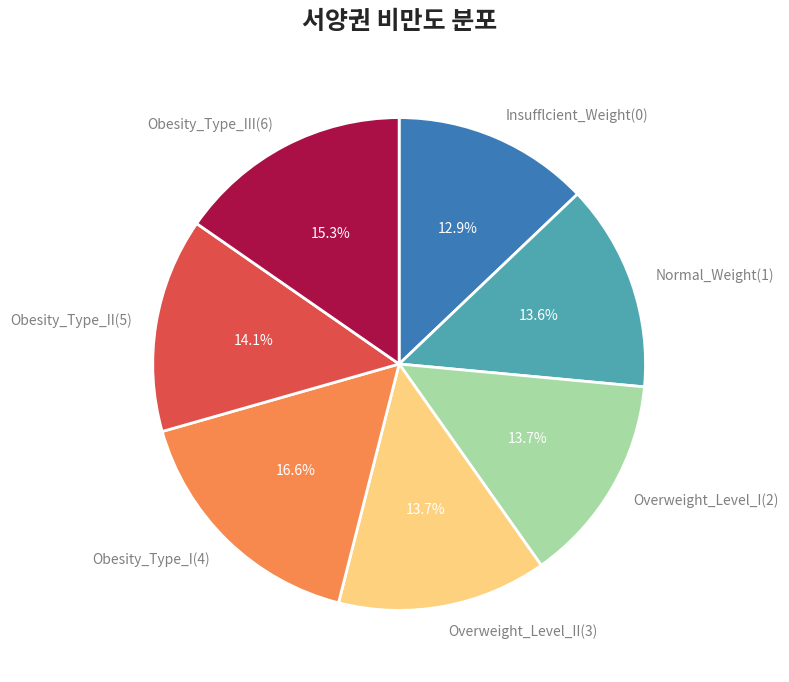

NObeyesdad
0    272
1    287
2    290
3    290
4    351
5    297
6    324
Name: count, dtype: int64


In [102]:
fig = plt.figure()
fig.set_size_inches((10, 8))

pie_chart(obe_df, 'NObeyesdad', target_label, ["#3b7bb7", "#4fa8af", "#a6dba4", "#fdd17e", "#f7894f", "#e04f4a", "#aa0f45"])

plt.title("서양권 비만도 분포", fontsize=18, pad=20, fontweight='bold')

# # 범례 표시
# plt.legend(loc='upper right',
#            bbox_to_anchor=(1.3, 1),
#            fontsize='small')

# # 그래프를 이미지로 저장
# plt.savefig(IMAGE_PATH + "3_1_kaggle_nobeyesdad.png", dpi=200, bbox_inches="tight", pad_inches=0.2, transparent = True, facecolor="#fafafaff") # facecolor="#fafafaff"

plt.show()

print(obe_df['NObeyesdad'].value_counts().sort_index())

- 타겟 데이터는 각 레이블별로 고르게 분포된 것을 확인할 수 있다.

### Gender

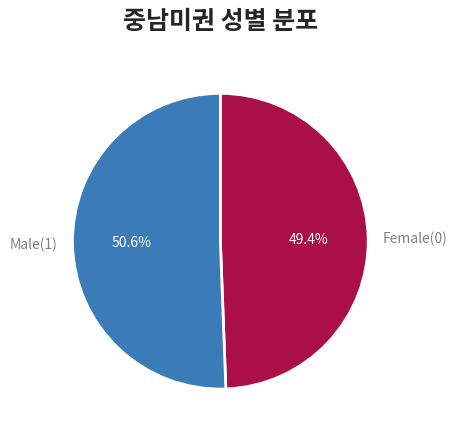

Gender
0    1043
1    1068
Name: count, dtype: int64


In [103]:
pie_chart(obe_df, 'Gender', Gender_label, ["#aa0f45",  "#3b7bb7"])

plt.title("중남미권 성별 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

print(obe_df['Gender'].value_counts().sort_index())

- 남-여 비율은 비슷한 분포를 보인다.

#### 성별 별 비만도 분포

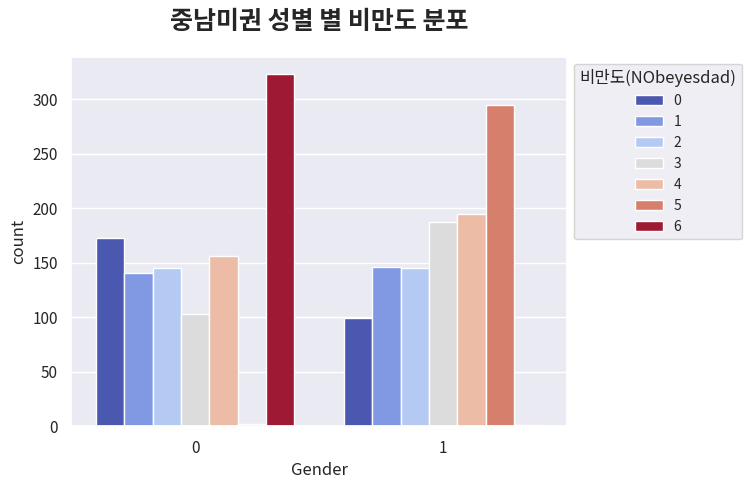

In [60]:
sns.countplot(x='Gender', data=obe_df, hue='NObeyesdad', palette='coolwarm')

plt.title("중남미권 성별 별 비만도 분포", fontsize=18, pad=20, fontweight='bold')

# 범례 표시
plt.legend(title='비만도(NObeyesdad)',
           loc='best',
           bbox_to_anchor=(1, 1),
           fontsize='small')


plt.show()

In [ ]:
obe_df.groupby(['Gender'])['NObeyesdad'].value_counts(sort=False)

Gender  NObeyesdad
0       0             173
        1             141
        2             145
        3             103
        4             156
        5               2
        6             323
1       0              99
        1             146
        2             145
        3             187
        4             195
        5             295
        6               1
Name: count, dtype: int64

#### 성별 데이터 분석
- 전반적으로 과체중 이상의 비만도는 남자보다 여자가 높게 나타난다.
- 과체중(Overweight)은 여자보다 남자가 살짝 더 많이 분포되어 있다.
- 비만(Obesity)은 여자보다 남자가 살짝 더 많이 분포한다.
- Obesity_Type_I은 여자보다 남자가 더 많이 분포한다.
- Obesity_Type_II은 대부분 남자가 분포한다.
- Obesity_Type_III은 대부분 여자가 분포한다.

### Age

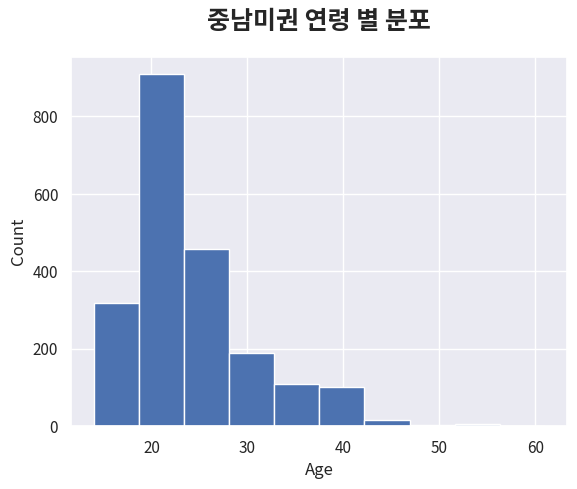

In [73]:
plt.hist(obe_df['Age'], bins=10)

plt.title("중남미권 연령 별 분포", fontsize=18, pad=20, fontweight='bold')

plt.xlabel("Age")
plt.ylabel("Count")

plt.show()

In [ ]:
obe_df['Age'].describe()

count    2111.000000
mean       24.312600
std         6.345968
min        14.000000
25%        19.947192
50%        22.777890
75%        26.000000
max        61.000000
Name: Age, dtype: float64

#### 연령대 별 분포

In [75]:
# bins 기준으로 연령에 대한 수치형 데이터 범주화 데이터 생성
bins = [10, 20, 30, 40, 50, 60, 70]
age_group_data = pd.cut(obe_df['Age'], bins=bins, labels=[10, 20, 30, 40, 50, 60], right = False)

# 기존 데이터 프레임에 추가
obe_df['Age_group'] = age_group_data

# 연령별 카테고리가 잘 나누어졌는지 확인
obe_df.loc[10:30, ['Age', 'Age_group']]

Age Age_group
10  26.0        20
11  21.0        20
12  22.0        20
13  41.0        40
14  23.0        20
15  22.0        20
16  27.0        20
17  29.0        20
18  30.0        30
19  23.0        20
20  22.0        20
21  52.0        50
22  22.0        20
23  22.0        20
24  21.0        20
25  20.0        20
26  21.0        20
27  23.0        20
28  19.0        10
29  23.0        20
30  29.0        20

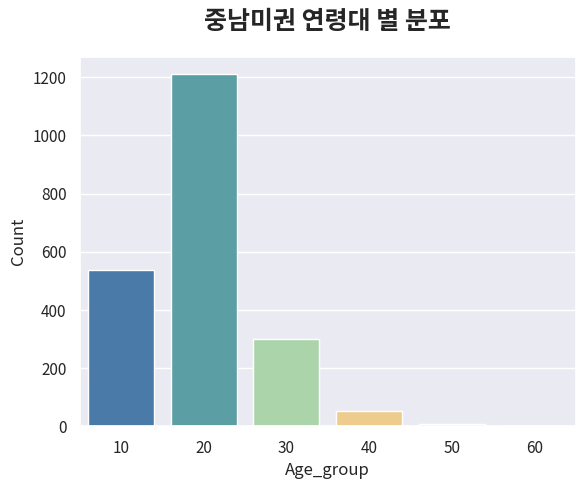

Age_group
10     537
20    1210
30     301
40      53
50       9
60       1
Name: count, dtype: int64

In [78]:
# 연령대 별 분포 시각화
sns.countplot(x='Age_group', data=obe_df, palette=["#3b7bb7", "#4fa8af", "#a6dba4", "#fdd17e", "#f7894f", "#e04f4a", "#aa0f45"])

plt.title("중남미권 연령대 별 분포", fontsize=18, pad=20, fontweight='bold')

plt.xlabel("Age_group")
plt.ylabel("Count")

plt.show()

# 연령대 별 표본수
obe_df['Age_group'].value_counts(sort=False)

- 최저 연령은 14세 최고 연령은 61세
- 연령대별 표본 비율은 20대가 가장 많고, 전반적으로 10 ~ 30대 사이의 연령대 분포가 많다. 상대적으로 40 ~ 60대 분포는 매우 적은 편이다.
- 한국과 비교할 때 연령대도 맞춰야할지 고민해볼 점

#### 연령대 별 비만도 분포

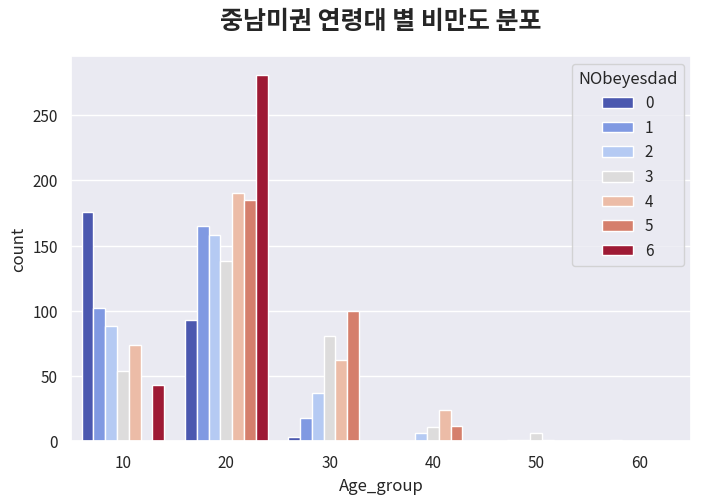

In [79]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Age_group', data=obe_df, hue='NObeyesdad', palette='coolwarm')

plt.title("중남미권 연령대 별 비만도 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

In [ ]:
obe_df.groupby(['Age_label'])['NObeyesdad'].value_counts(sort=False)

Age_label  NObeyesdad
10         0             176
           1             102
           2              88
           3              54
           4              74
           5               0
           6              43
20         0              93
           1             165
           2             158
           3             138
           4             190
           5             185
           6             281
30         0               3
           1              18
           2              37
           3              81
           4              62
           5             100
           6               0
40         0               0
           1               0
           2               6
           3              11
           4              24
           5              12
           6               0
50         0               0
           1               1
           2               1
           3               6
           4               1
           5         

#### 연령대 데이터 분석
- 전반적으로 과체중, 비만은 20대에 가장 많이 분포되어 있다.
- 비만도 Obesity_Type_I(4)는 20대에 가장 많이 나타나고, 10대, 30대, 40대가 다음으로 많이 분포되어 있다.
- 비만도 Obesity_Type_II(5)는 20대에 가장 많이 나타나고, 30대, 40대가 다음으로 많이 분포되어 있다. 10대는 아예 데이터가 없다.
- 비만도 Obesity_Type_III(6)은 10대 20대에만 나타나고, 20대에서 특히 많이 분포되어 있다.

#### 연령대 인사이트
- 20대, 10대에 두드러지게 비만도 6이 나오는지, 다른 연령대와 비교되는 피처의 특성이 있을지 확인해보면 좋을 것 같다.
- 연령별 비만도에 영향을 주는 피처 파악해보는 것도 좋을 것 같다.


### Height

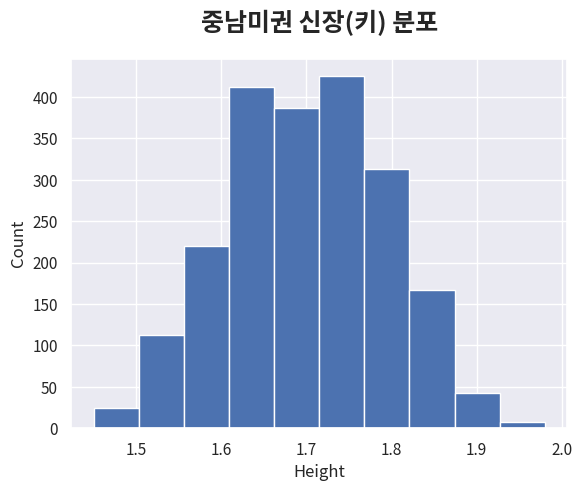

In [80]:
plt.hist(obe_df['Height'], bins=10)

plt.title("중남미권 신장(키) 분포", fontsize=18, pad=20, fontweight='bold')

plt.xlabel("Height")
plt.ylabel("Count")

plt.show()

In [ ]:
obe_df['Height'].describe()

count    2111.000000
mean        1.701677
std         0.093305
min         1.450000
25%         1.630000
50%         1.700499
75%         1.768464
max         1.980000
Name: Height, dtype: float64

- 키의 최소값은 1.45m, 최대값은 1.98m로 1.63 ~ 1.77m 사이의 값이 가장 많이 분포되어 있다.

### Weight

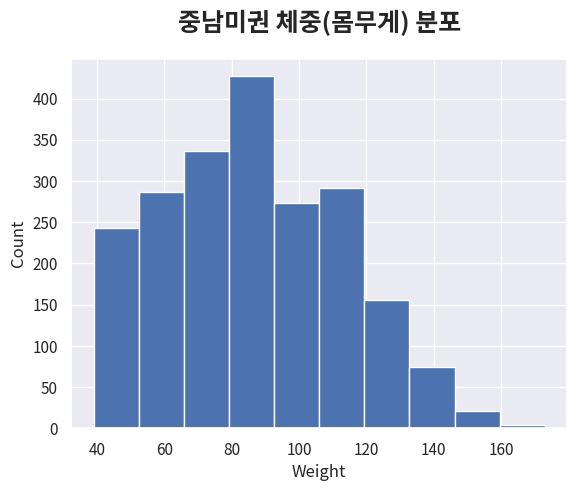

In [81]:
plt.hist(obe_df['Weight'], bins=10)

plt.title("중남미권 체중(몸무게) 분포", fontsize=18, pad=20, fontweight='bold')

plt.xlabel("Weight")
plt.ylabel("Count")

plt.show()

In [ ]:
obe_df['Weight'].describe()

count    2111.000000
mean       86.586058
std        26.191172
min        39.000000
25%        65.473343
50%        83.000000
75%       107.430682
max       173.000000
Name: Weight, dtype: float64

- 몸무게는 39kg ~ 173kg로 분포되어 있고 130kg 이상인 데이터는 상대적으로 적다.

#### 체중대 별 비만도 분포

In [82]:
# bins 기준으로 연령에 대한 수치형 데이터 범주화 데이터 생성
bins = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180]
weight_group_data = pd.cut(obe_df['Weight'], bins=bins, labels=[30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170], right = False)

# 기존 데이터 프레임에 추가
obe_df['Weight_group'] = weight_group_data
obe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Gender                          2111 non-null   int64   
 1   Age                             2111 non-null   float64 
 2   Height                          2111 non-null   float64 
 3   Weight                          2111 non-null   float64 
 4   family_history_with_overweight  2111 non-null   int64   
 5   FAVC                            2111 non-null   int64   
 6   FCVC                            2111 non-null   float64 
 7   NCP                             2111 non-null   float64 
 8   CAEC                            2111 non-null   int64   
 9   SMOKE                           2111 non-null   int64   
 10  CH2O                            2111 non-null   float64 
 11  SCC                             2111 non-null   int64   
 12  FAF                 

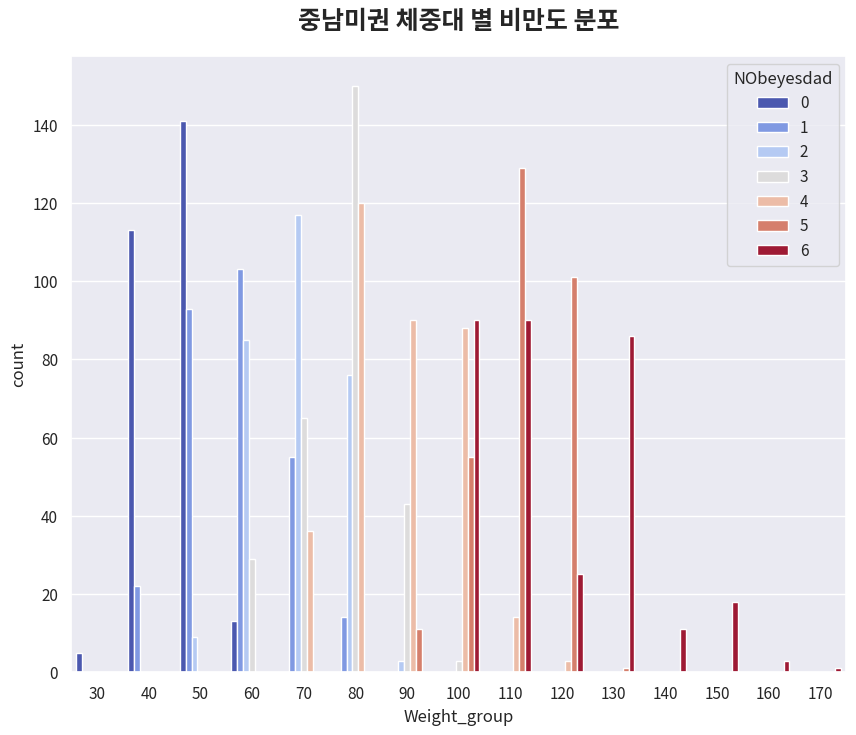

In [85]:
plt.figure(figsize=(10,8))
sns.countplot(x='Weight_group', data=obe_df, hue='NObeyesdad', palette='coolwarm')

plt.title("중남미권 체중대 별 비만도 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

#### 몸무게 데이터 분석 및 인사이트 Ⅰ
- 몸무게는 100KG 이상부터 비만도 Obesity_Type_III(6)이 두드러지게 분포한다.
- 몸무게는 성별별로 평균값이 차이가 나타나기 때문에, 성별 별 몸무게와 비만도 분포를 확인해보겠다.

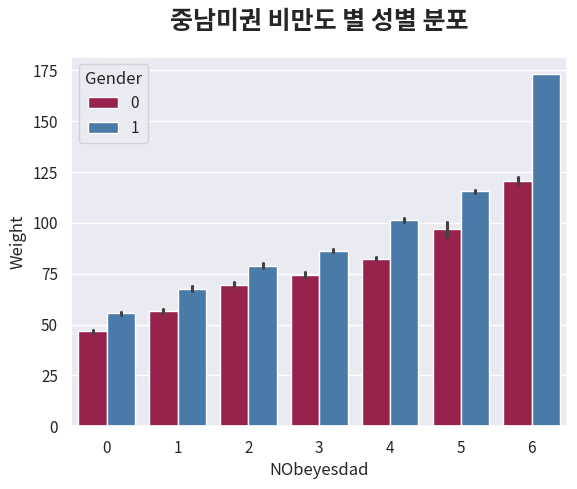

In [86]:
# plt.figure(figsize=(10,8))
sns.barplot(x='NObeyesdad', y='Weight', hue='Gender', data=obe_df, palette=["#aa0f45",  "#3b7bb7"])

plt.title("중남미권 비만도 별 성별 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

#### 몸무게 데이터 분석 및 인사이트 Ⅱ
- 성별 별 몸무게와 비만도의 분포를 확인해보았다.
- 모든 비만도에서 남자(1)가 여자(0)보다 몸무게가 높은 데, 특히 비만도 Obesity_Type_III(6)에서 몸무게 차이가 두드러진다.
  - 하지만, 남자 비만도 6은 표본이 1개이므로 크게 영향을 주는 피처는 아닐 것 같다.

### family_history_with_overweight(과체중 가족력)

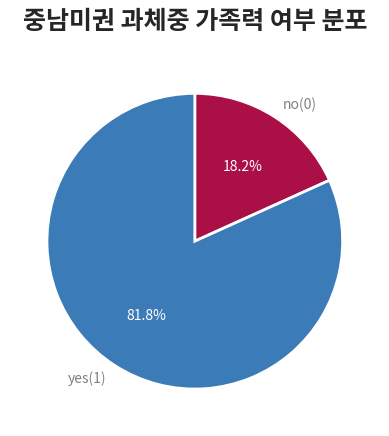

family_history_with_overweight
0     385
1    1726
Name: count, dtype: int64


In [104]:
pie_chart(obe_df, 'family_history_with_overweight', YN_label, ["#aa0f45",  "#3b7bb7"])

plt.title("중남미권 과체중 가족력 여부 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

print(obe_df['family_history_with_overweight'].value_counts().sort_index())

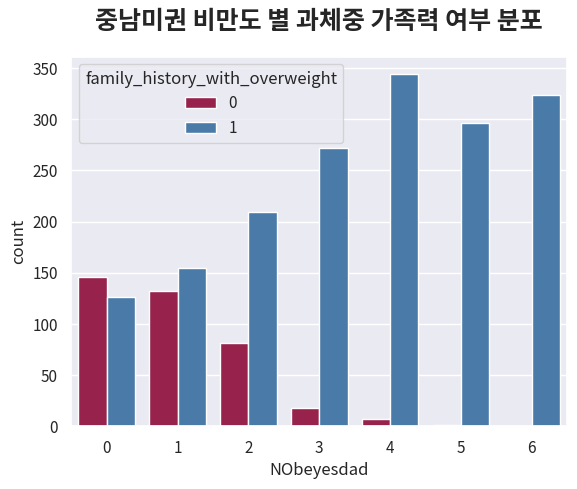

In [90]:
sns.countplot(x='NObeyesdad' , data=obe_df, hue='family_history_with_overweight', palette=["#aa0f45",  "#3b7bb7"])

plt.title("중남미권 비만도 별 과체중 가족력 여부 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

#### 과체중 가족력 데이터 분석
- 과체중이었거나 과체중인 가족 유무의 분포를 확인했을 때 가족력이 있다는 결과가 확연히 많았다.
- 비만도에 대한 분포가 고른 것을 고려했을 때 과체중, 비만일 수록 가족력이 높게 나타나는 것을 보아 타겟에 영향을 많이 미치는 피처로 예상된다.

### FAVC(고칼로리 식품 자주 섭취 여부)

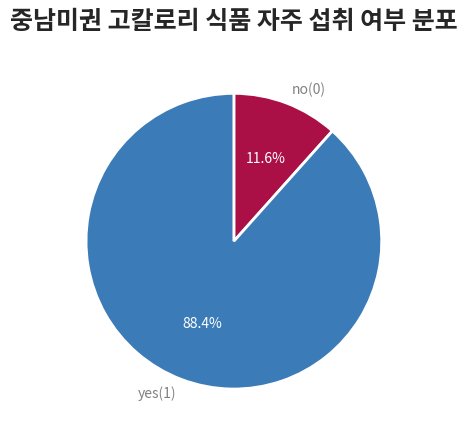

FAVC
0     245
1    1866
Name: count, dtype: int64


In [105]:
pie_chart(obe_df, 'FAVC', YN_label, ["#aa0f45",  "#3b7bb7"])

plt.title("중남미권 고칼로리 식품 자주 섭취 여부 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

print(obe_df['FAVC'].value_counts().sort_index())

- 고칼로리 식품 섭취 여부에 대해 대부분 자주 섭취하는 것으로 확인된다.

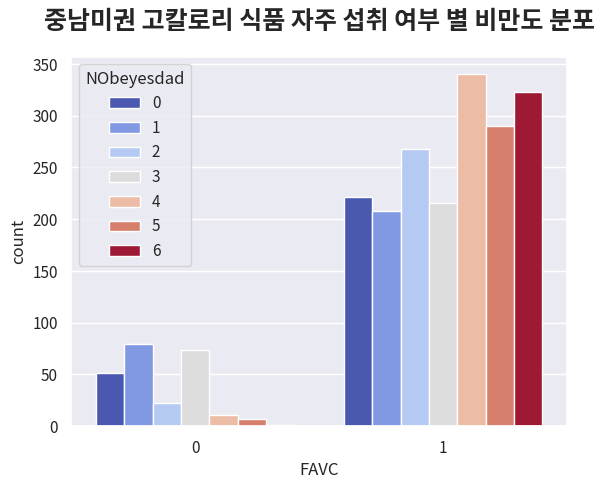

In [92]:
sns.countplot(x='FAVC', data=obe_df, hue='NObeyesdad', palette='coolwarm')

plt.title("중남미권 고칼로리 식품 자주 섭취 여부 별 비만도 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

- 고칼로리 식품을 자주 섭취할 수록 과체중, 비만인 분포가 높게 나타난다.

### FCVC(채소 섭취 빈도)

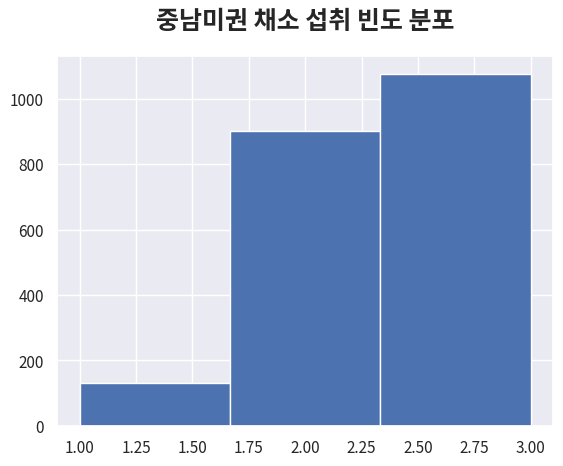

In [93]:
plt.hist(obe_df['FCVC'], bins=3)

plt.title("중남미권 채소 섭취 빈도 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

In [ ]:
obe_df['FCVC'].describe()

count    2111.000000
mean        2.419043
std         0.533927
min         1.000000
25%         2.000000
50%         2.385502
75%         3.000000
max         3.000000
Name: FCVC, dtype: float64

- 채소 섭취 빈도롤 보았을 때 상대적으로 채소를 적게 먹는 사람보다는 많이 먹는 사람의 분포가 더 많다.

### NCP(주식 섭취 빈도)

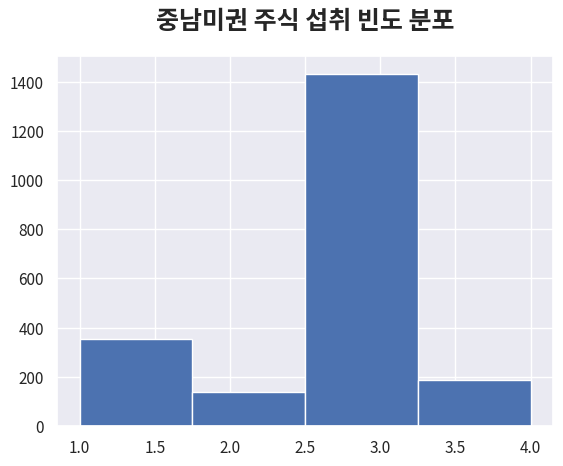

In [94]:
plt.hist(obe_df['NCP'], bins=4)

plt.title("중남미권 주식 섭취 빈도 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

In [ ]:
obe_df['NCP'].describe()

count    2111.000000
mean        2.685628
std         0.778039
min         1.000000
25%         2.658738
50%         3.000000
75%         3.000000
max         4.000000
Name: NCP, dtype: float64

- 주식 섭취 빈도는 세끼 먹는 비율이 가장 많다.

### CAEC(간식 섭취 빈도)

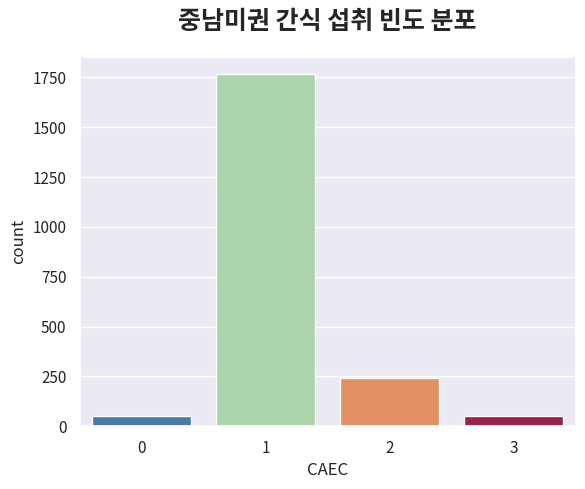

In [107]:
sns.countplot(x='CAEC', data=obe_df, palette=["#3b7bb7", "#a6dba4", "#f7894f", "#aa0f45"])

plt.title("중남미권 간식 섭취 빈도 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

- 식사 사이 간식을 섭취하는 빈도는 한 번이 가장 높은 분포를 보인다.

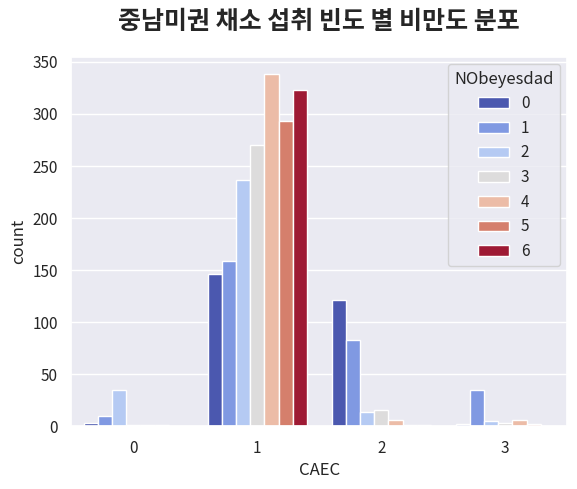

In [110]:
sns.countplot(x='CAEC', data=obe_df, hue='NObeyesdad', palette='coolwarm')

plt.title("중남미권 채소 섭취 빈도 별 비만도 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

### CH2O(물 섭취 횟수)

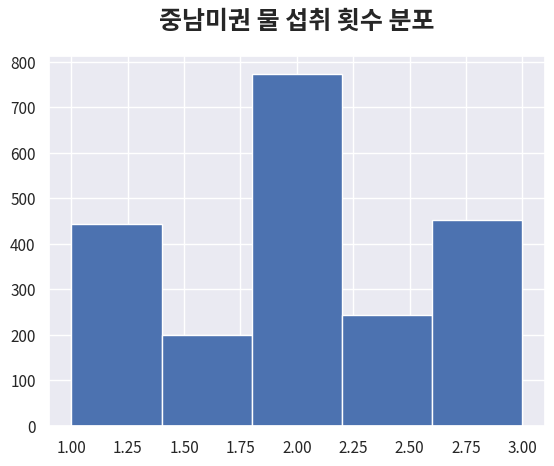

In [97]:
plt.hist(obe_df['CH2O'], bins=5)

plt.title("중남미권 물 섭취 횟수 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

In [ ]:
obe_df['NCP'].describe()

count    2111.000000
mean        2.685628
std         0.778039
min         1.000000
25%         2.658738
50%         3.000000
75%         3.000000
max         4.000000
Name: NCP, dtype: float64

- 물 섭취 횟수는 아예 마시지 않거나 4번정도 마시는 횟수가 아웃라이어로 보인다.
- 2번 가장 많이 마시고 전반적으로 1번 ~ 3번정도 마신다.

### SCC(칼로리 소비 모니터링 여부)

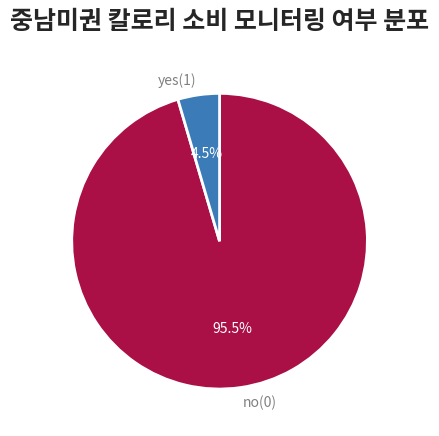

SCC
0    2015
1      96
Name: count, dtype: int64


In [111]:
pie_chart(obe_df, 'SCC', YN_label, ["#aa0f45", "#3b7bb7"])

plt.title("중남미권 칼로리 소비 모니터링 여부 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

print(obe_df['SCC'].value_counts().sort_index())

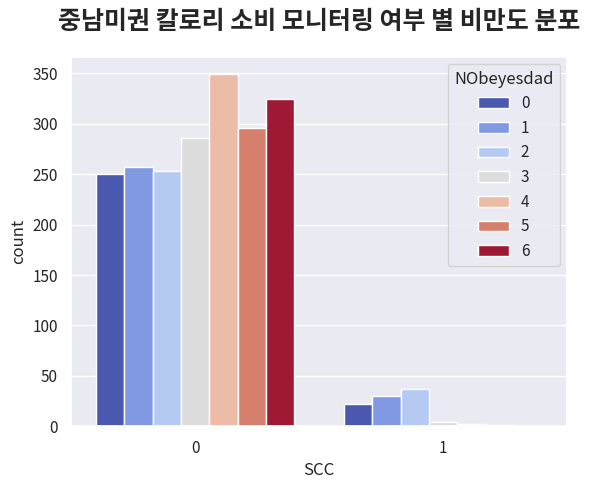

In [112]:
sns.countplot(x='SCC', data=obe_df, hue='NObeyesdad', palette='coolwarm')

plt.title("중남미권 칼로리 소비 모니터링 여부 별 비만도 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

- 대부분 칼로리 소비에 대한 모니터링을 하지 않는 것이 확인된다.
- 비만도 분포를 확인했을 때, 과체중 및 비만일 경우 상대적으로 더 모니터링을 하지 않는 경우가 많은 것을 확인했다.

### FAF(신체 활동 횟수)

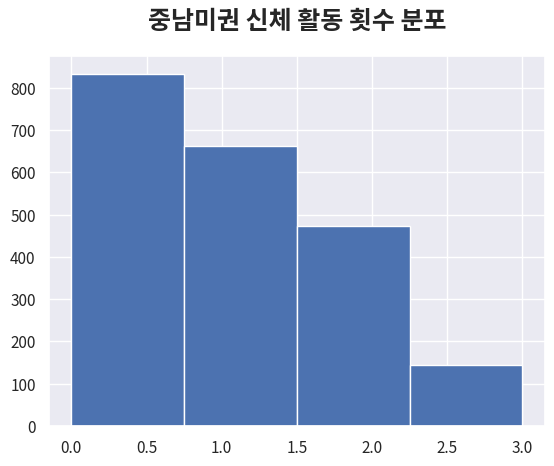

In [113]:
plt.hist(obe_df['FAF'], bins=4)

plt.title("중남미권 신체 활동 횟수 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

- 전반적으로 신체 활동 횟수는 0 ~ 2번 정도이고, 3번정도 하는 사람은 상대적으로 적다.

### MTRANS(주요 교통수단)

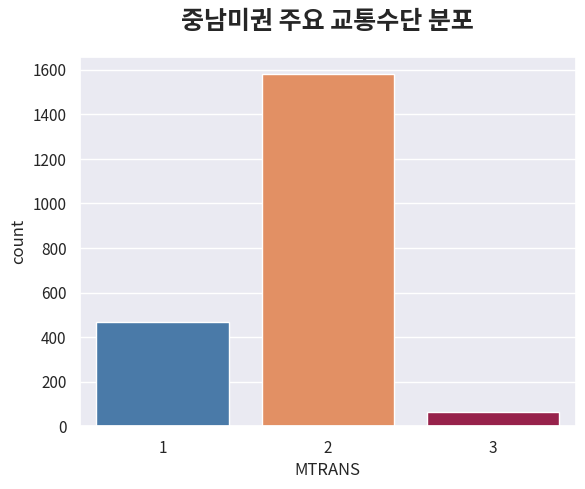

MTRANS
1     468
2    1580
3      63
Name: count, dtype: int64


In [114]:
sns.countplot(x='MTRANS', data=obe_df, palette=["#3b7bb7", "#f7894f", "#aa0f45"])

plt.title("중남미권 주요 교통수단 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

print(obe_df['MTRANS'].value_counts().sort_index())

- 대부분 대중교통(2)를 많이 타고, 그 다음으로 자가용 및 오토바이(1)를 탄다.
- 상대적으로 걷거나 자전거(3)를 타며 신체 활동이 높은 교통 수단을 이용하는 사람은 적게 분포되어 있다.

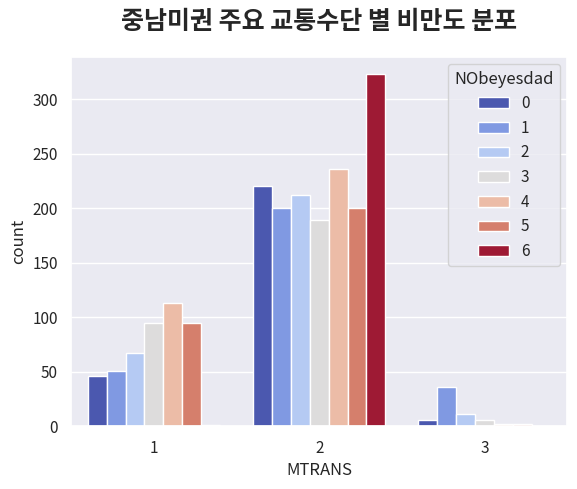

In [115]:
sns.countplot(x='MTRANS', data=obe_df, hue='NObeyesdad', palette='coolwarm')

plt.title("중남미권 주요 교통수단 별 비만도 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

#### 주요 교통수단 데이터 분석
- 걷기&자전거를 타는 비만 분포는 상대적으로 아주 낮은 편이다.
- 주요 교통 수단도 신체활동으로서 어느 정도 영향을 주는 피처가 될 것으로 예상한다.

### TUE(전자기기 사용시간)

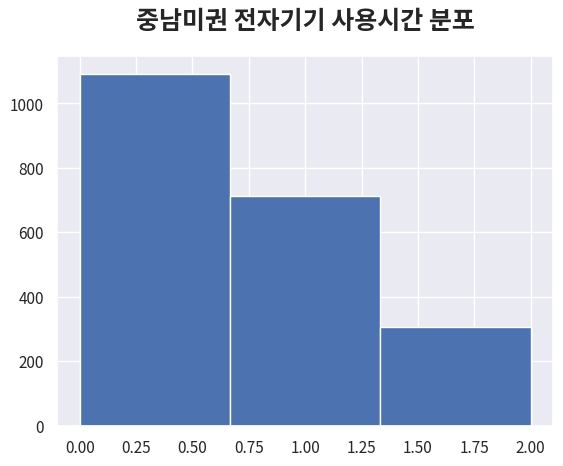

In [116]:
plt.hist(obe_df['TUE'], bins=3)

plt.title("중남미권 전자기기 사용시간 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

- 전자기기 사용 시간이 0 ~ 1.3 값을 가지는 값들이 상대적으로 많이 분포되어 있다.

### SMOKE(흡연 여부)

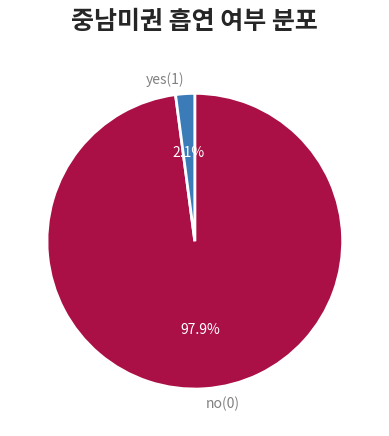

SMOKE
0    2067
1      44
Name: count, dtype: int64


In [118]:
pie_chart(obe_df, 'SMOKE', YN_label, ["#aa0f45", "#3b7bb7"])

plt.title("중남미권 흡연 여부 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

print(obe_df['SMOKE'].value_counts().sort_index())

- 응답자 대부분 흡연을 하지 않는 것으로 확인된다.

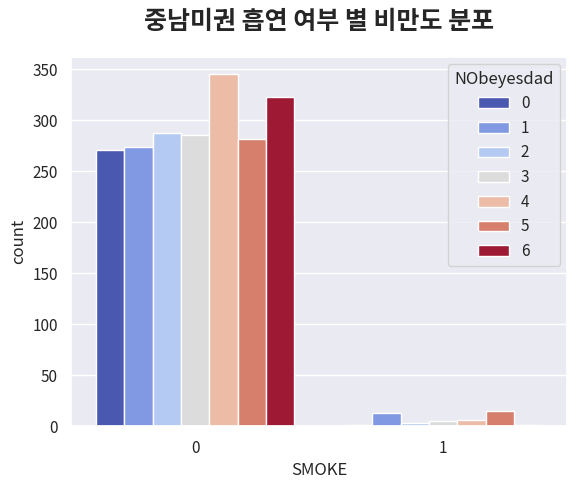

In [119]:
sns.countplot(x='SMOKE', data=obe_df, hue='NObeyesdad', palette='coolwarm')

plt.title("중남미권 흡연 여부 별 비만도 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

### CALC(음주 빈도)

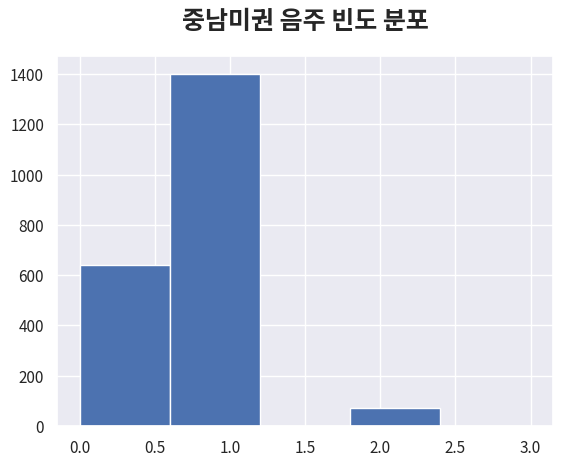

In [120]:
plt.hist(obe_df['CALC'], bins=5)

plt.title("중남미권 음주 빈도 분포", fontsize=18, pad=20, fontweight='bold')

plt.show()

- 음주 빈도는 상대적으로 적게 마시는 사람이 많은 분포를 보인다.

## 2-2. 아웃라이어 확인, 시각화

In [ ]:
# 아웃라이어 찾는 함수 정의
def find_outlier(df, col):
  col_data = df[col]

  q3 = np.percentile(col_data.values, 75)
  q2 = np.percentile(col_data.values, 50)
  q1 = np.percentile(col_data.values, 25)

  iqr = q3 - q1
  iqr = iqr * 1.5

  lowest = q1 - iqr
  center = q2
  highest = q3 + iqr

  outlier_q1_idx = col_data[col_data < lowest].index
  outlier_q3_idx = col_data[col_data > highest].index
  outlier_idx = outlier_q1_idx.append(outlier_q3_idx)

  # 아웃라이어 총 개수
  outlier_cnt = len(outlier_idx)
  # q1 이하 아웃라이어 개수
  outlier_q1_cnt = len(outlier_q1_idx)
  # q3 이상 아웃라이어 개수
  outlier_q3_cnt = len(outlier_q3_idx)

  # 데이터프레임에 넣을 아웃라이어 데이터 정리
  outlier_data = [col,outlier_cnt, outlier_q1_cnt, outlier_q3_cnt, lowest, center, highest]

  ## 아웃라이어 행 삭제시 아래 주석 사용
  # df.drop(outlier_idx, axis=0, inplace=True)
  return outlier_data

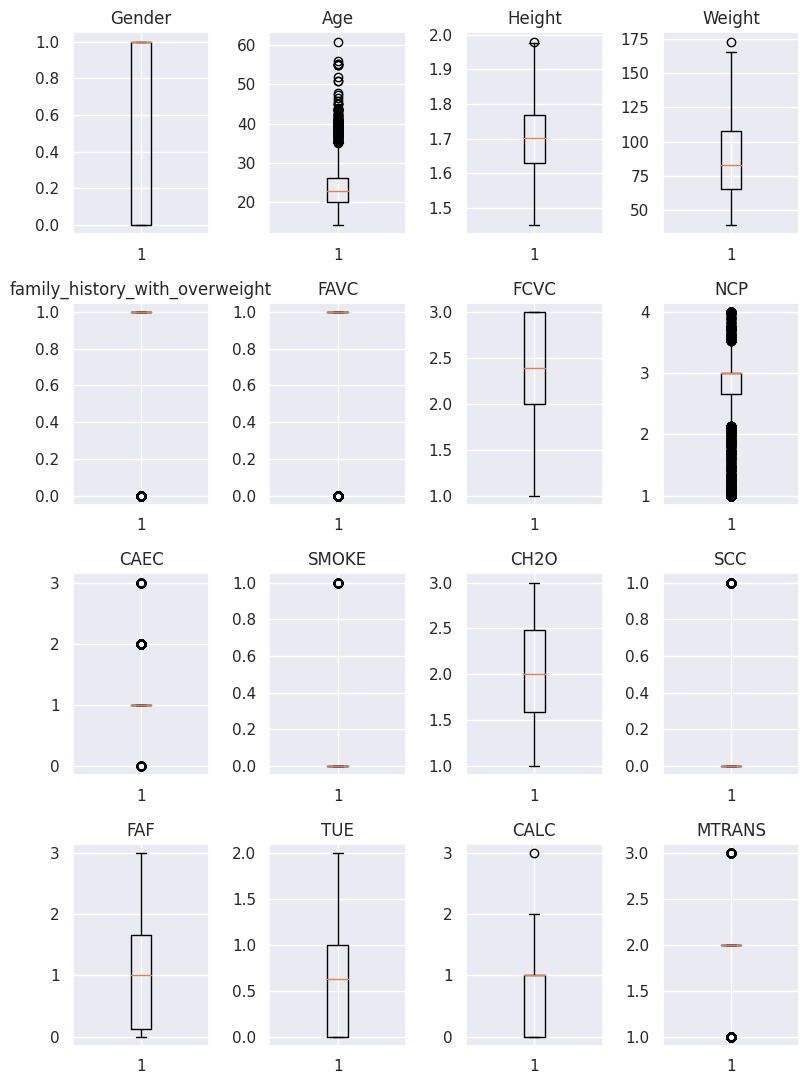

outlier_count  outlier_under_q1_count  \
Feature                                                                 
Gender                                      0                       0   
Age                                       168                       0   
Height                                      1                       0   
Weight                                      1                       0   
family_history_with_overweight            385                     385   
FAVC                                      245                     245   
FCVC                                        0                       0   
NCP                                       579                     431   
CAEC                                      346                      51   
SMOKE                                      44                       0   
CH2O                                        0                       0   
SCC                                        96                       0   
FAF                                         0                       0   
TUE                                         0                       0   
CALC                                        1                       0   
MTRANS                                    531                     468   

                                outlier_under_q3_count  lowest_q1  center_q2  \
Feature                                                                        
Gender                                               0  -1.500000   1.000000   
Age                                                168  10.867980  22.777890   
Height                                               1   1.422304   1.700499   
Weight                                               1   2.537334  83.000000   
family_history_with_overweight                       0   1.000000   1.000000   
FAVC                                                 0   1.000000   1.000000   
FCVC                                                 0   0.500000   2.385502   
NCP                                                148   2.146845   3.000000   
CAEC                                               295   1.000000   1.000000   
SMOKE                                               44   0.000000   0.000000   
CH2O                                                 0   0.245901   2.000000   
SCC                                                 96   0.000000   0.000000   
FAF                                                  0  -2.188754   1.000000   
TUE                                                  0  -1.500000   0.625350   
CALC                                                 1  -1.500000   1.000000   
MTRANS                                              63   2.000000   2.000000   

                                hightest_q3  
Feature                                      
Gender                             2.500000  
Age                               35.079212  
Height                             1.976160  
Weight                           170.366691  
family_history_with_overweight     1.000000  
FAVC                               1.000000  
FCVC                               4.500000  
NCP                                3.511893  
CAEC                               1.000000  
SMOKE                              0.000000  
CH2O                               3.816331  
SCC                                0.000000  
FAF                                3.979936  
TUE                                2.500000  
CALC                               2.500000  
MTRANS                             2.000000

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(8, 11))
ax = ax.ravel()

outlier_df = pd.DataFrame(columns=['Feature', 'outlier_count', 'outlier_under_q1_count', 'outlier_under_q3_count', 'lowest_q1', 'center_q2', 'hightest_q3'])

for i, col in enumerate(feature_names):
  # subplot별 박스플롯 생성
  ax[i].boxplot(obe_df[col])
  ax[i].set_title(f"{col}")

  # 아웃라이어 확인 데이터 프레임 생성
  outlier_data = find_outlier(obe_df, col)

  # 아웃라이어 데이터 인덱스별 추가
  outlier_df.loc[i] = outlier_data

plt.tight_layout()

plt.show()

outlier_df.set_index('Feature')

- 이상치가 없는 카테고리 값을 가지는 피처 데이터 : Gender, FCVC, CH20, FAF, TUE
- 이상치가 많지만 카테고리 값을 가지는 피처 데이터 : family_history_with_overweight, FAVC, CAEC, SMOKE, SCC, MTRANS
- 이상치가 많지만 연속형 값을 가지는 피처 데이터 : Age, NCP
  - 카테고리 형태로 넣을 수 있지만 연속형 값으로 들어간 나이, 빈도

- 피처 데이터 특성 상 이상치가 포함되도 감안하고 일단 모델에 넣어보고 이상치 데이터를 위한 전처리가 필요할지 확인해보겠다.

In [ ]:
# 아웃라이어가 있는 인덱스를 찾는 함수 재정의
def find_outlier(df, col):
  col_data = df[col]

  q3 = np.percentile(col_data.values, 75)
  q2 = np.percentile(col_data.values, 50)
  q1 = np.percentile(col_data.values, 25)

  iqr = q3 - q1
  iqr = iqr * 1.5

  lowest = q1 - iqr
  center = q2
  highest = q3 + iqr

  outlier_q1_idx = col_data[col_data < lowest].index
  outlier_q3_idx = col_data[col_data > highest].index
  outlier_idx = outlier_q1_idx.append(outlier_q3_idx)

  # 아웃라이어 총 개수
  outlier_cnt = len(outlier_idx)
  # q1 이하 아웃라이어 개수
  outlier_q1_cnt = len(outlier_q1_idx)
  # q3 이상 아웃라이어 개수
  outlier_q3_cnt = len(outlier_q3_idx)

  # 데이터프레임에 넣을 아웃라이어 데이터 정리
  outlier_data = [col,outlier_cnt, outlier_q1_cnt, outlier_q3_cnt, lowest, center, highest]

  ## 아웃라이어 행 삭제시 아래 주석 사용
  # df.drop(outlier_idx, axis=0, inplace=True)
  return outlier_idx

### 이상치가 한 개인 피처 데이터 확인
- Height, Weight, CALC

In [ ]:
check_calc_idx = find_outlier(obe_df, 'CALC')

obe_df.loc[check_calc_idx, 'CALC']

26    3
Name: CALC, dtype: int64

In [ ]:
check_height_idx = find_outlier(obe_df, 'Height')

obe_df.loc[check_height_idx, 'Height']

349    1.98
Name: Height, dtype: float64

In [ ]:
check_weight_idx = find_outlier(obe_df, 'Weight')

obe_df.loc[check_weight_idx, 'Weight']

344    173.0
Name: Weight, dtype: float64

- CALC : 음주 빈도를 나타내는 (거의(3)/빈번히(2)/가끔(1)/섭취X(0) 카테고리형 데이터로 3을 값으로 하는 아웃라이어 1개로 확인
- 연속형 값을 가지는 Height와 Weight는 이상치 데이터 각각 확인

## 2-3. 타겟 데이터와 피처 데이터의 상관관계 확인

In [ ]:
feature_names

['Gender',
 'Age',
 'Height',
 'Weight',
 'family_history_with_overweight',
 'FAVC',
 'FCVC',
 'NCP',
 'CAEC',
 'SMOKE',
 'CH2O',
 'SCC',
 'FAF',
 'TUE',
 'CALC',
 'MTRANS']

In [ ]:
# 타겟 데이터(비만도)와 피처 데이터 간의 상관관계 절대값으로 확인 => 0 ~ 1 사이의 값 반환

np.abs(obe_df.loc[:, all_data_names].corr()["NObeyesdad"]).sort_values(ascending=False) # 내림차순 정렬

NObeyesdad                        1.000000
Weight                            0.913251
family_history_with_overweight    0.505148
CAEC                              0.329350
Age                               0.282913
FAVC                              0.247793
FCVC                              0.227759
FAF                               0.199901
SCC                               0.194508
CALC                              0.151752
Height                            0.133565
CH2O                              0.133008
TUE                               0.107991
Gender                            0.031464
NCP                               0.026690
MTRANS                            0.024998
SMOKE                             0.003442
Name: NObeyesdad, dtype: float64

#### 상관관계 분석
- 가장 높은 상관관계를 보이는 것은 몸무게. 키보다는 몸무게와 비만도의 상관관계가 높은 것을 확인
  - 키는 남녀별 평균이 존재하는 반면, 몸무게 분포는 훨씬 다양하게 나타났기 때문으로 추정
  - 몸무게와 키에 대한 수치로 타겟 데이터의 클래스가 정해졌기 때문에 몸무게와 상관관계가 높은 피처들을 같이 확인해야 할듯
- 두 번째로 높은 상관관계는 과체중 가족력
  - 유전적 요인이 비만에 영향이 큰 것으로 추정
- 세 번째로 높은 상관관계는 CAEC(식간 섭취 빈도)
- 나이, FACV(고칼로리 자주 섭취 여부), FCVC(채소 섭취 빈도)가 차례로 상관관계 높음

### [번외]Weight 피처 데이터 제외한 피처와 타겟 데이터의 상관관계 확인

In [ ]:
# Weight 컬럼 제외한 데이터프레임 생성
check_coor_df = obe_df.loc[:, all_data_names].copy() # 원본 데이터프레임 복사
del check_coor_df['Weight']
check_coor_df.head()

Gender   Age  Height  family_history_with_overweight  FAVC  FCVC  NCP  \
0       0  21.0    1.62                               1     0   2.0  3.0   
1       0  21.0    1.52                               1     0   3.0  3.0   
2       1  23.0    1.80                               1     0   2.0  3.0   
3       1  27.0    1.80                               0     0   3.0  3.0   
4       1  22.0    1.78                               0     0   2.0  1.0   

   CAEC  SMOKE  CH2O  SCC  FAF  TUE  CALC  MTRANS  NObeyesdad  
0     1      0   2.0    0  0.0  1.0     0       2           1  
1     1      1   3.0    1  3.0  0.0     1       2           1  
2     1      0   2.0    0  2.0  1.0     2       2           1  
3     1      0   2.0    0  2.0  0.0     2       3           2  
4     1      0   2.0    0  0.0  0.0     1       2           3

In [ ]:
# 타겟 데이터(비만도)와 피처 데이터 간의 상관관계 절대값으로 확인 => 0 ~ 1 사이의 값 반환
np.abs(check_coor_df.corr()["NObeyesdad"]).sort_values(ascending=False) # 내림차순 정렬

NObeyesdad                        1.000000
family_history_with_overweight    0.505148
CAEC                              0.329350
Age                               0.282913
FAVC                              0.247793
FCVC                              0.227759
FAF                               0.199901
SCC                               0.194508
CALC                              0.151752
Height                            0.133565
CH2O                              0.133008
TUE                               0.107991
Gender                            0.031464
NCP                               0.026690
MTRANS                            0.024998
SMOKE                             0.003442
Name: NObeyesdad, dtype: float64

- 몸무게 제거 후 확인해도 비만도에 대한 다른 피처와의 상관지수는 제거 전과 동일하다.
- 해당 피처는 삭제하지 않고 진행하기로 결정

In [ ]:
# Height 컬럼 제외한 데이터프레임 생성
check_coor_df = obe_df.loc[:, all_data_names].copy() # 원본 데이터프레임 복사
del check_coor_df['Height']
check_coor_df.head()

Gender   Age  Weight  family_history_with_overweight  FAVC  FCVC  NCP  \
0       0  21.0    64.0                               1     0   2.0  3.0   
1       0  21.0    56.0                               1     0   3.0  3.0   
2       1  23.0    77.0                               1     0   2.0  3.0   
3       1  27.0    87.0                               0     0   3.0  3.0   
4       1  22.0    89.8                               0     0   2.0  1.0   

   CAEC  SMOKE  CH2O  SCC  FAF  TUE  CALC  MTRANS  NObeyesdad  
0     1      0   2.0    0  0.0  1.0     0       2           1  
1     1      1   3.0    1  3.0  0.0     1       2           1  
2     1      0   2.0    0  2.0  1.0     2       2           1  
3     1      0   2.0    0  2.0  0.0     2       3           2  
4     1      0   2.0    0  0.0  0.0     1       2           3

In [ ]:
# 타겟 데이터(비만도)와 피처 데이터 간의 상관관계 절대값으로 확인 => 0 ~ 1 사이의 값 반환
np.abs(check_coor_df.corr()["NObeyesdad"]).sort_values(ascending=False) # 내림차순 정렬

NObeyesdad                        1.000000
Weight                            0.913251
family_history_with_overweight    0.505148
CAEC                              0.329350
Age                               0.282913
FAVC                              0.247793
FCVC                              0.227759
FAF                               0.199901
SCC                               0.194508
CALC                              0.151752
CH2O                              0.133008
TUE                               0.107991
Gender                            0.031464
NCP                               0.026690
MTRANS                            0.024998
SMOKE                             0.003442
Name: NObeyesdad, dtype: float64

- 다른 피처 데이터를 삭제해도 동일한 결과를 보인다.

## 2-4. 히트맵으로 데이터 간의 상관관계 확인

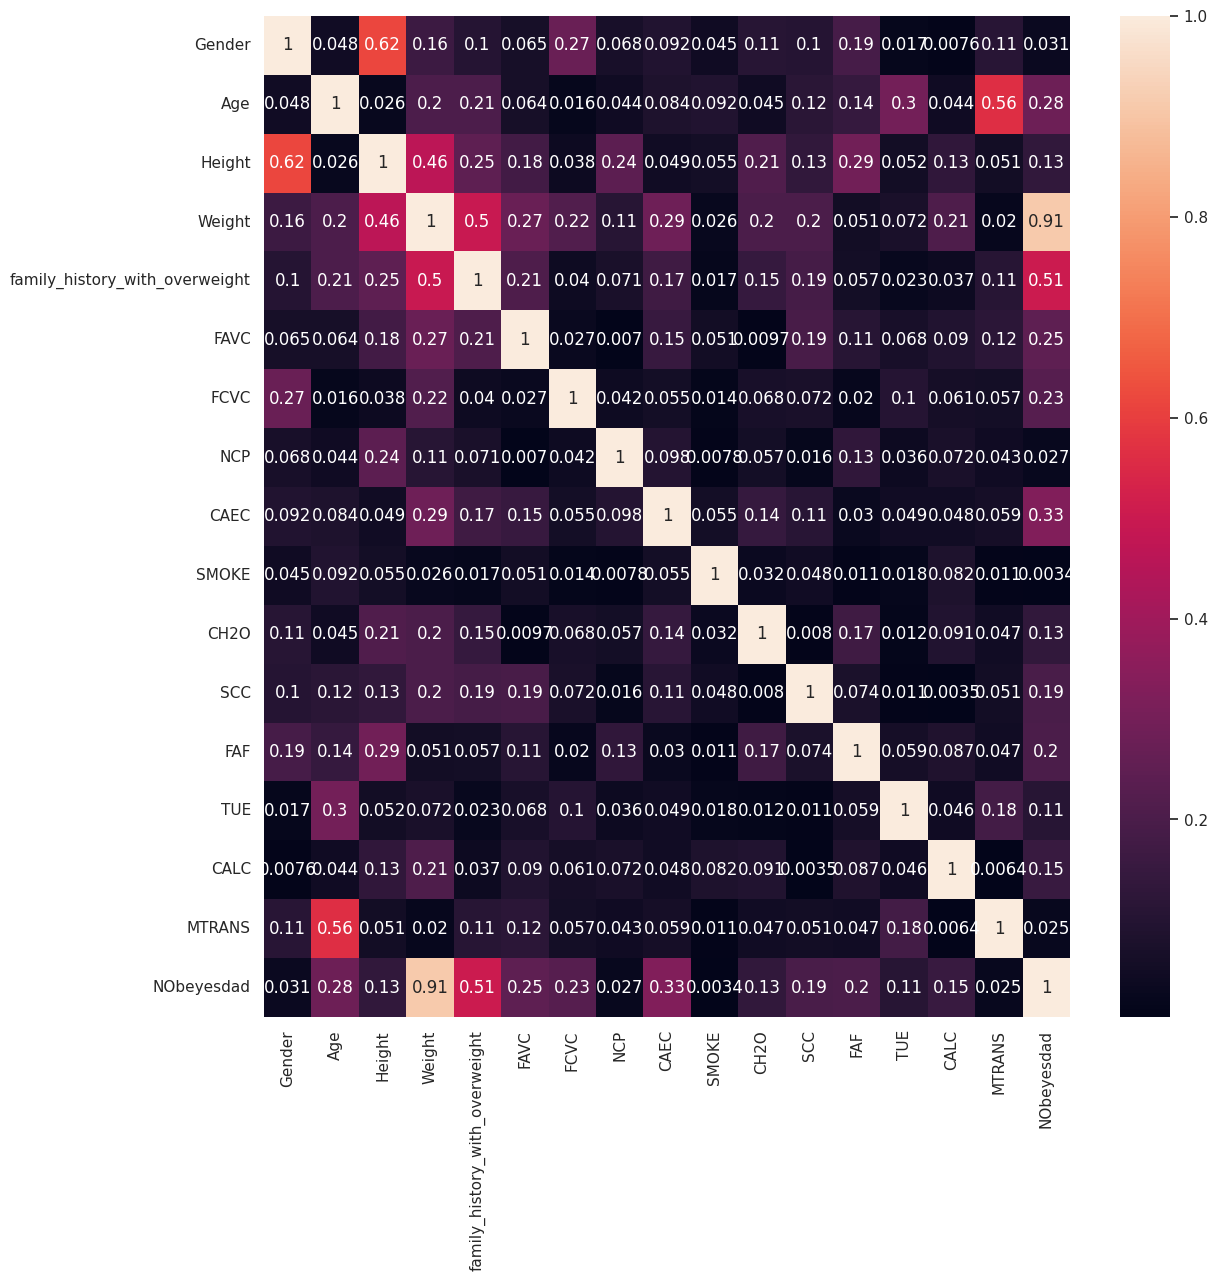

In [ ]:
# 피처간 상관관계지수 확인
corr_matrix_pos = np.abs(obe_df.loc[:, all_data_names].corr()) # 절대값으로 확인

plt.figure(figsize=(13, 13))

sns.heatmap(
    data=corr_matrix_pos,
    annot=True # 값 표출
)

plt.show()

In [ ]:
# 상관지수가 0.4 이상인 데이터 확인
for col in all_data_names:
  check_corr = corr_matrix_pos[corr_matrix_pos >= 0.4][col]
  print(f'<{col}와 상관지수가 0.4 이상인 피처>')
  print(check_corr[check_corr.notnull()].sort_values(ascending=False))
  print()

<Gender와 상관지수가 0.4 이상인 피처>
Gender    1.000000
Height    0.618466
Name: Gender, dtype: float64

<Age와 상관지수가 0.4 이상인 피처>
Age       1.000000
MTRANS    0.561992
Name: Age, dtype: float64

<Height와 상관지수가 0.4 이상인 피처>
Height    1.000000
Gender    0.618466
Weight    0.463136
Name: Height, dtype: float64

<Weight와 상관지수가 0.4 이상인 피처>
Weight                            1.000000
NObeyesdad                        0.913251
family_history_with_overweight    0.496820
Height                            0.463136
Name: Weight, dtype: float64

<family_history_with_overweight와 상관지수가 0.4 이상인 피처>
family_history_with_overweight    1.000000
NObeyesdad                        0.505148
Weight                            0.496820
Name: family_history_with_overweight, dtype: float64

<FAVC와 상관지수가 0.4 이상인 피처>
FAVC    1.0
Name: FAVC, dtype: float64

<FCVC와 상관지수가 0.4 이상인 피처>
FCVC    1.0
Name: FCVC, dtype: float64

<NCP와 상관지수가 0.4 이상인 피처>
NCP    1.0
Name: NCP, dtype: float64

<CAEC와 상관지수가 0.4 이상인 피처>
CAEC    1.0
Name: CAEC

#### 상관관계가 높은 피처
- Weight(몸무게) & NObeyesdad(비만도) : 0.91
- Gender(성별) & Height(키) : 0.62
- Age(나이) & MTRANS(주요 교통수단) : 0.56
- family_history_with_overweight(과체중 가족력) & NObeyesdad(비만도) : 0.51
- Weight(몸무게) & family_history_with_overweight(과체중 가족력) : 0.5
- Weight(몸무게) &  키(Height) : 0.46

## 2-5. 상관관계가 높은 피처 데이터 확인
- 이전 데이터 분석에서 확인하지 못한 피처간의 관계만 확인

### Gender & Height : 0.62

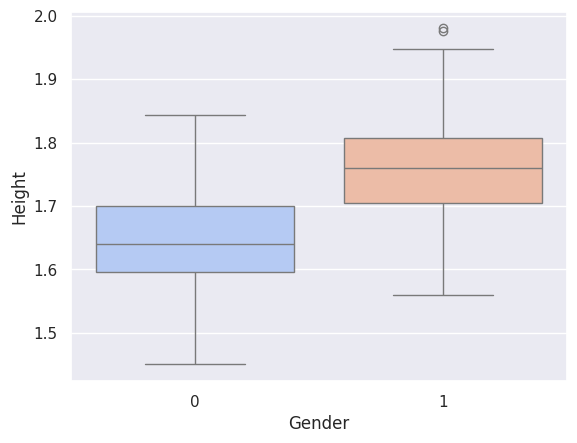

In [ ]:
sns.boxplot(x='Gender',  y='Height', data=obe_df, palette='coolwarm')

plt.show()

- 성별 별 키의 분포는 아주 크거나 많은 아웃라이어를 가지고 있지 않다. 남녀 평균키를 기준으로 해당 분포를 띄기 때문에, 높은 상관관계를 보인 것 같다.
- 신체적인 특성때문에 특별한 상관관계로는 보이지 않는다.

### Age & MTRANS : 0.56

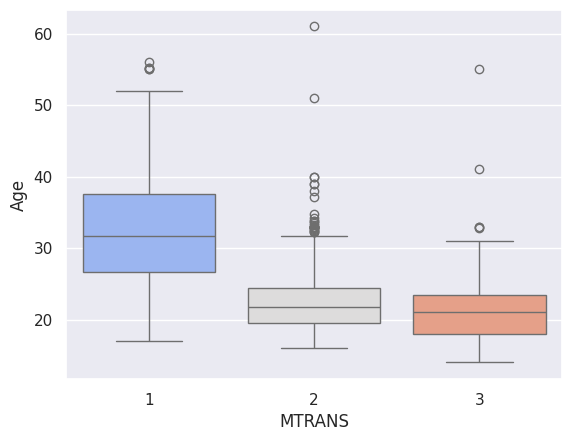

In [ ]:
sns.boxplot(x='MTRANS',  y='Age', data=obe_df, palette='coolwarm')

plt.show()

- 주요 교통수단으로 자가용, 오토바이(1)를 이용하는 연령은 20대 후반에서 30대 후반이 가장 많다.
- 주요 교통 수단으로 대중교통(2)을 이용하는 연령은 20대 초반에서 20대 중반 사이가 가장 많다. 30대 초중반부터는 대중교통보다 자가용이나 오토바이(1)를 더 많이 이용하는 것 같다.
- 주요 교통 수단으로 걷거나 자전거(3)를 이용하는 연령은 10대 후반 에서 20대 초반이 가장 많다.
- 연령이 주로 10 ~ 30대 데이터 표본이 많은 점을 보아 40 ~ 60 대 특성을 충분히 반영하지 못했을 수도 있다는 점을 유의하자.
  - 10 ~ 30대 데이터 표본만으로 예측 모델을 하면 달라지는 점이 있을지 확인해보면 좋을 것 같다.

### Weight & family_history_with_overweight : 0.5


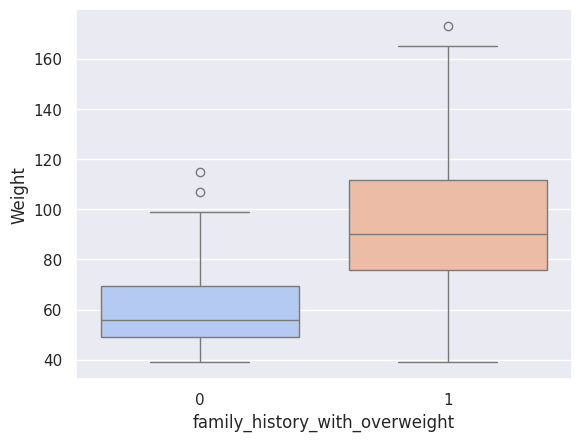

In [ ]:
sns.boxplot(x='family_history_with_overweight',  y='Weight', data=obe_df, palette='coolwarm')

plt.show()

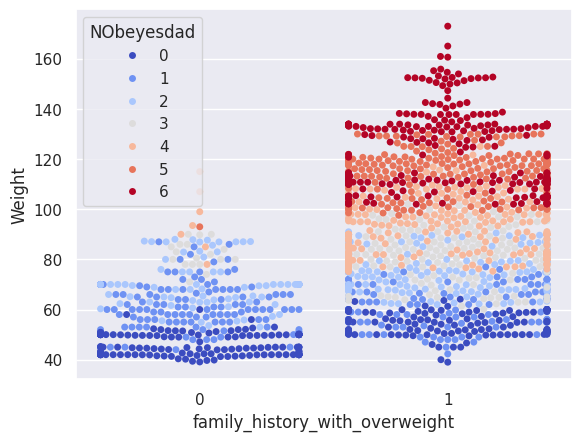

In [ ]:
sns.swarmplot(x='family_history_with_overweight',  y='Weight', hue='NObeyesdad', data=obe_df, palette='coolwarm')

plt.show()

- 타겟 데이터인 비만도와 상관관계간 높은 피처 데이터인 몸무게와 과체중 가족력이 높은 상관관계를 보인다.
- 몸무게는 과체중 가족력 유무 둘 다 비만도가 저체중에서 고도 비만까지 양의 방향성을 띄고 있다.
- 과체중 가족력이 없는 경우, 몸무게가 전반적으로 낮게 분포하고 저체중이 상대적으로 더 많이 분포해있다.100KG 이상의 비만도 4, 5, 6은 적게 분포되어 있다.
- 과체중 및 비만의 경우 상대적으로 과체중 가족력이 있을 때 뚜렷하게 확인될 수 있고 몸무게도 더 높게 분포되어 있다.
- 몸무게&비만도에 과체중 가족력이 영향을 많이 미치는 피처로 다시한번 확인된다.

### Weight(몸무게) & 키(Height) : 0.46

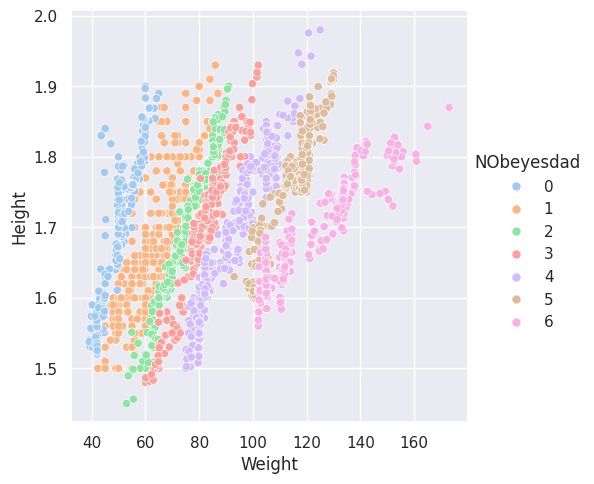

In [ ]:
sns.relplot(x='Weight', y='Height', data=obe_df, palette='pastel', hue='NObeyesdad')

- 키와 몸무게는 양의 상관관계를 보인다. 키와 몸무게별로 비만도의 분포도 일정한 형태를 띈다.

## 2-6. 여성의 비만도 영향 피처 찾기
- 남성과 여성의 신체적인 차이로 키와 몸무게의 분포가 다르게 나타나고, 비만도의 분포도 다르게 나타나기 때문에, 성별이 여자일 때 정상 체중과 비만인 데이터를 확인해 비만도에 영향을 주는 데이터를 찾아보겠다.

In [ ]:
# 여성+비만도2인 데이터 확인
obe_df[(obe_df['Gender'] == 0) & (obe_df['NObeyesdad'] == 2)].describe()

Gender         Age      Height      Weight  \
count   145.0  145.000000  145.000000  145.000000   
mean      0.0   24.578058    1.637225   69.579014   
std       0.0    7.477911    0.078728    6.971323   
min       0.0   16.000000    1.450000   53.000000   
25%       0.0   18.845518    1.593894   65.000000   
50%       0.0   21.455463    1.620000   68.771850   
75%       0.0   30.958957    1.709585   75.000000   
max       0.0   42.244750    1.779882   86.934846   

       family_history_with_overweight        FAVC        FCVC         NCP  \
count                      145.000000  145.000000  145.000000  145.000000   
mean                         0.765517    0.924138    2.298448    2.357958   
std                          0.425144    0.265695    0.500854    0.913597   
min                          0.000000    0.000000    1.000000    1.000000   
25%                          1.000000    1.000000    2.000000    1.198643   
50%                          1.000000    1.000000    2.138334    2.849848   
75%                          1.000000    1.000000    2.838969    3.000000   
max                          1.000000    1.000000    3.000000    3.995957   

             CAEC       SMOKE        CH2O         SCC         FAF         TUE  \
count  145.000000  145.000000  145.000000  145.000000  145.000000  145.000000   
mean     1.020690    0.013793    1.909575    0.206897    0.882983    0.707934   
std      0.362648    0.117036    0.576421    0.406485    0.876865    0.709787   
min      0.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
25%      1.000000    0.000000    1.509734    0.000000    0.110174    0.000000   
50%      1.000000    0.000000    2.000000    0.000000    0.747528    0.480214   
75%      1.000000    0.000000    2.203120    0.000000    1.153775    1.301385   
max      3.000000    1.000000    3.000000    1.000000    3.000000    2.000000   

             CALC      MTRANS  NObeyesdad  
count  145.000000  145.000000       145.0  
mean     0.882759    1.717241         2.0  
std      0.478764    0.495864         0.0  
min      0.000000    1.000000         2.0  
25%      1.000000    1.000000         2.0  
50%      1.000000    2.000000         2.0  
75%      1.000000    2.000000         2.0  
max      2.000000    3.000000         2.0

In [ ]:
# 여성+비만도5인 데이터 확인 - 비만도 중 가장 많이 분포
obe_df[(obe_df['Gender'] == 0) & (obe_df['NObeyesdad'] == 6)].describe()

Gender         Age      Height      Weight  \
count   323.0  323.000000  323.000000  323.000000   
mean      0.0   23.512568    1.686995  120.779941   
std       0.0    2.751570    0.064566   15.282560   
min       0.0   18.112503    1.560000  102.000000   
25%       0.0   21.025597    1.630829  109.083197   
50%       0.0   25.427240    1.668951  112.000000   
75%       0.0   26.000000    1.743245  133.482045   
max       0.0   26.000000    1.843419  165.057269   

       family_history_with_overweight        FAVC   FCVC    NCP   CAEC  \
count                           323.0  323.000000  323.0  323.0  323.0   
mean                              1.0    0.996904    3.0    3.0    1.0   
std                               0.0    0.055641    0.0    0.0    0.0   
min                               1.0    0.000000    3.0    3.0    1.0   
25%                               1.0    1.000000    3.0    3.0    1.0   
50%                               1.0    1.000000    3.0    3.0    1.0   
75%                               1.0    1.000000    3.0    3.0    1.0   
max                               1.0    1.000000    3.0    3.0    1.0   

            SMOKE        CH2O    SCC         FAF         TUE        CALC  \
count  323.000000  323.000000  323.0  323.000000  323.000000  323.000000   
mean     0.003096    2.209138    0.0    0.660683    0.603399    0.996904   
std      0.055641    0.604607    0.0    0.730208    0.281425    0.055641   
min      0.000000    1.000000    0.0    0.000000    0.000000    0.000000   
25%      0.000000    1.664687    0.0    0.000000    0.412956    1.000000   
50%      0.000000    2.435978    0.0    0.220825    0.656491    1.000000   
75%      0.000000    2.693342    0.0    1.458697    0.850799    1.000000   
max      1.000000    3.000000    0.0    1.999897    1.000000    1.000000   

           MTRANS  NObeyesdad  
count  323.000000       323.0  
mean     1.996904         6.0  
std      0.055641         0.0  
min      1.000000         6.0  
25%      2.000000         6.0  
50%      2.000000         6.0  
75%      2.000000         6.0  
max      2.000000         6.0

### 여자 + 비만도 2(정상체중) 피처 데이터 주요 분포(IQR) 확인
- 연령 : 18 ~ 31세
- 키 : 1.59 ~ 1.7m
- 몸무게 : 65 ~ 75kg
- 과체중 가족력 : 예
- 고칼로리 자주 식품 섭취 : 예
- 채소 섭취 빈도 : 2 ~ 2.8
- 주식 섭취 빈도 : 1.2 ~ 3
- 간식 섭취 빈도 1
- 흡연 여부 : 아니오
- 물 섭취 빈도 : 1.5 ~ 2.2
- 칼로리 소비 모니터링 여부 : 아니오
- 신체활동 빈도 : 0.1 ~ 1.2. 평균 0.7
- 전자기기 사용 : 0 ~ 1.3
- 음주 빈도 : 1
- 주요 교통수단 : 대중교통 > 자가용&오토바이

### 여자 + 비만도 6(Obesity_Type_III) 피처 데이터 주요 분포(IQR) 확인
- 연령 : 24세
- 키 : 1.6 ~ 1.62m
- 몸무게 : 94.8 ~ 98.6kg
- 과체중 가족력 : 예/아니오 고르게 분포
- 고칼로리 자주 식품 섭취 : 예/아니오 고르게 분포
- 채소 섭취 빈도 : 3(가장 높은 빈도)
- 주식 섭취 빈도 : 1.75 ~ 3.25
- 간식 섭취 빈도 1.5 ~ 2.5
- 흡연 여부 : 아니오
- 물 섭취 빈도 : 1
- 칼로리 소비 모니터링 여부 : 아니오
- 신체활동 빈도 : 0.5 ~ 1.5, 평균 1
- 전자기기 사용 : 0.5 ~ 1.5
- 음주 빈도 : 0.25 ~ 0.78
- 주요 교통수단 : 대중교통

- SMOKE 데이터를 확인해보면 대부분 흡연을 하지 않기 때문에 유의미한 피처로 보기 어렵다.
- 두 데이터를 비교했을 때 몸무게 및 비만도에 영향을 주는 피처는 식품 섭취 관련 피처인 것으로 보인다. 전반적으로 비만도 5인 데이터가 채소, 주식, 간식 섭취 관련 피처에 상대적으론 높은 수치이고, 물 섭취 빈도는 상대적으로 낮다.
- 비만도 타겟 데이터에서 비만도 5 다음으로 높은 분포를 보이는 높은 비만도4도 같이 확인해보겠다.


In [ ]:
# 여자+비만도4인 데이터 확인
obe_df[(obe_df['Gender'] == 0) & (obe_df['NObeyesdad'] == 4)].describe()

Gender         Age      Height      Weight  \
count   156.0  156.000000  156.000000  156.000000   
mean      0.0   27.894942    1.607389   82.293181   
std       0.0    9.241103    0.049282    4.072846   
min       0.0   15.000000    1.500000   75.000000   
25%       0.0   21.017493    1.567600   80.000000   
50%       0.0   23.000000    1.610070   82.000000   
75%       0.0   37.957886    1.644261   83.872662   
max       0.0   52.000000    1.738397   93.890682   

       family_history_with_overweight        FAVC        FCVC         NCP  \
count                      156.000000  156.000000  156.000000  156.000000   
mean                         0.993590    0.987179    2.220993    2.157059   
std                          0.080064    0.112862    0.492159    0.903539   
min                          0.000000    0.000000    1.000000    1.000000   
25%                          1.000000    1.000000    2.000000    1.062868   
50%                          1.000000    1.000000    2.043349    2.785890   
75%                          1.000000    1.000000    2.648025    3.000000   
max                          1.000000    1.000000    3.000000    3.000000   

             CAEC       SMOKE        CH2O         SCC         FAF         TUE  \
count  156.000000  156.000000  156.000000  156.000000  156.000000  156.000000   
mean     1.032051    0.019231    1.857883    0.006410    0.703095    0.469888   
std      0.210065    0.137777    0.595686    0.080064    0.780021    0.626440   
min      1.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
25%      1.000000    0.000000    1.384855    0.000000    0.000000    0.000000   
50%      1.000000    0.000000    1.938311    0.000000    0.356838    0.000000   
75%      1.000000    0.000000    2.106568    0.000000    1.218344    1.000000   
max      3.000000    1.000000    3.000000    1.000000    3.000000    2.000000   

             CALC      MTRANS  NObeyesdad  
count  156.000000  156.000000       156.0  
mean     0.506410    1.647436         4.0  
std      0.514271    0.492584         0.0  
min      0.000000    1.000000         4.0  
25%      0.000000    1.000000         4.0  
50%      0.500000    2.000000         4.0  
75%      1.000000    2.000000         4.0  
max      2.000000    3.000000         4.0

### 여자 + 비만도 4(Obesity_Type_I) 피처 데이터 주요 분포(IQR) 확인
- 연령 : 21 ~ 37세
- 키 : 1.56 ~ 1.64m
- 몸무게 : 75 ~ 82kg
- 과체중 가족력 : 예
- 고칼로리 자주 식품 섭취 : 예
- 채소 섭취 빈도 : 2 ~ 2.6
- 주식 섭취 빈도 : 1 ~ 2.7
- 간식 섭취 빈도 1
- 흡연 여부 : 아니오
- 물 섭취 빈도 : 1 ~ 1.9
- 칼로리 소비 모니터링 여부 : 아니오
- 신체활동 빈도 : 0 ~ 1.2. 평균 0.36
- 전자기기 사용 : 0 ~ 1
- 음주 빈도 : 0 ~ 1
- 주요 교통수단 : 대중교통 > 자가용&오토바이

- 여자 데이터 중 비만도 2와 비교했을 때 비만도4는 전반적으로 키가 더 작은 반면 몸무게가 더 많이 나간다. 신체활동빈도도 상대적으로 낮은 평균을 보인다.
- 성별이 여자일 때 비만도에 영향을 주는 것은 신체조건 중 키이고, 식품 섭취 빈도 중 채소, 주식, 간식 섭취 빈도이고, 생활 습관에서 신체활동 빈도가 유의미하지 않을까 싶다.


## 2-7. 남자의 비만도 영향 피처 찾기

In [ ]:
# 남자+비만도2인 데이터 확인
obe_df[(obe_df['Gender'] == 1) & (obe_df['NObeyesdad'] == 2)].describe()

Gender         Age      Height      Weight  \
count   145.0  145.000000  145.000000  145.000000   
mean      1.0   22.257289    1.738448   78.954641   
std       0.0    4.082010    0.084493    7.152366   
min       1.0   17.000000    1.600000   66.000000   
25%       1.0   19.971660    1.676014   75.000000   
50%       1.0   21.017383    1.745950   79.109637   
75%       1.0   23.000000    1.813678   85.637789   
max       1.0   55.000000    1.900000   91.000000   

       family_history_with_overweight        FAVC        FCVC         NCP  \
count                      145.000000  145.000000  145.000000  145.000000   
mean                         0.675862    0.924138    2.230815    2.650478   
std                          0.469674    0.265695    0.462943    0.991316   
min                          0.000000    0.000000    1.000000    1.000000   
25%                          0.000000    1.000000    2.000000    1.915400   
50%                          1.000000    1.000000    2.000000    3.000000   
75%                          1.000000    1.000000    2.562100    3.105007   
max                          1.000000    1.000000    3.000000    4.000000   

             CAEC       SMOKE        CH2O         SCC         FAF         TUE  \
count  145.000000  145.000000  145.000000  145.000000  145.000000  145.000000   
mean     0.903448    0.006897    2.207875    0.048276    1.230609    0.518051   
std      0.581236    0.083045    0.618491    0.215092    0.791041    0.632321   
min      0.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
25%      1.000000    0.000000    2.000000    0.000000    0.808730    0.000000   
50%      1.000000    0.000000    2.115967    0.000000    1.000000    0.208323   
75%      1.000000    0.000000    2.824559    0.000000    2.000000    0.961806   
max      3.000000    1.000000    3.000000    1.000000    3.000000    2.000000   

             CALC      MTRANS  NObeyesdad  
count  145.000000  145.000000       145.0  
mean     0.882759    1.896552         2.0  
std      0.448817    0.452219         0.0  
min      0.000000    1.000000         2.0  
25%      1.000000    2.000000         2.0  
50%      1.000000    2.000000         2.0  
75%      1.000000    2.000000         2.0  
max      2.000000    3.000000         2.0

In [ ]:
# 남자+비만도6인 데이터 확인
obe_df[(obe_df['Gender'] == 1) & (obe_df['NObeyesdad'] == 5)].describe()

Gender         Age      Height      Weight  \
count   295.0  295.000000  295.000000  295.000000   
mean      1.0   28.259099    1.772858  115.431110   
std       0.0    4.874772    0.071796    7.897722   
min       1.0   20.000000    1.603091   97.582959   
25%       1.0   24.602127    1.750000  112.094881   
50%       1.0   27.266287    1.767186  117.849351   
75%       1.0   30.716444    1.825175  120.810757   
max       1.0   41.000000    1.920000  130.000000   

       family_history_with_overweight        FAVC        FCVC         NCP  \
count                           295.0  295.000000  295.000000  295.000000   
mean                              1.0    0.979661    2.387157    2.746213   
std                               0.0    0.141397    0.488883    0.567038   
min                               1.0    0.000000    1.000000    1.000000   
25%                               1.0    1.000000    2.067293    2.706463   
50%                               1.0    1.000000    2.425503    3.000000   
75%                               1.0    1.000000    2.820831    3.000000   
max                               1.0    1.000000    3.000000    3.990925   

             CAEC       SMOKE        CH2O         SCC         FAF         TUE  \
count  295.000000  295.000000  295.000000  295.000000  295.000000  295.000000   
mean     1.006780    0.050847    1.883608    0.003390    0.971666    0.511899   
std      0.142696    0.220059    0.550228    0.058222    0.577346    0.558293   
min      0.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
25%      1.000000    0.000000    1.439659    0.000000    0.583479    0.000000   
50%      1.000000    0.000000    2.002194    0.000000    0.994422    0.343635   
75%      1.000000    0.000000    2.165606    0.000000    1.368606    0.863163   
max      3.000000    1.000000    3.000000    1.000000    2.000000    2.000000   

             CALC      MTRANS  NObeyesdad  
count  295.000000  295.000000       295.0  
mean     0.769492    1.684746         5.0  
std      0.437702    0.479801         0.0  
min      0.000000    1.000000         5.0  
25%      1.000000    1.000000         5.0  
50%      1.000000    2.000000         5.0  
75%      1.000000    2.000000         5.0  
max      2.000000    3.000000         5.0

- 두 데이터를 비교했을 때 비만도 6에서 과체중 가족력이 있다는 답변이 더 높게 분포, 주식 섭취 빈도가 더 높게 나타남, 상대적으로 물을 적게 마시며 신체활동 빈도가 낮다.
- 남자의 경우 비만에 영향을 주는 것은 유전적 특성으로 과체중 가족력, 식품 섭취 중 주식 섭취 빈도, 물 섭취치 빈도, 생활 습관에서 신체활동 빈도로 추정된다.


# 3. 피처 데이터 세트, 타겟 데이터 세트 분리

In [ ]:
data = obe_df[feature_names]
target = obe_df[target_name]

# 4. GBM(`GradientBoostingClassifer`) 모델링

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import time
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

## 4-1. 데이터 분할

In [ ]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data,
    target,
    random_state=42, # 팀원 공동 진행
    stratify=obe_df['NObeyesdad'] # 클래스 비율만큼 분할 수행
)

## 4-2. 필요한 함수 정의

### 모델 예측 및 성능 출력

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

## 편의를 위해 모델 예측 및 성능을 출력하는 함수 정의
def model_pred_df(model):
  train_pred = model.predict(X_train) # 학습 데이터에 대한 예측
  test_pred = model.predict(X_test) # 새로운 데이터에 대한 예측

  # 과적합 확인용 - 훈련 및 테스트 예측 정확도 점수
  accuracy_score_train = accuracy_score(y_train, train_pred) # 훈련 세트에 대한 예측 정확도 점수
  accuracy_score_test = accuracy_score(y_test, test_pred) # 테스트 세트에 대한 정확도 점수

  # 다중분류이기 때문에 F1 점수도 같이 확인
  f1_score_train = f1_score(y_train, train_pred, average='macro') # 훈련 세트에 대한 예측 F1 점수
  f1_score_test = f1_score(y_test, test_pred, average='macro') # 테스트 세트에 대한 예측 F1 점수

  confusion_m = confusion_matrix(y_test, test_pred) # 오차행렬
  precision = precision_score(y_test, test_pred, average='macro') # 모델의 예측 정밀도
  recall = recall_score(y_test, test_pred, average='macro') # 모델의 예측 재현율
  cla_report = classification_report(y_test, test_pred, target_names=list(target_label.values())) # 분류기 예측 평가 지표 report

  print(f'훈련 세트에 대한 예측 f1 점수 : {f1_score_train:.3}')
  print(f'테스트 세트에 대한 예측 f1 점수 : {f1_score_test:.3}')
  print(f'훈련/테스트 세트에 대한 예측 f1 점수 차이 : {abs(f1_score_train - f1_score_test):.3}')
  print()
  print(f'훈련 세트에 대한 예측 정확도 점수 : {accuracy_score_train:.3}')
  print(f'테스트 세트에 대한 예측 정확도 점수 : {accuracy_score_test:.3}')
  print(f'훈련/테스트 세트에 대한 예측 정확도 점수 차이 : {abs(accuracy_score_train - accuracy_score_test):.3}')
  print()
  print(f'모델의 정밀도 : {precision:.3}')
  print(f'모델의 재현율 : {recall:.3}')
  print(f'오차행렬 \n {confusion_m}\n')
  print(cla_report)

  data = [[f1_score_train, f1_score_test, accuracy_score_train, accuracy_score_test, precision, recall]]
  model_pred_df = pd.DataFrame(data=data, columns=['F1_Train', 'F1_Test', 'Accuracy_Train', 'Accuracy_Test', 'PrecisionSocre', 'RecallSocre'])

  return model_pred_df

```python
# Error Messege
Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].
```
- 위와 같은 에러 발생
- 다중 분류 문제이기 때문에 옵션 필요
  - precision, recall, f1 score 관련해서 `average='macro'` 옵션 추가
  - macro-average 방식은 클래스별 f1-점수에 가중치를 주지 않는다. 클래스 크기에 상관없이 모든 클래스를 같은 비중으로 다룬다.
  - 각 클래스를 동일한 비중으로 고려하기 위해 `macro` 사용

### 특성 중요도 출력 및 시각화

In [ ]:
# 특성 중요도 확인 함수
def plot_feature_importance(model, columns, limit=None):
  ftr_importances_values = model.feature_importances_
  # Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series변환
  ftr_importances = pd.Series(ftr_importances_values, index=columns  )
  # 중요도값 순으로 Series를 정렬
  ftr_top = ftr_importances.sort_values(ascending=False)[:limit]
  plt.figure(figsize=(8,6))
  plt.title(f'Feature importances Top {len(columns) if limit == None else limit}')
  sns.barplot(x=ftr_top , y = ftr_top.index)
  plt.show()
  return ftr_top

## 4-3. 모델별 저장 리스트 지정

In [ ]:
gbm_model_names = [] # 모델명 백업
gbm_pred_df_list = [] # 모델 예측 성능 데이터프레임 백업
gbm_time_list = [] # 모델별 시간
gbm_fi_list = [] # 모델별 특성 중요도 백업
gbm_params_dict = {
    "n_estimators": [],
    "learning_rate": []
}

## 4-4. GBM 모델링
-  GridSearch는 과적합 방지를 위해 `subsample` 옵션도 지정해보았지만, 과적합 문제가 해결되기 쉽지 않아 사용하지 않았다.

### GBM 파라미터 값 찾기 Ⅰ

In [ ]:
gbm_model_names = [] # 모델명 백업
gbm_pred_df_list = [] # 모델 예측 성능 데이터프레임 백업
gbm_time_list = [] # 모델별 시간
gbm_fi_list = [] # 모델별 특성 중요도 백업
gbm_params_dict = {
    "n_estimators": [],
    "learning_rate": []
}

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 100
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

gbm_pred_df

교차 검증별 F1 점수 :  [0.882 0.816 0.833]
교차 검증 평균 : 0.844

훈련 세트에 대한 예측 f1 점수 : 0.896
테스트 세트에 대한 예측 f1 점수 : 0.837
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.059

훈련 세트에 대한 예측 정확도 점수 : 0.899
테스트 세트에 대한 예측 정확도 점수 : 0.837
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0618

모델의 정밀도 : 0.846
모델의 재현율 : 0.837
오차행렬 
 [[60  5  3  0  0  0  0]
 [ 2 65  4  1  0  0  0]
 [ 0  9 44 18  2  0  0]
 [ 0  5  5 55  7  0  0]
 [ 0  2  0 15 69  2  0]
 [ 0  1  0  0  4 69  0]
 [ 0  1  0  0  0  0 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.97      0.88      0.92        68
      Normal_Weight(1)       0.74      0.90      0.81        72
 Overweight_Level_I(2)       0.79      0.60      0.68        73
Overweight_Level_II(3)       0.62      0.76      0.68        72
     Obesity_Type_I(4)       0.84      0.78      0.81        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                 

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.895923  0.836894        0.898926       0.837121        0.846195   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.836562           100           0.01    8.877

- 예측 성능을 높이기 위해서 파라미터 값 조정

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 200
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.898 0.891 0.888]
교차 검증 평균 : 0.892

훈련 세트에 대한 예측 f1 점수 : 0.962
테스트 세트에 대한 예측 f1 점수 : 0.904
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0577

훈련 세트에 대한 예측 정확도 점수 : 0.963
테스트 세트에 대한 예측 정확도 점수 : 0.905
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0581

모델의 정밀도 : 0.908
모델의 재현율 : 0.903
오차행렬 
 [[63  3  2  0  0  0  0]
 [ 2 66  3  1  0  0  0]
 [ 0  7 55  9  2  0  0]
 [ 0  0  3 63  6  0  0]
 [ 0  0  0  4 82  2  0]
 [ 0  0  0  0  5 69  0]
 [ 0  1  0  0  0  0 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.97      0.93      0.95        68
      Normal_Weight(1)       0.86      0.92      0.89        72
 Overweight_Level_I(2)       0.87      0.75      0.81        73
Overweight_Level_II(3)       0.82      0.88      0.85        72
     Obesity_Type_I(4)       0.86      0.93      0.90        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.895923  0.836894        0.898926       0.837121        0.846195   
1  0.961939  0.904203        0.963361       0.905303        0.907509   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.836562           100           0.01    8.877  
1     0.903352           200           0.01   17.427

- 학습 횟수를 높였더니 예측성능이 올라갔다. 어느 선까지 과적합이 나타나지 않는지 확인해보겠다.

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 300
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.916 0.922 0.908]
교차 검증 평균 : 0.916

훈련 세트에 대한 예측 f1 점수 : 0.983
테스트 세트에 대한 예측 f1 점수 : 0.92
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0626

훈련 세트에 대한 예측 정확도 점수 : 0.983
테스트 세트에 대한 예측 정확도 점수 : 0.92
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0625

모델의 정밀도 : 0.923
모델의 재현율 : 0.918
오차행렬 
 [[63  4  1  0  0  0  0]
 [ 1 66  4  1  0  0  0]
 [ 0  6 61  5  1  0  0]
 [ 0  0  4 63  5  0  0]
 [ 0  0  0  2 84  2  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  1  0 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.87      0.92      0.89        72
 Overweight_Level_I(2)       0.87      0.84      0.85        73
Overweight_Level_II(3)       0.89      0.88      0.88        72
     Obesity_Type_I(4)       0.88      0.95      0.91        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                  

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.895923  0.836894        0.898926       0.837121        0.846195   
1  0.961939  0.904203        0.963361       0.905303        0.907509   
2  0.982518  0.919894        0.982944       0.920455        0.922626   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.836562           100           0.01    8.877  
1     0.903352           200           0.01   17.427  
2     0.918341           300           0.01   29.410

- 학습횟수를 300으로 높였더니 성능은 좋아졌지만 훈련/테스트 예측 평가 점수 차이가 살짝 높아졌다.

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 400
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.93  0.93  0.918]
교차 검증 평균 : 0.926

훈련 세트에 대한 예측 f1 점수 : 0.99
테스트 세트에 대한 예측 f1 점수 : 0.927
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0629

훈련 세트에 대한 예측 정확도 점수 : 0.991
테스트 세트에 대한 예측 정확도 점수 : 0.928
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0625

모델의 정밀도 : 0.931
모델의 재현율 : 0.926
오차행렬 
 [[63  4  1  0  0  0  0]
 [ 1 69  2  0  0  0  0]
 [ 0  6 61  6  0  0  0]
 [ 0  0  3 63  6  0  0]
 [ 0  0  0  1 85  2  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  1  0 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.87      0.96      0.91        72
 Overweight_Level_I(2)       0.91      0.84      0.87        73
Overweight_Level_II(3)       0.90      0.88      0.89        72
     Obesity_Type_I(4)       0.88      0.97      0.92        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                 

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.895923  0.836894        0.898926       0.837121        0.846195   
1  0.961939  0.904203        0.963361       0.905303        0.907509   
2  0.982518  0.919894        0.982944       0.920455        0.922626   
3  0.990269  0.927377        0.990524       0.928030        0.930909   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.836562           100           0.01    8.877  
1     0.903352           200           0.01   17.427  
2     0.918341           300           0.01   29.410  
3     0.925917           400           0.01   31.574

- 학습횟수를 400으로 높였더니 성능이 살짝 높아졌고, 300일 때와 훈련/테스트 예측 점수 오차는 비슷하다.

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 500
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.932 0.946 0.928]
교차 검증 평균 : 0.935

훈련 세트에 대한 예측 f1 점수 : 0.995
테스트 세트에 대한 예측 f1 점수 : 0.931
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0633

훈련 세트에 대한 예측 정확도 점수 : 0.995
테스트 세트에 대한 예측 정확도 점수 : 0.932
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0631

모델의 정밀도 : 0.936
모델의 재현율 : 0.93
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 69  2  0  0  0  0]
 [ 0  6 62  5  0  0  0]
 [ 0  0  2 64  6  0  0]
 [ 0  0  0  1 85  2  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  1  0 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.86      0.96      0.91        72
 Overweight_Level_I(2)       0.94      0.85      0.89        73
Overweight_Level_II(3)       0.91      0.89      0.90        72
     Obesity_Type_I(4)       0.88      0.97      0.92        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                 

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.895923  0.836894        0.898926       0.837121        0.846195   
1  0.961939  0.904203        0.963361       0.905303        0.907509   
2  0.982518  0.919894        0.982944       0.920455        0.922626   
3  0.990269  0.927377        0.990524       0.928030        0.930909   
4  0.994775  0.931481        0.994946       0.931818        0.935525   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.836562           100           0.01    8.877  
1     0.903352           200           0.01   17.427  
2     0.918341           300           0.01   29.410  
3     0.925917           400           0.01   31.574  
4     0.929858           500           0.01   42.342

- 학습횟수를 500으로 높였더니 성능이 살짝 더 높아지고, 훈련/테스트 예측 점수 오차가 살짝 더 높아졌다.

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 1000
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.941 0.959 0.954]
교차 검증 평균 : 0.951

훈련 세트에 대한 예측 f1 점수 : 1.0
테스트 세트에 대한 예측 f1 점수 : 0.946
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0535

훈련 세트에 대한 예측 정확도 점수 : 1.0
테스트 세트에 대한 예측 정확도 점수 : 0.947
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.053

모델의 정밀도 : 0.95
모델의 재현율 : 0.945
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 65  5  0  0]
 [ 0  0  0  0 87  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.94      0.90      0.92        72
     Obesity_Type_I(4)       0.90      0.99      0.94        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                      

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.895923  0.836894        0.898926       0.837121        0.846195   
1  0.961939  0.904203        0.963361       0.905303        0.907509   
2  0.982518  0.919894        0.982944       0.920455        0.922626   
3  0.990269  0.927377        0.990524       0.928030        0.930909   
4  0.994775  0.931481        0.994946       0.931818        0.935525   
5  1.000000  0.946499        1.000000       0.946970        0.949871   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.836562           100           0.01    8.877  
1     0.903352           200           0.01   17.427  
2     0.918341           300           0.01   29.410  
3     0.925917           400           0.01   31.574  
4     0.929858           500           0.01   42.342  
5     0.944900          1000           0.01   79.268

- 학습횟수를 1000으로 높였더니 과적합이 발생했다.

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 750
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.939 0.957 0.945]
교차 검증 평균 : 0.947

훈련 세트에 대한 예측 f1 점수 : 0.999
테스트 세트에 대한 예측 f1 점수 : 0.945
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0546

훈련 세트에 대한 예측 정확도 점수 : 0.999
테스트 세트에 대한 예측 정확도 점수 : 0.945
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0543

모델의 정밀도 : 0.948
모델의 재현율 : 0.943
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 65  5  0  0]
 [ 0  0  0  1 86  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.93      0.90      0.92        72
     Obesity_Type_I(4)       0.90      0.98      0.93        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.895923  0.836894        0.898926       0.837121        0.846195   
1  0.961939  0.904203        0.963361       0.905303        0.907509   
2  0.982518  0.919894        0.982944       0.920455        0.922626   
3  0.990269  0.927377        0.990524       0.928030        0.930909   
4  0.994775  0.931481        0.994946       0.931818        0.935525   
5  1.000000  0.946499        1.000000       0.946970        0.949871   
6  0.999343  0.944749        0.999368       0.945076        0.947795   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.836562           100           0.01    8.877  
1     0.903352           200           0.01   17.427  
2     0.918341           300           0.01   29.410  
3     0.925917           400           0.01   31.574  
4     0.929858           500           0.01   42.342  
5     0.944900          1000           0.01   79.268  
6     0.943277           750           0.01   59.693

- 학습횟수를 750으로 했더니 과적합은 일어나지 않고 500보다 성능이 좋아졌다. 훈련/테스트 예측 점수 차이도 살짝 줄었다.

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 850
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.939 0.957 0.95 ]
교차 검증 평균 : 0.949

훈련 세트에 대한 예측 f1 점수 : 0.999
테스트 세트에 대한 예측 f1 점수 : 0.948
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.051

훈련 세트에 대한 예측 정확도 점수 : 0.999
테스트 세트에 대한 예측 정확도 점수 : 0.949
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0505

모델의 정밀도 : 0.951
모델의 재현율 : 0.947
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 66  4  0  0]
 [ 0  0  0  0 87  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.94      0.92      0.93        72
     Obesity_Type_I(4)       0.91      0.99      0.95        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                 

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.895923  0.836894        0.898926       0.837121        0.846195   
1  0.961939  0.904203        0.963361       0.905303        0.907509   
2  0.982518  0.919894        0.982944       0.920455        0.922626   
3  0.990269  0.927377        0.990524       0.928030        0.930909   
4  0.994775  0.931481        0.994946       0.931818        0.935525   
5  1.000000  0.946499        1.000000       0.946970        0.949871   
6  0.999343  0.944749        0.999368       0.945076        0.947795   
7  0.999343  0.948314        0.999368       0.948864        0.951324   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.836562           100           0.01    8.877  
1     0.903352           200           0.01   17.427  
2     0.918341           300           0.01   29.410  
3     0.925917           400           0.01   31.574  
4     0.929858           500           0.01   42.342  
5     0.944900          1000           0.01   79.268  
6     0.943277           750           0.01   59.693  
7     0.946885           850           0.01   67.755

- 훈련횟수 850일 때 예측성능이 살짝 높아지고 차이도 살짝 낮아졌다.

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 900
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.941 0.961 0.95 ]
교차 검증 평균 : 0.951

훈련 세트에 대한 예측 f1 점수 : 1.0
테스트 세트에 대한 예측 f1 점수 : 0.946
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0535

훈련 세트에 대한 예측 정확도 점수 : 1.0
테스트 세트에 대한 예측 정확도 점수 : 0.947
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.053

모델의 정밀도 : 0.95
모델의 재현율 : 0.945
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 65  5  0  0]
 [ 0  0  0  0 87  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.94      0.90      0.92        72
     Obesity_Type_I(4)       0.90      0.99      0.94        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                      

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.895923  0.836894        0.898926       0.837121        0.846195   
1  0.961939  0.904203        0.963361       0.905303        0.907509   
2  0.982518  0.919894        0.982944       0.920455        0.922626   
3  0.990269  0.927377        0.990524       0.928030        0.930909   
4  0.994775  0.931481        0.994946       0.931818        0.935525   
5  1.000000  0.946499        1.000000       0.946970        0.949871   
6  0.999343  0.944749        0.999368       0.945076        0.947795   
7  0.999343  0.948314        0.999368       0.948864        0.951324   
8  1.000000  0.946499        1.000000       0.946970        0.949871   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.836562           100           0.01    8.877  
1     0.903352           200           0.01   17.427  
2     0.918341           300           0.01   29.410  
3     0.925917           400           0.01   31.574  
4     0.929858           500           0.01   42.342  
5     0.944900          1000           0.01   79.268  
6     0.943277           750           0.01   59.693  
7     0.946885           850           0.01   67.755  
8     0.944900           900           0.01   71.383

from matplotlib import pyplot as plt
_df_0['F1_Train'].plot(kind='hist', bins=20, title='F1_Train')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['F1_Test'].plot(kind='hist', bins=20, title='F1_Test')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Accuracy_Train'].plot(kind='hist', bins=20, title='Accuracy_Train')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Accuracy_Test'].plot(kind='hist', bins=20, title='Accuracy_Test')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='F1_Train', y='F1_Test', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='F1_Test', y='Accuracy_Train', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Accuracy_Train', y='Accuracy_Test', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Accuracy_Test', y='PrecisionSocre', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['learning_rate']
  ys = series['F1_Train']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('learning_rate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('learning_rate')
_ = plt.ylabel('F1_Train')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['learning_rate']
  ys = series['F1_Test']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('learning_rate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('learning_rate')
_ = plt.ylabel('F1_Test')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['learning_rate']
  ys = series['Accuracy_Train']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('learning_rate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('learning_rate')
_ = plt.ylabel('Accuracy_Train')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['learning_rate']
  ys = series['Accuracy_Test']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('learning_rate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('learning_rate')
_ = plt.ylabel('Accuracy_Test')

from matplotlib import pyplot as plt
_df_12['F1_Train'].plot(kind='line', figsize=(8, 4), title='F1_Train')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['F1_Test'].plot(kind='line', figsize=(8, 4), title='F1_Test')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Accuracy_Train'].plot(kind='line', figsize=(8, 4), title='Accuracy_Train')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Accuracy_Test'].plot(kind='line', figsize=(8, 4), title='Accuracy_Test')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
json_t = [{"index":0,"F1_Train":"0.8959225544839665","F1_Test":0.8368935632951916,"Accuracy_Train":"0.8989260897030954","Accuracy_Test":0.8371212121212122,"PrecisionSocre":0.8461949304962924,"RecallSocre":0.8365624280545044,"n_estimators":100,"learning_rate":0.01,"Time(s)":8.877},{"index":1,"F1_Train":"0.9619385221227852","F1_Test":0.904203342260037,"Accuracy_Train":"0.9633607075173721","Accuracy_Test":0.9053030303030303,"PrecisionSocre":0.9075085997462361,"RecallSocre":0.9033524068106394,"n_estimators":200,"learning_rate":0.01,"Time(s)":17.427},{"index":2,"F1_Train":"0.9825181377679132","F1_Test":0.9198942166815371,"Accuracy_Train":"0.9829437776373974","Accuracy_Test":0.9204545454545454,"PrecisionSocre":0.9226256505196594,"RecallSocre":0.9183408430319524,"n_estimators":300,"learning_rate":0.01,"Time(s)":29.41},{"index":3,"F1_Train":"0.9902694230703185","F1_Test":0.9273767330185628,"Accuracy_Train":"0.9905243209096652","Accuracy_Test":0.928030303030303,"PrecisionSocre":0.9309085897746179,"RecallSocre":0.92591660060771,"n_estimators":400,"learning_rate":0.01,"Time(s)":31.574},{"index":4,"F1_Train":"0.9947751079414768","F1_Test":0.9314809785361096,"Accuracy_Train":"0.9949463044851548","Accuracy_Test":0.9318181818181818,"PrecisionSocre":0.9355248999127087,"RecallSocre":0.9298576747542635,"n_estimators":500,"learning_rate":0.01,"Time(s)":42.342},{"index":5,"F1_Train":"1.0","F1_Test":0.9464993666596726,"Accuracy_Train":"1.0","Accuracy_Test":0.946969696969697,"PrecisionSocre":0.9498714034977025,"RecallSocre":0.9449004706189772,"n_estimators":1000,"learning_rate":0.01,"Time(s)":79.268},{"index":6,"F1_Train":"0.9993431855500822","F1_Test":0.9447492538452088,"Accuracy_Train":"0.9993682880606444","Accuracy_Test":0.9450757575757576,"PrecisionSocre":0.9477954834837982,"RecallSocre":0.9432770939956006,"n_estimators":750,"learning_rate":0.01,"Time(s)":59.693},{"index":7,"F1_Train":"0.9993431855500822","F1_Test":0.9483141213108723,"Accuracy_Train":"0.9993682880606444","Accuracy_Test":0.9488636363636364,"PrecisionSocre":0.951324395048424,"RecallSocre":0.9468845976031041,"n_estimators":850,"learning_rate":0.01,"Time(s)":67.755},{"index":8,"F1_Train":"1.0","F1_Test":0.9464993666596726,"Accuracy_Train":"1.0","Accuracy_Test":0.946969696969697,"PrecisionSocre":0.9498714034977025,"RecallSocre":0.9449004706189772,"n_estimators":900,"learning_rate":0.01,"Time(s)":71.383}]

In [ ]:
df_concat.columns

Index(['F1_Train', 'F1_Test', 'Accuracy_Train', 'Accuracy_Test',
       'PrecisionSocre', 'RecallSocre', 'n_estimators', 'learning_rate',
       'Time(s)'],
      dtype='object')

In [ ]:
tt = pd.DataFrame(data=json_t, columns=df_concat.columns)
tt['F1_loss'] = tt['F1_Train'].values.astype(float) - tt['F1_Test'].values
tt

F1_Train   F1_Test      Accuracy_Train  Accuracy_Test  \
0  0.8959225544839665  0.836894  0.8989260897030954       0.837121   
1  0.9619385221227852  0.904203  0.9633607075173721       0.905303   
2  0.9825181377679132  0.919894  0.9829437776373974       0.920455   
3  0.9902694230703185  0.927377  0.9905243209096652       0.928030   
4  0.9947751079414768  0.931481  0.9949463044851548       0.931818   
5                 1.0  0.946499                 1.0       0.946970   
6  0.9993431855500822  0.944749  0.9993682880606444       0.945076   
7  0.9993431855500822  0.948314  0.9993682880606444       0.948864   
8                 1.0  0.946499                 1.0       0.946970   

   PrecisionSocre  RecallSocre  n_estimators  learning_rate  Time(s)   F1_loss  
0        0.846195     0.836562           100           0.01    8.877  0.059029  
1        0.907509     0.903352           200           0.01   17.427  0.057735  
2        0.922626     0.918341           300           0.01   29.410  0.062624  
3        0.930909     0.925917           400           0.01   31.574  0.062893  
4        0.935525     0.929858           500           0.01   42.342  0.063294  
5        0.949871     0.944900          1000           0.01   79.268  0.053501  
6        0.947795     0.943277           750           0.01   59.693  0.054594  
7        0.951324     0.946885           850           0.01   67.755  0.051029  
8        0.949871     0.944900           900           0.01   71.383  0.053501

In [ ]:
tt['Accuracy_loss'] = tt['Accuracy_Train'].values.astype(float) - tt['Accuracy_Test'].values
tt

F1_Train   F1_Test      Accuracy_Train  Accuracy_Test  \
0  0.8959225544839665  0.836894  0.8989260897030954       0.837121   
1  0.9619385221227852  0.904203  0.9633607075173721       0.905303   
2  0.9825181377679132  0.919894  0.9829437776373974       0.920455   
3  0.9902694230703185  0.927377  0.9905243209096652       0.928030   
4  0.9947751079414768  0.931481  0.9949463044851548       0.931818   
5                 1.0  0.946499                 1.0       0.946970   
6  0.9993431855500822  0.944749  0.9993682880606444       0.945076   
7  0.9993431855500822  0.948314  0.9993682880606444       0.948864   
8                 1.0  0.946499                 1.0       0.946970   

   PrecisionSocre  RecallSocre  n_estimators  learning_rate  Time(s)  \
0        0.846195     0.836562           100           0.01    8.877   
1        0.907509     0.903352           200           0.01   17.427   
2        0.922626     0.918341           300           0.01   29.410   
3        0.930909     0.925917           400           0.01   31.574   
4        0.935525     0.929858           500           0.01   42.342   
5        0.949871     0.944900          1000           0.01   79.268   
6        0.947795     0.943277           750           0.01   59.693   
7        0.951324     0.946885           850           0.01   67.755   
8        0.949871     0.944900           900           0.01   71.383   

    F1_loss  Accuracy_loss  
0  0.059029       0.061805  
1  0.057735       0.058058  
2  0.062624       0.062489  
3  0.062893       0.062494  
4  0.063294       0.063128  
5  0.053501       0.053030  
6  0.054594       0.054293  
7  0.051029       0.050505  
8  0.053501       0.053030

- 학습횟수 900일 때 과적합이 나온다.

- 학습횟수 900미만일 때 학습횟수와 학습률을 조정해서 적정한 파라미터 값을 찾아보겠다.

### GBM 파라미터 값 찾기 Ⅱ


In [ ]:
gbm_model_names = [] # 모델명 백업
gbm_pred_df_list = [] # 모델 예측 성능 데이터프레임 백업
gbm_time_list = [] # 모델별 시간
gbm_fi_list = [] # 모델별 특성 중요도 백업
gbm_params_dict = {
    "n_estimators": [],
    "learning_rate": []
}

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 880
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.939 0.959 0.95 ]
교차 검증 평균 : 0.95

훈련 세트에 대한 예측 f1 점수 : 0.999
테스트 세트에 대한 예측 f1 점수 : 0.948
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.051

훈련 세트에 대한 예측 정확도 점수 : 0.999
테스트 세트에 대한 예측 정확도 점수 : 0.949
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0505

모델의 정밀도 : 0.951
모델의 재현율 : 0.947
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 66  4  0  0]
 [ 0  0  0  0 87  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.94      0.92      0.93        72
     Obesity_Type_I(4)       0.91      0.99      0.95        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                  

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           880           0.01   69.641

- 학습횟수 880에서 850과 같은 결과가 나왔다. 850 이하로 줄여보겠다.

In [ ]:
# del gbm_pred_df_list[1]
# gbm_pred_df_list

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 700
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.938 0.953 0.943]
교차 검증 평균 : 0.945

훈련 세트에 대한 예측 f1 점수 : 0.999
테스트 세트에 대한 예측 f1 점수 : 0.943
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0564

훈련 세트에 대한 예측 정확도 점수 : 0.999
테스트 세트에 대한 예측 정확도 점수 : 0.943
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0562

모델의 정밀도 : 0.946
모델의 재현율 : 0.941
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 64  6  0  0]
 [ 0  0  0  1 86  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.93      0.89      0.91        72
     Obesity_Type_I(4)       0.89      0.98      0.93        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   
1  0.999343  0.942929        0.999368       0.943182        0.946328   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           880           0.01   69.641  
1     0.941293           700           0.01   54.830

- 예측 성능이 떨어졌다.
- 학습률 0.01일 때 학습횟수 800과 가장 가까운 성능을 내는 하이퍼 파라미터값을 찾아야할 것 같다.

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 500
learning_rate = 0.03
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.951 0.967 0.957]
교차 검증 평균 : 0.959

훈련 세트에 대한 예측 f1 점수 : 1.0
테스트 세트에 대한 예측 f1 점수 : 0.956
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0439

훈련 세트에 대한 예측 정확도 점수 : 1.0
테스트 세트에 대한 예측 정확도 점수 : 0.956
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0436

모델의 정밀도 : 0.959
모델의 재현율 : 0.955
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 0 71  1  0  0  0  0]
 [ 0  2 68  3  0  0  0]
 [ 0  0  2 67  3  0  0]
 [ 0  0  0  0 87  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       1.00      0.93      0.96        68
      Normal_Weight(1)       0.91      0.99      0.95        72
 Overweight_Level_I(2)       0.96      0.93      0.94        73
Overweight_Level_II(3)       0.96      0.93      0.94        72
     Obesity_Type_I(4)       0.92      0.99      0.95        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                    

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   
1  0.999343  0.942929        0.999368       0.943182        0.946328   
2  1.000000  0.956134        1.000000       0.956439        0.958967   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           880           0.01   69.641  
1     0.941293           700           0.01   54.830  
2     0.954767           500           0.03   38.856

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 500
learning_rate = 0.02
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.945 0.957 0.952]
교차 검증 평균 : 0.952

훈련 세트에 대한 예측 f1 점수 : 1.0
테스트 세트에 대한 예측 f1 점수 : 0.948
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0517

훈련 세트에 대한 예측 정확도 점수 : 1.0
테스트 세트에 대한 예측 정확도 점수 : 0.949
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0511

모델의 정밀도 : 0.951
모델의 재현율 : 0.947
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 66  4  0  0]
 [ 0  0  0  0 87  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.94      0.92      0.93        72
     Obesity_Type_I(4)       0.91      0.99      0.95        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                    

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   
1  0.999343  0.942929        0.999368       0.943182        0.946328   
2  1.000000  0.956134        1.000000       0.956439        0.958967   
3  1.000000  0.948314        1.000000       0.948864        0.951324   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           880           0.01   69.641  
1     0.941293           700           0.01   54.830  
2     0.954767           500           0.03   38.856  
3     0.946885           500           0.02   38.965

- 학습률 0.03, 0.02에서는 학습횟수 500이면 과적합 발생

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 300
learning_rate = 0.02
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.942 0.949 0.935]
교차 검증 평균 : 0.942

훈련 세트에 대한 예측 f1 점수 : 0.998
테스트 세트에 대한 예측 f1 점수 : 0.937
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0608

훈련 세트에 대한 예측 정확도 점수 : 0.998
테스트 세트에 대한 예측 정확도 점수 : 0.938
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0606

모델의 정밀도 : 0.942
모델의 재현율 : 0.935
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  5 63  5  0  0  0]
 [ 0  0  2 64  6  0  0]
 [ 0  0  0  1 86  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  1  0 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.88      0.97      0.92        72
 Overweight_Level_I(2)       0.95      0.86      0.91        73
Overweight_Level_II(3)       0.91      0.89      0.90        72
     Obesity_Type_I(4)       0.88      0.98      0.92        88
    Obesity_Type_II(5)       0.99      0.93      0.96        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   
1  0.999343  0.942929        0.999368       0.943182        0.946328   
2  1.000000  0.956134        1.000000       0.956439        0.958967   
3  1.000000  0.948314        1.000000       0.948864        0.951324   
4  0.998022  0.937191        0.998105       0.937500        0.941639   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           880           0.01   69.641  
1     0.941293           700           0.01   54.830  
2     0.954767           500           0.03   38.856  
3     0.946885           500           0.02   38.965  
4     0.935422           300           0.02   23.444

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 400
learning_rate = 0.02
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.942 0.957 0.948]
교차 검증 평균 : 0.949

훈련 세트에 대한 예측 f1 점수 : 0.999
테스트 세트에 대한 예측 f1 점수 : 0.945
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0546

훈련 세트에 대한 예측 정확도 점수 : 0.999
테스트 세트에 대한 예측 정확도 점수 : 0.945
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0543

모델의 정밀도 : 0.948
모델의 재현율 : 0.943
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 65  5  0  0]
 [ 0  0  0  1 86  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.93      0.90      0.92        72
     Obesity_Type_I(4)       0.90      0.98      0.93        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   
1  0.999343  0.942929        0.999368       0.943182        0.946328   
2  1.000000  0.956134        1.000000       0.956439        0.958967   
3  1.000000  0.948314        1.000000       0.948864        0.951324   
4  0.998022  0.937191        0.998105       0.937500        0.941639   
5  0.999343  0.944749        0.999368       0.945076        0.947795   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           880           0.01   69.641  
1     0.941293           700           0.01   54.830  
2     0.954767           500           0.03   38.856  
3     0.946885           500           0.02   38.965  
4     0.935422           300           0.02   23.444  
5     0.943277           400           0.02   31.544

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 450
learning_rate = 0.02
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.942 0.957 0.95 ]
교차 검증 평균 : 0.95

훈련 세트에 대한 예측 f1 점수 : 0.999
테스트 세트에 대한 예측 f1 점수 : 0.946
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0528

훈련 세트에 대한 예측 정확도 점수 : 0.999
테스트 세트에 대한 예측 정확도 점수 : 0.947
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0524

모델의 정밀도 : 0.95
모델의 재현율 : 0.945
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 65  5  0  0]
 [ 0  0  0  0 87  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.94      0.90      0.92        72
     Obesity_Type_I(4)       0.90      0.99      0.94        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                  

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   
1  0.999343  0.942929        0.999368       0.943182        0.946328   
2  1.000000  0.956134        1.000000       0.956439        0.958967   
3  1.000000  0.948314        1.000000       0.948864        0.951324   
4  0.998022  0.937191        0.998105       0.937500        0.941639   
5  0.999343  0.944749        0.999368       0.945076        0.947795   
6  0.999343  0.946499        0.999368       0.946970        0.949871   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           880           0.01   69.641  
1     0.941293           700           0.01   54.830  
2     0.954767           500           0.03   38.856  
3     0.946885           500           0.02   38.965  
4     0.935422           300           0.02   23.444  
5     0.943277           400           0.02   31.544  
6     0.944900           450           0.02   35.338

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 480
learning_rate = 0.02
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.944 0.957 0.952]
교차 검증 평균 : 0.951

훈련 세트에 대한 예측 f1 점수 : 1.0
테스트 세트에 대한 예측 f1 점수 : 0.946
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0535

훈련 세트에 대한 예측 정확도 점수 : 1.0
테스트 세트에 대한 예측 정확도 점수 : 0.947
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.053

모델의 정밀도 : 0.95
모델의 재현율 : 0.945
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 65  5  0  0]
 [ 0  0  0  0 87  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.94      0.90      0.92        72
     Obesity_Type_I(4)       0.90      0.99      0.94        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                      

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   
1  0.999343  0.942929        0.999368       0.943182        0.946328   
2  1.000000  0.956134        1.000000       0.956439        0.958967   
3  1.000000  0.948314        1.000000       0.948864        0.951324   
4  0.998022  0.937191        0.998105       0.937500        0.941639   
5  0.999343  0.944749        0.999368       0.945076        0.947795   
6  0.999343  0.946499        0.999368       0.946970        0.949871   
7  1.000000  0.946499        1.000000       0.946970        0.949871   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           880           0.01   69.641  
1     0.941293           700           0.01   54.830  
2     0.954767           500           0.03   38.856  
3     0.946885           500           0.02   38.965  
4     0.935422           300           0.02   23.444  
5     0.943277           400           0.02   31.544  
6     0.944900           450           0.02   35.338  
7     0.944900           480           0.02   37.407

- 학습률을 높여서 확인하니 성능이 높아지기 전에 과적합이 나타난다.

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 750
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.939 0.957 0.945]
교차 검증 평균 : 0.947

훈련 세트에 대한 예측 f1 점수 : 0.999
테스트 세트에 대한 예측 f1 점수 : 0.945
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0546

훈련 세트에 대한 예측 정확도 점수 : 0.999
테스트 세트에 대한 예측 정확도 점수 : 0.945
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0543

모델의 정밀도 : 0.948
모델의 재현율 : 0.943
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 65  5  0  0]
 [ 0  0  0  1 86  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.93      0.90      0.92        72
     Obesity_Type_I(4)       0.90      0.98      0.93        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   
1  0.999343  0.942929        0.999368       0.943182        0.946328   
2  1.000000  0.956134        1.000000       0.956439        0.958967   
3  1.000000  0.948314        1.000000       0.948864        0.951324   
4  0.998022  0.937191        0.998105       0.937500        0.941639   
5  0.999343  0.944749        0.999368       0.945076        0.947795   
6  0.999343  0.946499        0.999368       0.946970        0.949871   
7  1.000000  0.946499        1.000000       0.946970        0.949871   
8  0.999343  0.944749        0.999368       0.945076        0.947795   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           880           0.01   69.641  
1     0.941293           700           0.01   54.830  
2     0.954767           500           0.03   38.856  
3     0.946885           500           0.02   38.965  
4     0.935422           300           0.02   23.444  
5     0.943277           400           0.02   31.544  
6     0.944900           450           0.02   35.338  
7     0.944900           480           0.02   37.407  
8     0.943277           750           0.01   58.479

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 780
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.939 0.957 0.948]
교차 검증 평균 : 0.948

훈련 세트에 대한 예측 f1 점수 : 0.999
테스트 세트에 대한 예측 f1 점수 : 0.945
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0546

훈련 세트에 대한 예측 정확도 점수 : 0.999
테스트 세트에 대한 예측 정확도 점수 : 0.945
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0543

모델의 정밀도 : 0.948
모델의 재현율 : 0.943
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 65  5  0  0]
 [ 0  0  0  1 86  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.93      0.90      0.92        72
     Obesity_Type_I(4)       0.90      0.98      0.93        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   
1  0.999343  0.942929        0.999368       0.943182        0.946328   
2  1.000000  0.956134        1.000000       0.956439        0.958967   
3  1.000000  0.948314        1.000000       0.948864        0.951324   
4  0.998022  0.937191        0.998105       0.937500        0.941639   
5  0.999343  0.944749        0.999368       0.945076        0.947795   
6  0.999343  0.946499        0.999368       0.946970        0.949871   
7  1.000000  0.946499        1.000000       0.946970        0.949871   
8  0.999343  0.944749        0.999368       0.945076        0.947795   
9  0.999343  0.944749        0.999368       0.945076        0.947795   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           880           0.01   69.641  
1     0.941293           700           0.01   54.830  
2     0.954767           500           0.03   38.856  
3     0.946885           500           0.02   38.965  
4     0.935422           300           0.02   23.444  
5     0.943277           400           0.02   31.544  
6     0.944900           450           0.02   35.338  
7     0.944900           480           0.02   37.407  
8     0.943277           750           0.01   58.479  
9     0.943277           780           0.01   60.611

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 790
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.939 0.957 0.948]
교차 검증 평균 : 0.948

훈련 세트에 대한 예측 f1 점수 : 0.999
테스트 세트에 대한 예측 f1 점수 : 0.945
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0546

훈련 세트에 대한 예측 정확도 점수 : 0.999
테스트 세트에 대한 예측 정확도 점수 : 0.945
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0543

모델의 정밀도 : 0.948
모델의 재현율 : 0.943
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 65  5  0  0]
 [ 0  0  0  1 86  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.93      0.90      0.92        72
     Obesity_Type_I(4)       0.90      0.98      0.93        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0   0.999343  0.948314        0.999368       0.948864        0.951324   
1   0.999343  0.942929        0.999368       0.943182        0.946328   
2   1.000000  0.956134        1.000000       0.956439        0.958967   
3   1.000000  0.948314        1.000000       0.948864        0.951324   
4   0.998022  0.937191        0.998105       0.937500        0.941639   
5   0.999343  0.944749        0.999368       0.945076        0.947795   
6   0.999343  0.946499        0.999368       0.946970        0.949871   
7   1.000000  0.946499        1.000000       0.946970        0.949871   
8   0.999343  0.944749        0.999368       0.945076        0.947795   
9   0.999343  0.944749        0.999368       0.945076        0.947795   
10  0.999343  0.944749        0.999368       0.945076        0.947795   

    RecallSocre  n_estimators  learning_rate  Time(s)  
0      0.946885           880           0.01   69.641  
1      0.941293           700           0.01   54.830  
2      0.954767           500           0.03   38.856  
3      0.946885           500           0.02   38.965  
4      0.935422           300           0.02   23.444  
5      0.943277           400           0.02   31.544  
6      0.944900           450           0.02   35.338  
7      0.944900           480           0.02   37.407  
8      0.943277           750           0.01   58.479  
9      0.943277           780           0.01   60.611  
10     0.943277           790           0.01   62.182

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 820
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.939 0.957 0.948]
교차 검증 평균 : 0.948

훈련 세트에 대한 예측 f1 점수 : 0.999
테스트 세트에 대한 예측 f1 점수 : 0.948
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.051

훈련 세트에 대한 예측 정확도 점수 : 0.999
테스트 세트에 대한 예측 정확도 점수 : 0.949
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0505

모델의 정밀도 : 0.951
모델의 재현율 : 0.947
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 66  4  0  0]
 [ 0  0  0  0 87  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.94      0.92      0.93        72
     Obesity_Type_I(4)       0.91      0.99      0.95        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                 

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0   0.999343  0.948314        0.999368       0.948864        0.951324   
1   0.999343  0.942929        0.999368       0.943182        0.946328   
2   1.000000  0.956134        1.000000       0.956439        0.958967   
3   1.000000  0.948314        1.000000       0.948864        0.951324   
4   0.998022  0.937191        0.998105       0.937500        0.941639   
5   0.999343  0.944749        0.999368       0.945076        0.947795   
6   0.999343  0.946499        0.999368       0.946970        0.949871   
7   1.000000  0.946499        1.000000       0.946970        0.949871   
8   0.999343  0.944749        0.999368       0.945076        0.947795   
9   0.999343  0.944749        0.999368       0.945076        0.947795   
10  0.999343  0.944749        0.999368       0.945076        0.947795   
11  0.999343  0.948314        0.999368       0.948864        0.951324   

    RecallSocre  n_estimators  learning_rate  Time(s)  
0      0.946885           880           0.01   69.641  
1      0.941293           700           0.01   54.830  
2      0.954767           500           0.03   38.856  
3      0.946885           500           0.02   38.965  
4      0.935422           300           0.02   23.444  
5      0.943277           400           0.02   31.544  
6      0.944900           450           0.02   35.338  
7      0.944900           480           0.02   37.407  
8      0.943277           750           0.01   58.479  
9      0.943277           780           0.01   60.611  
10     0.943277           790           0.01   62.182  
11     0.946885           820           0.01   64.517

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 800
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.939 0.955 0.948]
교차 검증 평균 : 0.948

훈련 세트에 대한 예측 f1 점수 : 0.999
테스트 세트에 대한 예측 f1 점수 : 0.946
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0528

훈련 세트에 대한 예측 정확도 점수 : 0.999
테스트 세트에 대한 예측 정확도 점수 : 0.947
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0524

모델의 정밀도 : 0.95
모델의 재현율 : 0.945
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 65  5  0  0]
 [ 0  0  0  0 87  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.94      0.90      0.92        72
     Obesity_Type_I(4)       0.90      0.99      0.94        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                 

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0   0.999343  0.948314        0.999368       0.948864        0.951324   
1   0.999343  0.942929        0.999368       0.943182        0.946328   
2   1.000000  0.956134        1.000000       0.956439        0.958967   
3   1.000000  0.948314        1.000000       0.948864        0.951324   
4   0.998022  0.937191        0.998105       0.937500        0.941639   
5   0.999343  0.944749        0.999368       0.945076        0.947795   
6   0.999343  0.946499        0.999368       0.946970        0.949871   
7   1.000000  0.946499        1.000000       0.946970        0.949871   
8   0.999343  0.944749        0.999368       0.945076        0.947795   
9   0.999343  0.944749        0.999368       0.945076        0.947795   
10  0.999343  0.944749        0.999368       0.945076        0.947795   
11  0.999343  0.948314        0.999368       0.948864        0.951324   
12  0.999343  0.946499        0.999368       0.946970        0.949871   

    RecallSocre  n_estimators  learning_rate  Time(s)  
0      0.946885           880           0.01   69.641  
1      0.941293           700           0.01   54.830  
2      0.954767           500           0.03   38.856  
3      0.946885           500           0.02   38.965  
4      0.935422           300           0.02   23.444  
5      0.943277           400           0.02   31.544  
6      0.944900           450           0.02   35.338  
7      0.944900           480           0.02   37.407  
8      0.943277           750           0.01   58.479  
9      0.943277           780           0.01   60.611  
10     0.943277           790           0.01   62.182  
11     0.946885           820           0.01   64.517  
12     0.944900           800           0.01   62.580

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 810
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.939 0.957 0.948]
교차 검증 평균 : 0.948

훈련 세트에 대한 예측 f1 점수 : 0.999
테스트 세트에 대한 예측 f1 점수 : 0.946
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0528

훈련 세트에 대한 예측 정확도 점수 : 0.999
테스트 세트에 대한 예측 정확도 점수 : 0.947
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0524

모델의 정밀도 : 0.95
모델의 재현율 : 0.945
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 65  5  0  0]
 [ 0  0  0  0 87  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.94      0.90      0.92        72
     Obesity_Type_I(4)       0.90      0.99      0.94        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                 

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0   0.999343  0.948314        0.999368       0.948864        0.951324   
1   0.999343  0.942929        0.999368       0.943182        0.946328   
2   1.000000  0.956134        1.000000       0.956439        0.958967   
3   1.000000  0.948314        1.000000       0.948864        0.951324   
4   0.998022  0.937191        0.998105       0.937500        0.941639   
5   0.999343  0.944749        0.999368       0.945076        0.947795   
6   0.999343  0.946499        0.999368       0.946970        0.949871   
7   1.000000  0.946499        1.000000       0.946970        0.949871   
8   0.999343  0.944749        0.999368       0.945076        0.947795   
9   0.999343  0.944749        0.999368       0.945076        0.947795   
10  0.999343  0.944749        0.999368       0.945076        0.947795   
11  0.999343  0.948314        0.999368       0.948864        0.951324   
12  0.999343  0.946499        0.999368       0.946970        0.949871   
13  0.999343  0.946499        0.999368       0.946970        0.949871   

    RecallSocre  n_estimators  learning_rate  Time(s)  
0      0.946885           880           0.01   69.641  
1      0.941293           700           0.01   54.830  
2      0.954767           500           0.03   38.856  
3      0.946885           500           0.02   38.965  
4      0.935422           300           0.02   23.444  
5      0.943277           400           0.02   31.544  
6      0.944900           450           0.02   35.338  
7      0.944900           480           0.02   37.407  
8      0.943277           750           0.01   58.479  
9      0.943277           780           0.01   60.611  
10     0.943277           790           0.01   62.182  
11     0.946885           820           0.01   64.517  
12     0.944900           800           0.01   62.580  
13     0.944900           810           0.01   63.284

- 대략적인 모델의 최고 성능이 확인되었으니, 성능 대비 시간 등을 고려해 가장 효율적인 모델의 파라미터를 찾아보겠다.

### GBM 파라미터 값 찾기 Ⅲ

In [ ]:
gbm_model_names = [] # 모델명 백업
gbm_pred_df_list = [] # 모델 예측 성능 데이터프레임 백업
gbm_time_list = [] # 모델별 시간
gbm_fi_list = [] # 모델별 특성 중요도 백업
gbm_params_dict = {
    "n_estimators": [],
    "learning_rate": []
}

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 820
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.939 0.957 0.948]
교차 검증 평균 : 0.948

훈련 세트에 대한 예측 f1 점수 : 0.999
테스트 세트에 대한 예측 f1 점수 : 0.948
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.051

훈련 세트에 대한 예측 정확도 점수 : 0.999
테스트 세트에 대한 예측 정확도 점수 : 0.949
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0505

모델의 정밀도 : 0.951
모델의 재현율 : 0.947
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 66  4  0  0]
 [ 0  0  0  0 87  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.94      0.92      0.93        72
     Obesity_Type_I(4)       0.91      0.99      0.95        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                 

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           820           0.01   64.967

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 815
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.939 0.957 0.948]
교차 검증 평균 : 0.948

훈련 세트에 대한 예측 f1 점수 : 0.999
테스트 세트에 대한 예측 f1 점수 : 0.948
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.051

훈련 세트에 대한 예측 정확도 점수 : 0.999
테스트 세트에 대한 예측 정확도 점수 : 0.949
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0505

모델의 정밀도 : 0.951
모델의 재현율 : 0.947
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 66  4  0  0]
 [ 0  0  0  0 87  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.94      0.92      0.93        72
     Obesity_Type_I(4)       0.91      0.99      0.95        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                 

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   
1  0.999343  0.948314        0.999368       0.948864        0.951324   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           820           0.01   64.967  
1     0.946885           815           0.01   63.653

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 500
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.932 0.946 0.928]
교차 검증 평균 : 0.935

훈련 세트에 대한 예측 f1 점수 : 0.995
테스트 세트에 대한 예측 f1 점수 : 0.931
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.0633

훈련 세트에 대한 예측 정확도 점수 : 0.995
테스트 세트에 대한 예측 정확도 점수 : 0.932
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0631

모델의 정밀도 : 0.936
모델의 재현율 : 0.93
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 69  2  0  0  0  0]
 [ 0  6 62  5  0  0  0]
 [ 0  0  2 64  6  0  0]
 [ 0  0  0  1 85  2  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  1  0 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.86      0.96      0.91        72
 Overweight_Level_I(2)       0.94      0.85      0.89        73
Overweight_Level_II(3)       0.91      0.89      0.90        72
     Obesity_Type_I(4)       0.88      0.97      0.92        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                 

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   
1  0.999343  0.948314        0.999368       0.948864        0.951324   
2  0.994775  0.931481        0.994946       0.931818        0.935525   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           820           0.01   64.967  
1     0.946885           815           0.01   63.653  
2     0.929858           500           0.01   53.457

- 학습횟수를 줄이면 성능이 감소하지만, 시간이 확연히 줄어드는 것을 확인
- 특성 중요도를 확인 후 820 학습횟수, 학습률 0.01인 모델과 표준화된 모델과 정규화된 모델을 비교해보겠다.

## 4-5. 특성 중요도 확인

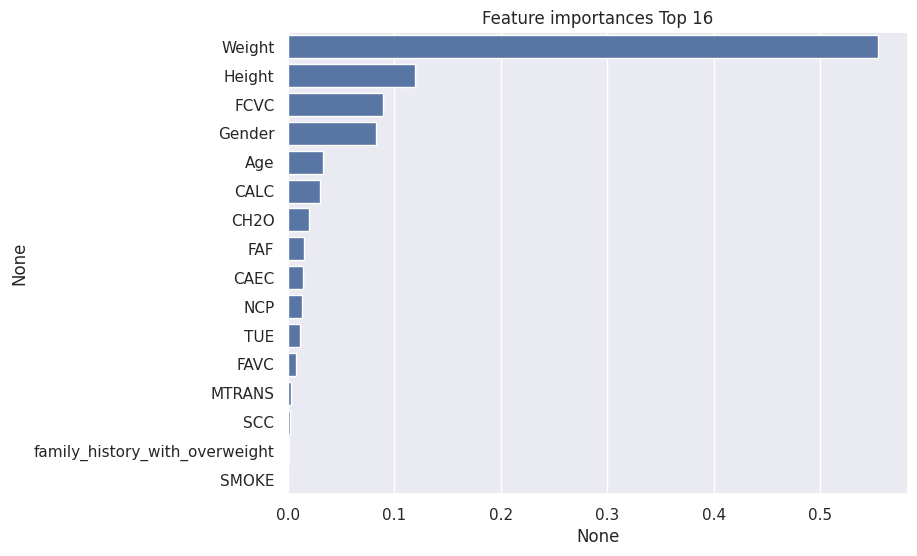

Weight                            0.554194
Height                            0.119455
FCVC                              0.089779
Gender                            0.082509
Age                               0.033375
CALC                              0.030645
CH2O                              0.020028
FAF                               0.015617
CAEC                              0.014664
NCP                               0.013762
TUE                               0.012030
FAVC                              0.007607
MTRANS                            0.003119
SCC                               0.001957
family_history_with_overweight    0.000958
SMOKE                             0.000300
dtype: float64

In [ ]:
# 모델의 특성 중요도 확인
ftr_top_gbm = plot_feature_importance(gbm_model_names[0], X_train.columns)
gbm_fi_list.append(ftr_top_gbm) # 특성중요도 리스트에 저장

ftr_top_gbm

- 특성 중요도를 확인해보니 몸무게가 중요도가 가장 높고, 그 다음으로 키, 채소 섭취 빈도, 성별, 나이, 음주 빈도, 그 다음으로 물 섭취 횟수, 신체 활동 횟수, 간식 섭취 빈도, 주식 횟수, 전자기기 사용 시간, 고칼로리 식품 자주 섭취 여부가 나왔다.
- 중요도가 낮게 나온 것은 주요 교통 수단, 칼로리 소비 모니터링 유무, 과체중 가족력, 흡연 여부이다.
- 흡연 여부는 대부분의 데이터 표본이 하지 않는다고 했기 때문에 중요도가 가장 낮게 나온 것으로 예상 된다.
- 예상외로 과체중 가족력의 특성 중요도가 낮은 것을 확인했다.

## 4-6. 표준화 후 모델 비교
- 모든 피처에 대해 표준화 후 모델 성능 비교

In [ ]:
std_scaler = StandardScaler()

# 표준화 데이터 변환
data_std_scaled = std_scaler.fit_transform(data)

In [ ]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_std_scaled,
    target,
    random_state=42, # 팀원 공동 진행
    stratify=obe_df['NObeyesdad'] # 클래스 비율만큼 분할 수행
)

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 820
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.939 0.957 0.946]
교차 검증 평균 : 0.948

훈련 세트에 대한 예측 정확도 점수 : 0.999
테스트 세트에 대한 예측 정확도 점수 : 0.948
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0505

훈련 세트에 대한 예측 f1 점수 : 0.999
테스트 세트에 대한 예측 f1 점수 : 0.948
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.051

모델의 정밀도 : 0.951
모델의 재현율 : 0.947
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 66  4  0  0]
 [ 0  0  0  0 87  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.94      0.92      0.93        72
     Obesity_Type_I(4)       0.91      0.99      0.95        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                 

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   
1  0.999343  0.948314        0.999368       0.948864        0.951324   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           820           0.01  104.995  
1     0.946885           820           0.01  110.552

- 표준화 스케일링 전 데이터와 비교했을 때 성능 차이가 없음
- 오히려 시간이 더 소요됨

## 4-7. 정규화 후 모델 비교
- 모든 피처에 대해 정규화 후 모델 성능 비교

In [ ]:
mm_scaler = MinMaxScaler()

# 정규화 데이터 변환
data_mm_scaled = mm_scaler.fit_transform(data)

In [ ]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_mm_scaled,
    target,
    random_state=42, # 팀원 공동 진행
    stratify=obe_df['NObeyesdad'] # 클래스 비율만큼 분할 수행
)

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 820
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.939 0.955 0.946]
교차 검증 평균 : 0.947

훈련 세트에 대한 예측 정확도 점수 : 0.999
테스트 세트에 대한 예측 정확도 점수 : 0.948
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0505

훈련 세트에 대한 예측 f1 점수 : 0.999
테스트 세트에 대한 예측 f1 점수 : 0.948
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.051

모델의 정밀도 : 0.951
모델의 재현율 : 0.947
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 66  4  0  0]
 [ 0  0  0  0 87  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.94      0.92      0.93        72
     Obesity_Type_I(4)       0.91      0.99      0.95        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                 

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   
1  0.999343  0.948314        0.999368       0.948864        0.951324   
2  0.999343  0.948314        0.999368       0.948864        0.951324   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           820           0.01  104.995  
1     0.946885           820           0.01  110.552  
2     0.946885           820           0.01   94.709

- 정규화 스케일링 전 데이터와 성능 차이는 없으나, 수행 시간이 단축되었다.

## 4-8. 표준화 & 정규화 후 모델 비교
- 피처 특성에 맞게 표준화와 정규화를 구분해서 처리한 후 모델 성능 비교

In [ ]:
std_feature_names = ['Age', 'Height', 'Weight']
mm_feature_names = ['CAEC', 'CALC', 'MTRANS', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
origin_feature_names = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

In [ ]:
# 표준화 데이터 변환
std_data = obe_df[std_feature_names]

std_scaler = StandardScaler()
data_std_scaled = std_scaler.fit_transform(std_data )

# 정규화 데이터 변환
mm_data = obe_df[mm_feature_names]

mm_scaler = MinMaxScaler()
data_mm_scaled = mm_scaler.fit_transform(mm_data)

In [ ]:
data_std_scaled = obe_df[std_feature_names]
data_mm_scaled = obe_df[mm_feature_names]
data_scaled = obe_df[origin_feature_names]

In [ ]:
data_scaled = pd.concat([data_std_scaled, data_mm_scaled, data_scaled], axis=1)
data_scaled

Age    Height      Weight  CAEC  CALC  MTRANS  FCVC  NCP  \
0     21.000000  1.620000   64.000000     1     0       2   2.0  3.0   
1     21.000000  1.520000   56.000000     1     1       2   3.0  3.0   
2     23.000000  1.800000   77.000000     1     2       2   2.0  3.0   
3     27.000000  1.800000   87.000000     1     2       3   3.0  3.0   
4     22.000000  1.780000   89.800000     1     1       2   2.0  1.0   
...         ...       ...         ...   ...   ...     ...   ...  ...   
2106  20.976842  1.710730  131.408528     1     1       2   3.0  3.0   
2107  21.982942  1.748584  133.742943     1     1       2   3.0  3.0   
2108  22.524036  1.752206  133.689352     1     1       2   3.0  3.0   
2109  24.361936  1.739450  133.346641     1     1       2   3.0  3.0   
2110  23.664709  1.738836  133.472641     1     1       2   3.0  3.0   

          CH2O       FAF       TUE  Gender  family_history_with_overweight  \
0     2.000000  0.000000  1.000000       0                               1   
1     3.000000  3.000000  0.000000       0                               1   
2     2.000000  2.000000  1.000000       1                               1   
3     2.000000  2.000000  0.000000       1                               0   
4     2.000000  0.000000  0.000000       1                               0   
...        ...       ...       ...     ...                             ...   
2106  1.728139  1.676269  0.906247       0                               1   
2107  2.005130  1.341390  0.599270       0                               1   
2108  2.054193  1.414209  0.646288       0                               1   
2109  2.852339  1.139107  0.586035       0                               1   
2110  2.863513  1.026452  0.714137       0                               1   

      FAVC  SMOKE  SCC  
0        0      0    0  
1        0      1    1  
2        0      0    0  
3        0      0    0  
4        0      0    0  
...    ...    ...  ...  
2106     1      0    0  
2107     1      0    0  
2108     1      0    0  
2109     1      0    0  
2110     1      0    0  

[2111 rows x 16 columns]

In [ ]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_scaled,
    target,
    random_state=42, # 팀원 공동 진행
    stratify=obe_df['NObeyesdad'] # 클래스 비율만큼 분할 수행
)

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 820
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.939 0.957 0.948]
교차 검증 평균 : 0.948

훈련 세트에 대한 예측 f1 점수 : 0.999
테스트 세트에 대한 예측 f1 점수 : 0.948
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.051

훈련 세트에 대한 예측 정확도 점수 : 0.999
테스트 세트에 대한 예측 정확도 점수 : 0.949
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.0505

모델의 정밀도 : 0.951
모델의 재현율 : 0.947
오차행렬 
 [[63  5  0  0  0  0  0]
 [ 1 70  1  0  0  0  0]
 [ 0  3 66  4  0  0  0]
 [ 0  0  2 66  4  0  0]
 [ 0  0  0  0 87  1  0]
 [ 0  0  0  0  5 69  0]
 [ 0  0  0  0  0  1 80]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.98      0.93      0.95        68
      Normal_Weight(1)       0.90      0.97      0.93        72
 Overweight_Level_I(2)       0.96      0.90      0.93        73
Overweight_Level_II(3)       0.94      0.92      0.93        72
     Obesity_Type_I(4)       0.91      0.99      0.95        88
    Obesity_Type_II(5)       0.97      0.93      0.95        74
   Obesity_Type_III(6)       1.00      0.99      0.99        81

              accuracy                 

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           820           0.01  130.671

- 데이터 스케일링 전과 성능차이가 없고, 시간이 더 소요되었다.

## 4-9. 몸무게 피처 제거 후 모델 비교

In [ ]:
no_weight_feature_names = ['Gender',
 'Age',
 'Height',
 'family_history_with_overweight',
 'FAVC',
 'FCVC',
 'NCP',
 'CAEC',
 'SMOKE',
 'CH2O',
 'SCC',
 'FAF',
 'TUE',
 'CALC',
 'MTRANS']

no_weight_data = obe_df[no_weight_feature_names]

In [ ]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    no_weight_data,
    target,
    random_state=42, # 팀원 공동 진행
    stratify=obe_df['NObeyesdad'] # 클래스 비율만큼 분할 수행
)

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 820
learning_rate = 0.01
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.823 0.737 0.791]
교차 검증 평균 : 0.784

훈련 세트에 대한 예측 f1 점수 : 0.954
테스트 세트에 대한 예측 f1 점수 : 0.84
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.115

훈련 세트에 대한 예측 정확도 점수 : 0.955
테스트 세트에 대한 예측 정확도 점수 : 0.841
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.114

모델의 정밀도 : 0.842
모델의 재현율 : 0.84
오차행렬 
 [[61  4  2  0  0  1  0]
 [ 3 57  3  2  6  0  1]
 [ 1 10 52  5  4  0  1]
 [ 0  6  4 53  6  3  0]
 [ 0  3  6  2 72  5  0]
 [ 0  1  0  2  0 70  1]
 [ 0  2  0  0  0  0 79]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.94      0.90      0.92        68
      Normal_Weight(1)       0.69      0.79      0.74        72
 Overweight_Level_I(2)       0.78      0.71      0.74        73
Overweight_Level_II(3)       0.83      0.74      0.78        72
     Obesity_Type_I(4)       0.82      0.82      0.82        88
    Obesity_Type_II(5)       0.89      0.95      0.92        74
   Obesity_Type_III(6)       0.96      0.98      0.97        81

              accuracy                    

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   
1  0.954499  0.839655        0.954517       0.840909        0.842446   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           820           0.01  130.671  
1     0.839515           820           0.01  102.966

- 성능이 떨어졌지만, 몸무게가 타겟 데이터 클래스를 나누는 기준 중 큰 영향을 미치기 때문에 제거했을 때가 오히려 신뢰성있는 모델인 것 같다.
- 파라미터 값을 조절해 좀 더 모델 성능을 높여보겠다.

In [ ]:
# 하이퍼 파라미터 지정
n_estimators = 820
learning_rate = 0.02
# gbm_params_dict['n_estimators'].append(n_estimators)
# gbm_params_dict['learning_rate'].append(learning_rate)

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# 모델 생성, 학습, 예측
gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

# 교차 검증별 F1 Score 확인 - 과적합 확인용
scores = cross_val_score(
    gbm_model,
    X_train,
    y_train,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
    )

print('교차 검증별 F1 점수 : ', np.round(scores, 3))
print('교차 검증 평균 :', np.round(np.mean(scores),3))
print()

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = n_estimators
gbm_pred_df['learning_rate'] = learning_rate

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

교차 검증별 F1 점수 :  [0.841 0.771 0.81 ]
교차 검증 평균 : 0.807

훈련 세트에 대한 예측 f1 점수 : 0.991
테스트 세트에 대한 예측 f1 점수 : 0.849
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.142

훈련 세트에 대한 예측 정확도 점수 : 0.991
테스트 세트에 대한 예측 정확도 점수 : 0.85
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.141

모델의 정밀도 : 0.851
모델의 재현율 : 0.849
오차행렬 
 [[61  4  2  0  1  0  0]
 [ 4 57  3  1  7  0  0]
 [ 2 10 53  5  3  0  0]
 [ 0  5  4 56  4  3  0]
 [ 0  2  4  4 73  5  0]
 [ 0  2  0  2  0 70  0]
 [ 0  2  0  0  0  0 79]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.91      0.90      0.90        68
      Normal_Weight(1)       0.70      0.79      0.74        72
 Overweight_Level_I(2)       0.80      0.73      0.76        73
Overweight_Level_II(3)       0.82      0.78      0.80        72
     Obesity_Type_I(4)       0.83      0.83      0.83        88
    Obesity_Type_II(5)       0.90      0.95      0.92        74
   Obesity_Type_III(6)       1.00      0.98      0.99        81

              accuracy                   

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   
1  0.954499  0.839655        0.954517       0.840909        0.842446   
2  0.991176  0.849236        0.991156       0.850379        0.851302   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           820           0.01  130.671  
1     0.839515           820           0.01  102.966  
2     0.849047           800           0.02  106.564

In [ ]:
# 그리드 서치 - 하이퍼 파라미터 지정
params = {
    "n_estimators": [300, 500, 800],
    "learning_rate": [0.02, 0.03]
}


# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# GBM 그리드서치 적용
gbm_model = GridSearchCV(
    GradientBoostingClassifier(random_state=42, verbose=2),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

print(f'최적의 하이퍼 파라미터 : {gbm_model.best_params_}')
print(f'최적 평균 정확도 : {gbm_model.best_score_:.3}')

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = gbm_model.best_params_['n_estimators']
gbm_pred_df['learning_rate'] = gbm_model.best_params_['learning_rate']

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
        44           0.8933            6.26s
        45           0.8822            6.27s
        46           0.8730            6.24s
        47           0.8629            6.21s
        48           0.8543            6.18s
        49           0.8457            6.14s
        50           0.8366            6.11s
        51           0.8276            6.08s
        52           0.8196            6.05s
        53           0.8109            6.02s
        54           0.8034            6.04s
        55           0.7966            6.03s
        56           0.7884            6.00s
        57           0.7802            5.97s
        58           0.7736            5.94s
        59           0.7660            5.93s
        60           0.7582            5.91s
        61           0.7499            5.88s
        62           0.7418            5.86s
        63           0.7349            5.92s
        64           0.7270            5.89s
        65         

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   
1  0.954499  0.839655        0.954517       0.840909        0.842446   
2  0.991176  0.849236        0.991156       0.850379        0.851302   
3  0.997480  0.849403        0.997473       0.850379        0.852842   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           820           0.01  130.671  
1     0.839515           820           0.01  102.966  
2     0.849047           800           0.02  106.564  
3     0.848209           800           0.03  323.107

In [ ]:
# 그리드 서치 - 하이퍼 파라미터 지정
params = {
    "n_estimators": [300, 500],
    "learning_rate": [0.04, 0.05]
}


# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# GBM 그리드서치 적용
gbm_model = GridSearchCV(
    GradientBoostingClassifier(random_state=42, verbose=2),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

print(f'최적의 하이퍼 파라미터 : {gbm_model.best_params_}')
print(f'최적 평균 정확도 : {gbm_model.best_score_:.3}')

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = gbm_model.best_params_['n_estimators']
gbm_pred_df['learning_rate'] = gbm_model.best_params_['learning_rate']

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
       149           0.3335            6.18s
       150           0.3321            6.15s
       151           0.3298            6.11s
       152           0.3279            6.06s
       153           0.3261            6.02s
       154           0.3241            5.98s
       155           0.3226            5.93s
       156           0.3208            5.89s
       157           0.3189            5.86s
       158           0.3169            5.82s
       159           0.3152            5.78s
       160           0.3127            5.73s
       161           0.3108            5.69s
       162           0.3088            5.66s
       163           0.3070            5.61s
       164           0.3052            5.57s
       165           0.3034            5.53s
       166           0.3014            5.50s
       167           0.3002            5.45s
       168           0.2980            5.41s
       169           0.2965            5.37s
       170         

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   
1  0.954499  0.839655        0.954517       0.840909        0.842446   
2  0.991176  0.849236        0.991156       0.850379        0.851302   
3  0.997480  0.849403        0.997473       0.850379        0.852842   
4  0.987880  0.845871        0.987997       0.846591        0.847608   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           820           0.01  130.671  
1     0.839515           820           0.01  102.966  
2     0.849047           800           0.02  106.564  
3     0.848209           800           0.03  323.107  
4     0.845269           300           0.05  157.154

In [ ]:
# 그리드 서치 - 하이퍼 파라미터 지정
params = {
    "n_estimators": [100, 200],
    "learning_rate": [0.04, 0.05, 0.06]
}


# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# GBM 그리드서치 적용
gbm_model = GridSearchCV(
    GradientBoostingClassifier(random_state=42, verbose=2),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

print(f'최적의 하이퍼 파라미터 : {gbm_model.best_params_}')
print(f'최적 평균 정확도 : {gbm_model.best_score_:.3}')

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = gbm_model.best_params_['n_estimators']
gbm_pred_df['learning_rate'] = gbm_model.best_params_['learning_rate']

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

      Iter       Train Loss   Remaining Time 
         1           1.8526            3.34s
         2           1.7775            3.37s
         3           1.7122            3.63s
         4           1.6551            3.49s
         5           1.6038            3.44s
         6           1.5578            3.74s
         7           1.5151            3.84s
         8           1.4763            3.86s
         9           1.4403            3.80s
        10           1.4069            3.70s
        11           1.3756            3.66s
        12           1.3476            3.66s
        13           1.3182            3.59s
        14           1.2900            3.51s
        15           1.2626            3.45s
        16           1.2377            3.48s
        17           1.2124            3.42s
        18           1.1872            3.36s
        19           1.1642            3.32s
        20           1.1438            3.30s
        21           1.1215            3.23s
        2

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   
1  0.954499  0.839655        0.954517       0.840909        0.842446   
2  0.991176  0.849236        0.991156       0.850379        0.851302   
3  0.997480  0.849403        0.997473       0.850379        0.852842   
4  0.987880  0.845871        0.987997       0.846591        0.847608   
5  0.980206  0.853177        0.980417       0.854167        0.855402   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           820           0.01  130.671  
1     0.839515           820           0.01  102.966  
2     0.849047           800           0.02  106.564  
3     0.848209           800           0.03  323.107  
4     0.845269           300           0.05  157.154  
5     0.852934           200           0.06   94.035

In [ ]:
# 그리드 서치 - 하이퍼 파라미터 지정
params = {
    "n_estimators": [800, 1000, 1500],
    "learning_rate": [0.01]
}


# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# GBM 그리드서치 적용
gbm_model = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

gbm_model.fit(X_train, y_train)

# 모델명 백업
gbm_model_names.append(gbm_model)

print(f'최적의 하이퍼 파라미터 : {gbm_model.best_params_}')
print(f'최적 평균 정확도 : {gbm_model.best_score_:.3}')

# 모델 예측점수 파라미터 값 데이터 프레임에 추가
gbm_pred_df =  model_pred_df(gbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
gbm_pred_df['n_estimators'] = gbm_model.best_params_['n_estimators']
gbm_pred_df['learning_rate'] = gbm_model.best_params_['learning_rate']

# 모델 정보 데이터프레임 백업
gbm_pred_df_list.append(gbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
gbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가
# gbm_time_list.append(f'{int(model_time // 60)}분 {model_time  % 60 :.1f}초')

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(gbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

최적의 하이퍼 파라미터 : {'learning_rate': 0.01, 'n_estimators': 1500}
최적 평균 정확도 : 0.802
훈련 세트에 대한 예측 f1 점수 : 0.988
테스트 세트에 대한 예측 f1 점수 : 0.843
훈련/테스트 세트에 대한 예측 f1 점수 차이 : 0.145

훈련 세트에 대한 예측 정확도 점수 : 0.988
테스트 세트에 대한 예측 정확도 점수 : 0.845
훈련/테스트 세트에 대한 예측 정확도 점수 차이 : 0.143

모델의 정밀도 : 0.845
모델의 재현율 : 0.843
오차행렬 
 [[61  4  2  0  1  0  0]
 [ 5 55  2  2  8  0  0]
 [ 2 10 52  6  3  0  0]
 [ 0  5  4 55  5  3  0]
 [ 0  2  4  3 74  5  0]
 [ 0  2  0  2  0 70  0]
 [ 0  2  0  0  0  0 79]]

                        precision    recall  f1-score   support

Insufflcient_Weight(0)       0.90      0.90      0.90        68
      Normal_Weight(1)       0.69      0.76      0.72        72
 Overweight_Level_I(2)       0.81      0.71      0.76        73
Overweight_Level_II(3)       0.81      0.76      0.79        72
     Obesity_Type_I(4)       0.81      0.84      0.83        88
    Obesity_Type_II(5)       0.90      0.95      0.92        74
   Obesity_Type_III(6)       1.00      0.98      0.99        81

              a

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999343  0.948314        0.999368       0.948864        0.951324   
1  0.954499  0.839655        0.954517       0.840909        0.842446   
2  0.991176  0.849236        0.991156       0.850379        0.851302   
3  0.997480  0.849403        0.997473       0.850379        0.852842   
4  0.987880  0.845871        0.987997       0.846591        0.847608   
5  0.980206  0.853177        0.980417       0.854167        0.855402   
6  0.987875  0.842993        0.987997       0.844697        0.845215   

   RecallSocre  n_estimators  learning_rate  Time(s)  
0     0.946885           820           0.01  130.671  
1     0.839515           820           0.01  102.966  
2     0.849047           800           0.02  106.564  
3     0.848209           800           0.03  323.107  
4     0.845269           300           0.05  157.154  
5     0.852934           200           0.06   94.035  
6     0.842761          1500           0.01  378.049

- 몸무게 피처 제외시 성능도 떨어지고 훈련/데이터 예측 점수 차이가 너무 커지기 때문에 빼지 않는게 좋을 것 같다.

## 4-10. GBM 모델링 최종 결론

- 데이터 스케일링을 진행해도 성능 차이가 없기 때문에 오리지널 데이터로 진행하는 것이 좋을 것 같다.
- 모든 모델이 정밀도와 재현율이 비슷한 수치를 보이고, 정밀도가 살짝 더 높게 나온다.
- `'n_estimators': 820`, `'learning_rate': 0.01`로 파라미터와 동일한 성능을 보이고, 시간이 살짝 단축된 `'n_estimators': 815`, `'learning_rate': 0.01`로 파라미터를 설정하는 모델을 선택하기로 결정

# 5. LGBM

In [ ]:
# LGBM 설치시
!pip install lightgbm==3.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.1.0
    Uninstalling lightgbm-4.1.0:
      Successfully uninstalled lightgbm-4.1.0


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import time
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

## 5-1. 데이터 분할

In [ ]:
from sklearn.model_selection import train_test_split

# Train - Test 분할
X_train, X_test, y_train, y_test = train_test_split(
    data_scaled,
    target,
    random_state=42, # 팀원 공동 진행
    stratify=obe_df['NObeyesdad'] # 클래스 비율만큼 분할 수행
)

# Train - Valid 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    random_state=42, # 팀원 공동 진행
    stratify=y_train # 클래스 비율만큼 분할 수행
)

In [ ]:
X_test.shape, y_test.shape, X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((528, 16), (528, 1), (1187, 16), (396, 16), (1187, 1), (396, 1))

- Train - Valid 분할할 때 `stratify=y_train`으로 넣어야하는점 주의!

In [ ]:
from lightgbm import LGBMClassifier

## 학습 및 검증에 사용될 데이터 세트 지정
eval_sets = [
    (X_train, y_train), # 훈련 세트로 검증 - 학습한 데이터에 대한 검증을 수행
    (X_valid, y_valid) # 검증 세트로 검증 - 학습하지 않은 새로운 데이터에 대한 검증을 수행
]

## 5-2. 모델 관련 백업

In [ ]:
lgbm_model_names = [] # 모델명 백업
lgbm_pred_df_list = [] # 모델 예측 성능 데이터프레임 백업
lgbm_time_list = [] # 모델별 시간
lgbm_fi_list = [] # 모델별 특성 중요도 백업

## 5-3. LGBM 파라미터 찾기


In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [50],
    "learning_rate": [0.01],
    "num_leaves": [48], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [40], # 클수록 과적합 방지
    "max_depth": [20], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')


# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.954052  0.919219        0.954507       0.920455        0.920336   

   RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0      0.91854           0.01         20  multi_logloss               40   

   n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0            50          7          48  multiclass            42        1.0   

   Time(s)  
0   11.109

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [50],
    "learning_rate": [0.01],
    "num_leaves": [100], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [40], # 클수록 과적합 방지
    "max_depth": [20], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.954052  0.919219        0.954507       0.920455        0.920336   
1  0.954052  0.919219        0.954507       0.920455        0.920336   

   RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0      0.91854           0.01         20  multi_logloss               40   
1      0.91854           0.01         20  multi_logloss               40   

   n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0            50          7          48  multiclass            42        1.0   
1            50          7         100  multiclass            42        1.0   

   Time(s)  
0   11.109  
1    9.896

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [50],
    "learning_rate": [0.01],
    "num_leaves": [50, 100, 500], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [40], # 클수록 과적합 방지
    "max_depth": [20], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.954052  0.919219        0.954507       0.920455        0.920336   
1  0.954052  0.919219        0.954507       0.920455        0.920336   
2  0.954052  0.919219        0.954507       0.920455        0.920336   

   RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0      0.91854           0.01         20  multi_logloss               40   
1      0.91854           0.01         20  multi_logloss               40   
2      0.91854           0.01         20  multi_logloss               40   

   n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0            50          7          48  multiclass            42        1.0   
1            50          7         100  multiclass            42        1.0   
2            50          7          50  multiclass            42        1.0   

   Time(s)  
0   11.109  
1    9.896  
2   19.556

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [50],
    "learning_rate": [0.01],
    "num_leaves": [40, 80, 120], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [50, 100], # 클수록 과적합 방지
    "max_depth": [50, 100, 150], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.954052  0.919219        0.954507       0.920455        0.920336   
1  0.954052  0.919219        0.954507       0.920455        0.920336   
2  0.954052  0.919219        0.954507       0.920455        0.920336   
3  0.954052  0.919219        0.954507       0.920455        0.920336   

   RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0      0.91854           0.01         20  multi_logloss               40   
1      0.91854           0.01         20  multi_logloss               40   
2      0.91854           0.01         20  multi_logloss               40   
3      0.91854           0.01         50  multi_logloss               50   

   n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0            50          7          48  multiclass            42        1.0   
1            50          7         100  multiclass            42        1.0   
2            50          7          50  multiclass            42        1.0   
3            50          7          40  multiclass            42        1.0   

   Time(s)  
0   11.109  
1    9.896  
2   19.556  
3  117.721

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [100, 500, 1000],
    "learning_rate": [0.01],
    "num_leaves": [40, 80, 120], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [50, 100], # 클수록 과적합 방지
    "max_depth": [50, 100, 150], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[41]	valid_0's multi_logloss: 0.978398	valid_1's multi_logloss: 1.03986
[42]	valid_0's multi_logloss: 0.965106	valid_1's multi_logloss: 1.02742
[43]	valid_0's multi_logloss: 0.952071	valid_1's multi_logloss: 1.01531
[44]	valid_0's multi_logloss: 0.938127	valid_1's multi_logloss: 1.00131
[45]	valid_0's multi_logloss: 0.924896	valid_1's multi_logloss: 0.988492
[46]	valid_0's multi_logloss: 0.911434	valid_1's multi_logloss: 0.975165
[47]	valid_0's multi_logloss: 0.898649	valid_1's multi_logloss: 0.962781
[48]	valid_0's multi_logloss: 0.885699	valid_1's multi_logloss: 0.95016
[49]	valid_0's multi_logloss: 0.873179	valid_1's multi_logloss: 0.937574
[50]	valid_0's multi_logloss: 0.861445	valid_1's multi_logloss: 0.926875
[51]	valid_0's multi_logloss: 0.849582	valid_1's multi_logloss: 0.915967
[52]	valid_0's multi_logloss: 0.837936	valid_1's multi_logloss: 0.905131
[53]	valid_0's multi_logloss: 0.826836	valid_1's multi_logloss: 0.894924
[54]	valid_0's multi

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.954052  0.919219        0.954507       0.920455        0.920336   
1  0.954052  0.919219        0.954507       0.920455        0.920336   
2  0.954052  0.919219        0.954507       0.920455        0.920336   
3  0.954052  0.919219        0.954507       0.920455        0.920336   
4  1.000000  0.947715        1.000000       0.948864        0.949213   

   RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0     0.918540           0.01         20  multi_logloss               40   
1     0.918540           0.01         20  multi_logloss               40   
2     0.918540           0.01         20  multi_logloss               40   
3     0.918540           0.01         50  multi_logloss               50   
4     0.946868           0.01         50  multi_logloss               50   

   n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0            50          7          48  multiclass            42        1.0   
1            50          7         100  multiclass            42        1.0   
2            50          7          50  multiclass            42        1.0   
3            50          7          40  multiclass            42        1.0   
4          1000          7          80  multiclass            42        1.0   

    Time(s)  
0    11.109  
1     9.896  
2    19.556  
3   117.721  
4  1373.674

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [500],
    "learning_rate": [0.01],
    "num_leaves": [80], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [50], # 클수록 과적합 방지
    "max_depth": [50], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.954052  0.919219        0.954507       0.920455        0.920336   
1  0.954052  0.919219        0.954507       0.920455        0.920336   
2  0.954052  0.919219        0.954507       0.920455        0.920336   
3  0.954052  0.919219        0.954507       0.920455        0.920336   
4  1.000000  0.947715        1.000000       0.948864        0.949213   
5  1.000000  0.947891        1.000000       0.948864        0.949581   

   RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0     0.918540           0.01         20  multi_logloss               40   
1     0.918540           0.01         20  multi_logloss               40   
2     0.918540           0.01         20  multi_logloss               40   
3     0.918540           0.01         50  multi_logloss               50   
4     0.946868           0.01         50  multi_logloss               50   
5     0.947004           0.01         50  multi_logloss               50   

   n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0            50          7          48  multiclass            42        1.0   
1            50          7         100  multiclass            42        1.0   
2            50          7          50  multiclass            42        1.0   
3            50          7          40  multiclass            42        1.0   
4          1000          7          80  multiclass            42        1.0   
5           500          7          80  multiclass            42        1.0   

    Time(s)  
0    11.109  
1     9.896  
2    19.556  
3   117.721  
4  1373.674  
5    55.128

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [300],
    "learning_rate": [0.01],
    "num_leaves": [80], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [50], # 클수록 과적합 방지
    "max_depth": [50], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.954052  0.919219        0.954507       0.920455        0.920336   
1  0.954052  0.919219        0.954507       0.920455        0.920336   
2  0.954052  0.919219        0.954507       0.920455        0.920336   
3  0.954052  0.919219        0.954507       0.920455        0.920336   
4  1.000000  0.947715        1.000000       0.948864        0.949213   
5  1.000000  0.947891        1.000000       0.948864        0.949581   
6  1.000000  0.941764        1.000000       0.943182        0.943465   

   RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0     0.918540           0.01         20  multi_logloss               40   
1     0.918540           0.01         20  multi_logloss               40   
2     0.918540           0.01         20  multi_logloss               40   
3     0.918540           0.01         50  multi_logloss               50   
4     0.946868           0.01         50  multi_logloss               50   
5     0.947004           0.01         50  multi_logloss               50   
6     0.940771           0.01         50  multi_logloss               50   

   n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0            50          7          48  multiclass            42        1.0   
1            50          7         100  multiclass            42        1.0   
2            50          7          50  multiclass            42        1.0   
3            50          7          40  multiclass            42        1.0   
4          1000          7          80  multiclass            42        1.0   
5           500          7          80  multiclass            42        1.0   
6           300          7          80  multiclass            42        1.0   

    Time(s)  
0    11.109  
1     9.896  
2    19.556  
3   117.721  
4  1373.674  
5    55.128  
6    49.255

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [100],
    "learning_rate": [0.01],
    "num_leaves": [80], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [50], # 클수록 과적합 방지
    "max_depth": [50], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.954052  0.919219        0.954507       0.920455        0.920336   
1  0.954052  0.919219        0.954507       0.920455        0.920336   
2  0.954052  0.919219        0.954507       0.920455        0.920336   
3  0.954052  0.919219        0.954507       0.920455        0.920336   
4  1.000000  0.947715        1.000000       0.948864        0.949213   
5  1.000000  0.947891        1.000000       0.948864        0.949581   
6  1.000000  0.941764        1.000000       0.943182        0.943465   
7  0.978279  0.931845        0.978939       0.933712        0.933298   

   RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0     0.918540           0.01         20  multi_logloss               40   
1     0.918540           0.01         20  multi_logloss               40   
2     0.918540           0.01         20  multi_logloss               40   
3     0.918540           0.01         50  multi_logloss               50   
4     0.946868           0.01         50  multi_logloss               50   
5     0.947004           0.01         50  multi_logloss               50   
6     0.940771           0.01         50  multi_logloss               50   
7     0.930905           0.01         50  multi_logloss               50   

   n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0            50          7          48  multiclass            42        1.0   
1            50          7         100  multiclass            42        1.0   
2            50          7          50  multiclass            42        1.0   
3            50          7          40  multiclass            42        1.0   
4          1000          7          80  multiclass            42        1.0   
5           500          7          80  multiclass            42        1.0   
6           300          7          80  multiclass            42        1.0   
7           100          7          80  multiclass            42        1.0   

    Time(s)  
0    11.109  
1     9.896  
2    19.556  
3   117.721  
4  1373.674  
5    55.128  
6    49.255  
7    22.245

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [100],
    "learning_rate": [0.01],
    "num_leaves": [150], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [50], # 클수록 과적합 방지
    "max_depth": [50], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.954052  0.919219        0.954507       0.920455        0.920336   
1  0.954052  0.919219        0.954507       0.920455        0.920336   
2  0.954052  0.919219        0.954507       0.920455        0.920336   
3  0.954052  0.919219        0.954507       0.920455        0.920336   
4  1.000000  0.947715        1.000000       0.948864        0.949213   
5  1.000000  0.947891        1.000000       0.948864        0.949581   
6  1.000000  0.941764        1.000000       0.943182        0.943465   
7  0.978279  0.931845        0.978939       0.933712        0.933298   
8  0.978279  0.931845        0.978939       0.933712        0.933298   

   RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0     0.918540           0.01         20  multi_logloss               40   
1     0.918540           0.01         20  multi_logloss               40   
2     0.918540           0.01         20  multi_logloss               40   
3     0.918540           0.01         50  multi_logloss               50   
4     0.946868           0.01         50  multi_logloss               50   
5     0.947004           0.01         50  multi_logloss               50   
6     0.940771           0.01         50  multi_logloss               50   
7     0.930905           0.01         50  multi_logloss               50   
8     0.930905           0.01         50  multi_logloss               50   

   n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0            50          7          48  multiclass            42        1.0   
1            50          7         100  multiclass            42        1.0   
2            50          7          50  multiclass            42        1.0   
3            50          7          40  multiclass            42        1.0   
4          1000          7          80  multiclass            42        1.0   
5           500          7          80  multiclass            42        1.0   
6           300          7          80  multiclass            42        1.0   
7           100          7          80  multiclass            42        1.0   
8           100          7         150  multiclass            42        1.0   

    Time(s)  
0    11.109  
1     9.896  
2    19.556  
3   117.721  
4  1373.674  
5    55.128  
6    49.255  
7    22.245  
8    19.771

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [100],
    "learning_rate": [0.01],
    "num_leaves": [120], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [50], # 클수록 과적합 방지
    "max_depth": [50], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.954052  0.919219        0.954507       0.920455        0.920336   
1  0.954052  0.919219        0.954507       0.920455        0.920336   
2  0.954052  0.919219        0.954507       0.920455        0.920336   
3  0.954052  0.919219        0.954507       0.920455        0.920336   
4  1.000000  0.947715        1.000000       0.948864        0.949213   
5  1.000000  0.947891        1.000000       0.948864        0.949581   
6  1.000000  0.941764        1.000000       0.943182        0.943465   
7  0.978279  0.931845        0.978939       0.933712        0.933298   
8  0.978279  0.931845        0.978939       0.933712        0.933298   
9  0.978279  0.931845        0.978939       0.933712        0.933298   

   RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0     0.918540           0.01         20  multi_logloss               40   
1     0.918540           0.01         20  multi_logloss               40   
2     0.918540           0.01         20  multi_logloss               40   
3     0.918540           0.01         50  multi_logloss               50   
4     0.946868           0.01         50  multi_logloss               50   
5     0.947004           0.01         50  multi_logloss               50   
6     0.940771           0.01         50  multi_logloss               50   
7     0.930905           0.01         50  multi_logloss               50   
8     0.930905           0.01         50  multi_logloss               50   
9     0.930905           0.01         50  multi_logloss               50   

   n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0            50          7          48  multiclass            42        1.0   
1            50          7         100  multiclass            42        1.0   
2            50          7          50  multiclass            42        1.0   
3            50          7          40  multiclass            42        1.0   
4          1000          7          80  multiclass            42        1.0   
5           500          7          80  multiclass            42        1.0   
6           300          7          80  multiclass            42        1.0   
7           100          7          80  multiclass            42        1.0   
8           100          7         150  multiclass            42        1.0   
9           100          7         120  multiclass            42        1.0   

    Time(s)  
0    11.109  
1     9.896  
2    19.556  
3   117.721  
4  1373.674  
5    55.128  
6    49.255  
7    22.245  
8    19.771  
9    16.203

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [100],
    "learning_rate": [0.01],
    "num_leaves": [200], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [50], # 클수록 과적합 방지
    "max_depth": [50], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0   0.954052  0.919219        0.954507       0.920455        0.920336   
1   0.954052  0.919219        0.954507       0.920455        0.920336   
2   0.954052  0.919219        0.954507       0.920455        0.920336   
3   0.954052  0.919219        0.954507       0.920455        0.920336   
4   1.000000  0.947715        1.000000       0.948864        0.949213   
5   1.000000  0.947891        1.000000       0.948864        0.949581   
6   1.000000  0.941764        1.000000       0.943182        0.943465   
7   0.978279  0.931845        0.978939       0.933712        0.933298   
8   0.978279  0.931845        0.978939       0.933712        0.933298   
9   0.978279  0.931845        0.978939       0.933712        0.933298   
10  0.978279  0.931845        0.978939       0.933712        0.933298   

    RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0      0.918540           0.01         20  multi_logloss               40   
1      0.918540           0.01         20  multi_logloss               40   
2      0.918540           0.01         20  multi_logloss               40   
3      0.918540           0.01         50  multi_logloss               50   
4      0.946868           0.01         50  multi_logloss               50   
5      0.947004           0.01         50  multi_logloss               50   
6      0.940771           0.01         50  multi_logloss               50   
7      0.930905           0.01         50  multi_logloss               50   
8      0.930905           0.01         50  multi_logloss               50   
9      0.930905           0.01         50  multi_logloss               50   
10     0.930905           0.01         50  multi_logloss               50   

    n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0             50          7          48  multiclass            42        1.0   
1             50          7         100  multiclass            42        1.0   
2             50          7          50  multiclass            42        1.0   
3             50          7          40  multiclass            42        1.0   
4           1000          7          80  multiclass            42        1.0   
5            500          7          80  multiclass            42        1.0   
6            300          7          80  multiclass            42        1.0   
7            100          7          80  multiclass            42        1.0   
8            100          7         150  multiclass            42        1.0   
9            100          7         120  multiclass            42        1.0   
10           100          7         200  multiclass            42        1.0   

     Time(s)  
0     11.109  
1      9.896  
2     19.556  
3    117.721  
4   1373.674  
5     55.128  
6     49.255  
7     22.245  
8     19.771  
9     16.203  
10    20.678

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [100],
    "learning_rate": [0.01],
    "num_leaves": [300], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [50], # 클수록 과적합 방지
    "max_depth": [50], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0   0.954052  0.919219        0.954507       0.920455        0.920336   
1   0.954052  0.919219        0.954507       0.920455        0.920336   
2   0.954052  0.919219        0.954507       0.920455        0.920336   
3   0.954052  0.919219        0.954507       0.920455        0.920336   
4   1.000000  0.947715        1.000000       0.948864        0.949213   
5   1.000000  0.947891        1.000000       0.948864        0.949581   
6   1.000000  0.941764        1.000000       0.943182        0.943465   
7   0.978279  0.931845        0.978939       0.933712        0.933298   
8   0.978279  0.931845        0.978939       0.933712        0.933298   
9   0.978279  0.931845        0.978939       0.933712        0.933298   
10  0.978279  0.931845        0.978939       0.933712        0.933298   
11  0.978279  0.931845        0.978939       0.933712        0.933298   

    RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0      0.918540           0.01         20  multi_logloss               40   
1      0.918540           0.01         20  multi_logloss               40   
2      0.918540           0.01         20  multi_logloss               40   
3      0.918540           0.01         50  multi_logloss               50   
4      0.946868           0.01         50  multi_logloss               50   
5      0.947004           0.01         50  multi_logloss               50   
6      0.940771           0.01         50  multi_logloss               50   
7      0.930905           0.01         50  multi_logloss               50   
8      0.930905           0.01         50  multi_logloss               50   
9      0.930905           0.01         50  multi_logloss               50   
10     0.930905           0.01         50  multi_logloss               50   
11     0.930905           0.01         50  multi_logloss               50   

    n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0             50          7          48  multiclass            42        1.0   
1             50          7         100  multiclass            42        1.0   
2             50          7          50  multiclass            42        1.0   
3             50          7          40  multiclass            42        1.0   
4           1000          7          80  multiclass            42        1.0   
5            500          7          80  multiclass            42        1.0   
6            300          7          80  multiclass            42        1.0   
7            100          7          80  multiclass            42        1.0   
8            100          7         150  multiclass            42        1.0   
9            100          7         120  multiclass            42        1.0   
10           100          7         200  multiclass            42        1.0   
11           100          7         300  multiclass            42        1.0   

     Time(s)  
0     11.109  
1      9.896  
2     19.556  
3    117.721  
4   1373.674  
5     55.128  
6     49.255  
7     22.245  
8     19.771  
9     16.203  
10    20.678  
11    30.089

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [100],
    "learning_rate": [0.01],
    "num_leaves": [1000], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [50], # 클수록 과적합 방지
    "max_depth": [50], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0   0.954052  0.919219        0.954507       0.920455        0.920336   
1   0.954052  0.919219        0.954507       0.920455        0.920336   
2   0.954052  0.919219        0.954507       0.920455        0.920336   
3   0.954052  0.919219        0.954507       0.920455        0.920336   
4   1.000000  0.947715        1.000000       0.948864        0.949213   
5   1.000000  0.947891        1.000000       0.948864        0.949581   
6   1.000000  0.941764        1.000000       0.943182        0.943465   
7   0.978279  0.931845        0.978939       0.933712        0.933298   
8   0.978279  0.931845        0.978939       0.933712        0.933298   
9   0.978279  0.931845        0.978939       0.933712        0.933298   
10  0.978279  0.931845        0.978939       0.933712        0.933298   
11  0.978279  0.931845        0.978939       0.933712        0.933298   
12  0.978279  0.931845        0.978939       0.933712        0.933298   

    RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0      0.918540           0.01         20  multi_logloss               40   
1      0.918540           0.01         20  multi_logloss               40   
2      0.918540           0.01         20  multi_logloss               40   
3      0.918540           0.01         50  multi_logloss               50   
4      0.946868           0.01         50  multi_logloss               50   
5      0.947004           0.01         50  multi_logloss               50   
6      0.940771           0.01         50  multi_logloss               50   
7      0.930905           0.01         50  multi_logloss               50   
8      0.930905           0.01         50  multi_logloss               50   
9      0.930905           0.01         50  multi_logloss               50   
10     0.930905           0.01         50  multi_logloss               50   
11     0.930905           0.01         50  multi_logloss               50   
12     0.930905           0.01         50  multi_logloss               50   

    n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0             50          7          48  multiclass            42        1.0   
1             50          7         100  multiclass            42        1.0   
2             50          7          50  multiclass            42        1.0   
3             50          7          40  multiclass            42        1.0   
4           1000          7          80  multiclass            42        1.0   
5            500          7          80  multiclass            42        1.0   
6            300          7          80  multiclass            42        1.0   
7            100          7          80  multiclass            42        1.0   
8            100          7         150  multiclass            42        1.0   
9            100          7         120  multiclass            42        1.0   
10           100          7         200  multiclass            42        1.0   
11           100          7         300  multiclass            42        1.0   
12           100          7        1000  multiclass            42        1.0   

     Time(s)  
0     11.109  
1      9.896  
2     19.556  
3    117.721  
4   1373.674  
5     55.128  
6     49.255  
7     22.245  
8     19.771  
9     16.203  
10    20.678  
11    30.089  
12    37.242

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [100],
    "learning_rate": [0.01],
    "num_leaves": [60], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [50], # 클수록 과적합 방지
    "max_depth": [50], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0   0.954052  0.919219        0.954507       0.920455        0.920336   
1   0.954052  0.919219        0.954507       0.920455        0.920336   
2   0.954052  0.919219        0.954507       0.920455        0.920336   
3   0.954052  0.919219        0.954507       0.920455        0.920336   
4   1.000000  0.947715        1.000000       0.948864        0.949213   
5   1.000000  0.947891        1.000000       0.948864        0.949581   
6   1.000000  0.941764        1.000000       0.943182        0.943465   
7   0.978279  0.931845        0.978939       0.933712        0.933298   
8   0.978279  0.931845        0.978939       0.933712        0.933298   
9   0.978279  0.931845        0.978939       0.933712        0.933298   
10  0.978279  0.931845        0.978939       0.933712        0.933298   
11  0.978279  0.931845        0.978939       0.933712        0.933298   
12  0.978279  0.931845        0.978939       0.933712        0.933298   
13  0.978279  0.931845        0.978939       0.933712        0.933298   

    RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0      0.918540           0.01         20  multi_logloss               40   
1      0.918540           0.01         20  multi_logloss               40   
2      0.918540           0.01         20  multi_logloss               40   
3      0.918540           0.01         50  multi_logloss               50   
4      0.946868           0.01         50  multi_logloss               50   
5      0.947004           0.01         50  multi_logloss               50   
6      0.940771           0.01         50  multi_logloss               50   
7      0.930905           0.01         50  multi_logloss               50   
8      0.930905           0.01         50  multi_logloss               50   
9      0.930905           0.01         50  multi_logloss               50   
10     0.930905           0.01         50  multi_logloss               50   
11     0.930905           0.01         50  multi_logloss               50   
12     0.930905           0.01         50  multi_logloss               50   
13     0.930905           0.01         50  multi_logloss               50   

    n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0             50          7          48  multiclass            42        1.0   
1             50          7         100  multiclass            42        1.0   
2             50          7          50  multiclass            42        1.0   
3             50          7          40  multiclass            42        1.0   
4           1000          7          80  multiclass            42        1.0   
5            500          7          80  multiclass            42        1.0   
6            300          7          80  multiclass            42        1.0   
7            100          7          80  multiclass            42        1.0   
8            100          7         150  multiclass            42        1.0   
9            100          7         120  multiclass            42        1.0   
10           100          7         200  multiclass            42        1.0   
11           100          7         300  multiclass            42        1.0   
12           100          7        1000  multiclass            42        1.0   
13           100          7          60  multiclass            42        1.0   

     Time(s)  
0     11.109  
1      9.896  
2     19.556  
3    117.721  
4   1373.674  
5     55.128  
6     49.255  
7     22.245  
8     19.771  
9     16.203  
10    20.678  
11    30.089  
12    37.242  
13    26.681

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [100],
    "learning_rate": [0.01],
    "num_leaves": [50], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [50], # 클수록 과적합 방지
    "max_depth": [50], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0   0.954052  0.919219        0.954507       0.920455        0.920336   
1   0.954052  0.919219        0.954507       0.920455        0.920336   
2   0.954052  0.919219        0.954507       0.920455        0.920336   
3   0.954052  0.919219        0.954507       0.920455        0.920336   
4   1.000000  0.947715        1.000000       0.948864        0.949213   
5   1.000000  0.947891        1.000000       0.948864        0.949581   
6   1.000000  0.941764        1.000000       0.943182        0.943465   
7   0.978279  0.931845        0.978939       0.933712        0.933298   
8   0.978279  0.931845        0.978939       0.933712        0.933298   
9   0.978279  0.931845        0.978939       0.933712        0.933298   
10  0.978279  0.931845        0.978939       0.933712        0.933298   
11  0.978279  0.931845        0.978939       0.933712        0.933298   
12  0.978279  0.931845        0.978939       0.933712        0.933298   
13  0.978279  0.931845        0.978939       0.933712        0.933298   
14  0.978279  0.931845        0.978939       0.933712        0.933298   

    RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0      0.918540           0.01         20  multi_logloss               40   
1      0.918540           0.01         20  multi_logloss               40   
2      0.918540           0.01         20  multi_logloss               40   
3      0.918540           0.01         50  multi_logloss               50   
4      0.946868           0.01         50  multi_logloss               50   
5      0.947004           0.01         50  multi_logloss               50   
6      0.940771           0.01         50  multi_logloss               50   
7      0.930905           0.01         50  multi_logloss               50   
8      0.930905           0.01         50  multi_logloss               50   
9      0.930905           0.01         50  multi_logloss               50   
10     0.930905           0.01         50  multi_logloss               50   
11     0.930905           0.01         50  multi_logloss               50   
12     0.930905           0.01         50  multi_logloss               50   
13     0.930905           0.01         50  multi_logloss               50   
14     0.930905           0.01         50  multi_logloss               50   

    n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0             50          7          48  multiclass            42        1.0   
1             50          7         100  multiclass            42        1.0   
2             50          7          50  multiclass            42        1.0   
3             50          7          40  multiclass            42        1.0   
4           1000          7          80  multiclass            42        1.0   
5            500          7          80  multiclass            42        1.0   
6            300          7          80  multiclass            42        1.0   
7            100          7          80  multiclass            42        1.0   
8            100          7         150  multiclass            42        1.0   
9            100          7         120  multiclass            42        1.0   
10           100          7         200  multiclass            42        1.0   
11           100          7         300  multiclass            42        1.0   
12           100          7        1000  multiclass            42        1.0   
13           100          7          60  multiclass            42        1.0   
14           100          7          50  multiclass            42        1.0   

     Time(s)  
0     11.109  
1      9.896  
2     19.556  
3    117.721  
4   1373.674  
5     55.128  
6     49.255  
7     22.245  
8     19.771  
9     16.203  
10    20.678  
11    30.089  
12    37.242  
13    26.681  
14    23.397

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [100],
    "learning_rate": [0.01],
    "num_leaves": [40], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [50], # 클수록 과적합 방지
    "max_depth": [50], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0   0.954052  0.919219        0.954507       0.920455        0.920336   
1   0.954052  0.919219        0.954507       0.920455        0.920336   
2   0.954052  0.919219        0.954507       0.920455        0.920336   
3   0.954052  0.919219        0.954507       0.920455        0.920336   
4   1.000000  0.947715        1.000000       0.948864        0.949213   
5   1.000000  0.947891        1.000000       0.948864        0.949581   
6   1.000000  0.941764        1.000000       0.943182        0.943465   
7   0.978279  0.931845        0.978939       0.933712        0.933298   
8   0.978279  0.931845        0.978939       0.933712        0.933298   
9   0.978279  0.931845        0.978939       0.933712        0.933298   
10  0.978279  0.931845        0.978939       0.933712        0.933298   
11  0.978279  0.931845        0.978939       0.933712        0.933298   
12  0.978279  0.931845        0.978939       0.933712        0.933298   
13  0.978279  0.931845        0.978939       0.933712        0.933298   
14  0.978279  0.931845        0.978939       0.933712        0.933298   
15  0.978279  0.931845        0.978939       0.933712        0.933298   

    RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0      0.918540           0.01         20  multi_logloss               40   
1      0.918540           0.01         20  multi_logloss               40   
2      0.918540           0.01         20  multi_logloss               40   
3      0.918540           0.01         50  multi_logloss               50   
4      0.946868           0.01         50  multi_logloss               50   
5      0.947004           0.01         50  multi_logloss               50   
6      0.940771           0.01         50  multi_logloss               50   
7      0.930905           0.01         50  multi_logloss               50   
8      0.930905           0.01         50  multi_logloss               50   
9      0.930905           0.01         50  multi_logloss               50   
10     0.930905           0.01         50  multi_logloss               50   
11     0.930905           0.01         50  multi_logloss               50   
12     0.930905           0.01         50  multi_logloss               50   
13     0.930905           0.01         50  multi_logloss               50   
14     0.930905           0.01         50  multi_logloss               50   
15     0.930905           0.01         50  multi_logloss               50   

    n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0             50          7          48  multiclass            42        1.0   
1             50          7         100  multiclass            42        1.0   
2             50          7          50  multiclass            42        1.0   
3             50          7          40  multiclass            42        1.0   
4           1000          7          80  multiclass            42        1.0   
5            500          7          80  multiclass            42        1.0   
6            300          7          80  multiclass            42        1.0   
7            100          7          80  multiclass            42        1.0   
8            100          7         150  multiclass            42        1.0   
9            100          7         120  multiclass            42        1.0   
10           100          7         200  multiclass            42        1.0   
11           100          7         300  multiclass            42        1.0   
12           100          7        1000  multiclass            42        1.0   
13           100          7          60  multiclass            42        1.0   
14           100          7          50  multiclass            42        1.0   
15           100          7          40  multiclass            42        1.0   

     Time(s)  
0     11.109  
1      9.896  
2     19.556  
3    117.721  
4   1373.674  
5

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [100],
    "learning_rate": [0.01],
    "num_leaves": [30], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [50], # 클수록 과적합 방지
    "max_depth": [50], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0   0.954052  0.919219        0.954507       0.920455        0.920336   
1   0.954052  0.919219        0.954507       0.920455        0.920336   
2   0.954052  0.919219        0.954507       0.920455        0.920336   
3   0.954052  0.919219        0.954507       0.920455        0.920336   
4   1.000000  0.947715        1.000000       0.948864        0.949213   
5   1.000000  0.947891        1.000000       0.948864        0.949581   
6   1.000000  0.941764        1.000000       0.943182        0.943465   
7   0.978279  0.931845        0.978939       0.933712        0.933298   
8   0.978279  0.931845        0.978939       0.933712        0.933298   
9   0.978279  0.931845        0.978939       0.933712        0.933298   
10  0.978279  0.931845        0.978939       0.933712        0.933298   
11  0.978279  0.931845        0.978939       0.933712        0.933298   
12  0.978279  0.931845        0.978939       0.933712        0.933298   
13  0.978279  0.931845        0.978939       0.933712        0.933298   
14  0.978279  0.931845        0.978939       0.933712        0.933298   
15  0.978279  0.931845        0.978939       0.933712        0.933298   
16  0.976521  0.935841        0.977254       0.937500        0.937423   

    RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0      0.918540           0.01         20  multi_logloss               40   
1      0.918540           0.01         20  multi_logloss               40   
2      0.918540           0.01         20  multi_logloss               40   
3      0.918540           0.01         50  multi_logloss               50   
4      0.946868           0.01         50  multi_logloss               50   
5      0.947004           0.01         50  multi_logloss               50   
6      0.940771           0.01         50  multi_logloss               50   
7      0.930905           0.01         50  multi_logloss               50   
8      0.930905           0.01         50  multi_logloss               50   
9      0.930905           0.01         50  multi_logloss               50   
10     0.930905           0.01         50  multi_logloss               50   
11     0.930905           0.01         50  multi_logloss               50   
12     0.930905           0.01         50  multi_logloss               50   
13     0.930905           0.01         50  multi_logloss               50   
14     0.930905           0.01         50  multi_logloss               50   
15     0.930905           0.01         50  multi_logloss               50   
16     0.934873           0.01         50  multi_logloss               50   

    n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0             50          7          48  multiclass            42        1.0   
1             50          7         100  multiclass            42        1.0   
2             50          7          50  multiclass            42        1.0   
3             50          7          40  multiclass            42        1.0   
4           1000          7          80  multiclass            42        1.0   
5            500          7          80  multiclass            42        1.0   
6            300          7          80  multiclass            42        1.0   
7            100          7          80  multiclass            42        1.0   
8            100          7         150  multiclass            42        1.0   
9            100          7         120  multiclass            42        1.0   
10           100          7         200  multiclass            42        1.0   
11           100          7         300  multiclass            42        1.0   
12           100          7        1000  multiclass            42        1.0   
13           100          7          60  multiclass            42        1.0   
14           100          7          50  multiclass            42        1.0   
15           100      

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [100],
    "learning_rate": [0.01],
    "num_leaves": [35], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [50], # 클수록 과적합 방지
    "max_depth": [50], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0   0.954052  0.919219        0.954507       0.920455        0.920336   
1   0.954052  0.919219        0.954507       0.920455        0.920336   
2   0.954052  0.919219        0.954507       0.920455        0.920336   
3   0.954052  0.919219        0.954507       0.920455        0.920336   
4   1.000000  0.947715        1.000000       0.948864        0.949213   
5   1.000000  0.947891        1.000000       0.948864        0.949581   
6   1.000000  0.941764        1.000000       0.943182        0.943465   
7   0.978279  0.931845        0.978939       0.933712        0.933298   
8   0.978279  0.931845        0.978939       0.933712        0.933298   
9   0.978279  0.931845        0.978939       0.933712        0.933298   
10  0.978279  0.931845        0.978939       0.933712        0.933298   
11  0.978279  0.931845        0.978939       0.933712        0.933298   
12  0.978279  0.931845        0.978939       0.933712        0.933298   
13  0.978279  0.931845        0.978939       0.933712        0.933298   
14  0.978279  0.931845        0.978939       0.933712        0.933298   
15  0.978279  0.931845        0.978939       0.933712        0.933298   
16  0.976521  0.935841        0.977254       0.937500        0.937423   
17  0.978277  0.931845        0.978939       0.933712        0.933298   

    RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0      0.918540           0.01         20  multi_logloss               40   
1      0.918540           0.01         20  multi_logloss               40   
2      0.918540           0.01         20  multi_logloss               40   
3      0.918540           0.01         50  multi_logloss               50   
4      0.946868           0.01         50  multi_logloss               50   
5      0.947004           0.01         50  multi_logloss               50   
6      0.940771           0.01         50  multi_logloss               50   
7      0.930905           0.01         50  multi_logloss               50   
8      0.930905           0.01         50  multi_logloss               50   
9      0.930905           0.01         50  multi_logloss               50   
10     0.930905           0.01         50  multi_logloss               50   
11     0.930905           0.01         50  multi_logloss               50   
12     0.930905           0.01         50  multi_logloss               50   
13     0.930905           0.01         50  multi_logloss               50   
14     0.930905           0.01         50  multi_logloss               50   
15     0.930905           0.01         50  multi_logloss               50   
16     0.934873           0.01         50  multi_logloss               50   
17     0.930905           0.01         50  multi_logloss               50   

    n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0             50          7          48  multiclass            42        1.0   
1             50          7         100  multiclass            42        1.0   
2             50          7          50  multiclass            42        1.0   
3             50          7          40  multiclass            42        1.0   
4           1000          7          80  multiclass            42        1.0   
5            500          7          80  multiclass            42        1.0   
6            300          7          80  multiclass            42        1.0   
7            100          7          80  multiclass            42        1.0   
8            100          7         150  multiclass            42        1.0   
9            100          7         120  multiclass            42        1.0   
10           100          7         200  multiclass            42        1.0   
11           100          7         300  multiclass            42        1.0   
12           100          7        1000  multiclass            42        1.0   
13           100          7     

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [100],
    "learning_rate": [0.01],
    "num_leaves": [38], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [50], # 클수록 과적합 방지
    "max_depth": [50], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0   0.954052  0.919219        0.954507       0.920455        0.920336   
1   0.954052  0.919219        0.954507       0.920455        0.920336   
2   0.954052  0.919219        0.954507       0.920455        0.920336   
3   0.954052  0.919219        0.954507       0.920455        0.920336   
4   1.000000  0.947715        1.000000       0.948864        0.949213   
5   1.000000  0.947891        1.000000       0.948864        0.949581   
6   1.000000  0.941764        1.000000       0.943182        0.943465   
7   0.978279  0.931845        0.978939       0.933712        0.933298   
8   0.978279  0.931845        0.978939       0.933712        0.933298   
9   0.978279  0.931845        0.978939       0.933712        0.933298   
10  0.978279  0.931845        0.978939       0.933712        0.933298   
11  0.978279  0.931845        0.978939       0.933712        0.933298   
12  0.978279  0.931845        0.978939       0.933712        0.933298   
13  0.978279  0.931845        0.978939       0.933712        0.933298   
14  0.978279  0.931845        0.978939       0.933712        0.933298   
15  0.978279  0.931845        0.978939       0.933712        0.933298   
16  0.976521  0.935841        0.977254       0.937500        0.937423   
17  0.978277  0.931845        0.978939       0.933712        0.933298   
18  0.978277  0.931845        0.978939       0.933712        0.933298   

    RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0      0.918540           0.01         20  multi_logloss               40   
1      0.918540           0.01         20  multi_logloss               40   
2      0.918540           0.01         20  multi_logloss               40   
3      0.918540           0.01         50  multi_logloss               50   
4      0.946868           0.01         50  multi_logloss               50   
5      0.947004           0.01         50  multi_logloss               50   
6      0.940771           0.01         50  multi_logloss               50   
7      0.930905           0.01         50  multi_logloss               50   
8      0.930905           0.01         50  multi_logloss               50   
9      0.930905           0.01         50  multi_logloss               50   
10     0.930905           0.01         50  multi_logloss               50   
11     0.930905           0.01         50  multi_logloss               50   
12     0.930905           0.01         50  multi_logloss               50   
13     0.930905           0.01         50  multi_logloss               50   
14     0.930905           0.01         50  multi_logloss               50   
15     0.930905           0.01         50  multi_logloss               50   
16     0.934873           0.01         50  multi_logloss               50   
17     0.930905           0.01         50  multi_logloss               50   
18     0.930905           0.01         50  multi_logloss               50   

    n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0             50          7          48  multiclass            42        1.0   
1             50          7         100  multiclass            42        1.0   
2             50          7          50  multiclass            42        1.0   
3             50          7          40  multiclass            42        1.0   
4           1000          7          80  multiclass            42        1.0   
5            500          7          80  multiclass            42        1.0   
6            300          7          80  multiclass            42        1.0   
7            100          7          80  multiclass            42        1.0   
8            100          7         150  multiclass            42        1.0   
9            100          7         120  multiclass            42        1.0   
10           100          7         200  multiclass            42        1.0   
11           100          7         300  m

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [100],
    "learning_rate": [0.01],
    "num_leaves": [39], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [50], # 클수록 과적합 방지
    "max_depth": [50], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0   0.954052  0.919219        0.954507       0.920455        0.920336   
1   0.954052  0.919219        0.954507       0.920455        0.920336   
2   0.954052  0.919219        0.954507       0.920455        0.920336   
3   0.954052  0.919219        0.954507       0.920455        0.920336   
4   1.000000  0.947715        1.000000       0.948864        0.949213   
5   1.000000  0.947891        1.000000       0.948864        0.949581   
6   1.000000  0.941764        1.000000       0.943182        0.943465   
7   0.978279  0.931845        0.978939       0.933712        0.933298   
8   0.978279  0.931845        0.978939       0.933712        0.933298   
9   0.978279  0.931845        0.978939       0.933712        0.933298   
10  0.978279  0.931845        0.978939       0.933712        0.933298   
11  0.978279  0.931845        0.978939       0.933712        0.933298   
12  0.978279  0.931845        0.978939       0.933712        0.933298   
13  0.978279  0.931845        0.978939       0.933712        0.933298   
14  0.978279  0.931845        0.978939       0.933712        0.933298   
15  0.978279  0.931845        0.978939       0.933712        0.933298   
16  0.976521  0.935841        0.977254       0.937500        0.937423   
17  0.978277  0.931845        0.978939       0.933712        0.933298   
18  0.978277  0.931845        0.978939       0.933712        0.933298   
19  0.978277  0.931845        0.978939       0.933712        0.933298   

    RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0      0.918540           0.01         20  multi_logloss               40   
1      0.918540           0.01         20  multi_logloss               40   
2      0.918540           0.01         20  multi_logloss               40   
3      0.918540           0.01         50  multi_logloss               50   
4      0.946868           0.01         50  multi_logloss               50   
5      0.947004           0.01         50  multi_logloss               50   
6      0.940771           0.01         50  multi_logloss               50   
7      0.930905           0.01         50  multi_logloss               50   
8      0.930905           0.01         50  multi_logloss               50   
9      0.930905           0.01         50  multi_logloss               50   
10     0.930905           0.01         50  multi_logloss               50   
11     0.930905           0.01         50  multi_logloss               50   
12     0.930905           0.01         50  multi_logloss               50   
13     0.930905           0.01         50  multi_logloss               50   
14     0.930905           0.01         50  multi_logloss               50   
15     0.930905           0.01         50  multi_logloss               50   
16     0.934873           0.01         50  multi_logloss               50   
17     0.930905           0.01         50  multi_logloss               50   
18     0.930905           0.01         50  multi_logloss               50   
19     0.930905           0.01         50  multi_logloss               50   

    n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0             50          7          48  multiclass            42        1.0   
1             50          7         100  multiclass            42        1.0   
2             50          7          50  multiclass            42        1.0   
3             50          7          40  multiclass            42        1.0   
4           1000          7          80  multiclass            42        1.0   
5            500          7          80  multiclass            42        1.0   
6            300          7          80  multiclass            42        1.0   
7            100          7          80  multiclass            42        1.0   
8            100          7         150  multiclass            42        1.0   
9            100          7         120  multiclass 

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [100],
    "learning_rate": [0.01],
    "num_leaves": [40], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [10], # 클수록 과적합 방지
    "max_depth": [100], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0   0.954052  0.919219        0.954507       0.920455        0.920336   
1   0.954052  0.919219        0.954507       0.920455        0.920336   
2   0.954052  0.919219        0.954507       0.920455        0.920336   
3   0.954052  0.919219        0.954507       0.920455        0.920336   
4   1.000000  0.947715        1.000000       0.948864        0.949213   
5   1.000000  0.947891        1.000000       0.948864        0.949581   
6   1.000000  0.941764        1.000000       0.943182        0.943465   
7   0.978279  0.931845        0.978939       0.933712        0.933298   
8   0.978279  0.931845        0.978939       0.933712        0.933298   
9   0.978279  0.931845        0.978939       0.933712        0.933298   
10  0.978279  0.931845        0.978939       0.933712        0.933298   
11  0.978279  0.931845        0.978939       0.933712        0.933298   
12  0.978279  0.931845        0.978939       0.933712        0.933298   
13  0.978279  0.931845        0.978939       0.933712        0.933298   
14  0.978279  0.931845        0.978939       0.933712        0.933298   
15  0.978279  0.931845        0.978939       0.933712        0.933298   
16  0.976521  0.935841        0.977254       0.937500        0.937423   
17  0.978277  0.931845        0.978939       0.933712        0.933298   
18  0.978277  0.931845        0.978939       0.933712        0.933298   
19  0.978277  0.931845        0.978939       0.933712        0.933298   
20  0.978279  0.931845        0.978939       0.933712        0.933298   

    RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0      0.918540           0.01         20  multi_logloss               40   
1      0.918540           0.01         20  multi_logloss               40   
2      0.918540           0.01         20  multi_logloss               40   
3      0.918540           0.01         50  multi_logloss               50   
4      0.946868           0.01         50  multi_logloss               50   
5      0.947004           0.01         50  multi_logloss               50   
6      0.940771           0.01         50  multi_logloss               50   
7      0.930905           0.01         50  multi_logloss               50   
8      0.930905           0.01         50  multi_logloss               50   
9      0.930905           0.01         50  multi_logloss               50   
10     0.930905           0.01         50  multi_logloss               50   
11     0.930905           0.01         50  multi_logloss               50   
12     0.930905           0.01         50  multi_logloss               50   
13     0.930905           0.01         50  multi_logloss               50   
14     0.930905           0.01         50  multi_logloss               50   
15     0.930905           0.01         50  multi_logloss               50   
16     0.934873           0.01         50  multi_logloss               50   
17     0.930905           0.01         50  multi_logloss               50   
18     0.930905           0.01         50  multi_logloss               50   
19     0.930905           0.01         50  multi_logloss               50   
20     0.930905           0.01        100  multi_logloss               10   

    n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0             50          7          48  multiclass            42        1.0   
1             50          7         100  multiclass            42        1.0   
2             50          7          50  multiclass            42        1.0   
3             50          7          40  multiclass            42        1.0   
4           1000          7          80  multiclass            42        1.0   
5            500          7          80  multiclass            42        1.0   
6            300          7          80  multiclass            42        1.0   
7            100          7          80  multiclass           

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [200],
    "learning_rate": [0.01],
    "num_leaves": [40], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [10], # 클수록 과적합 방지
    "max_depth": [100], # 과적합시 줄이기
    "objective":['multiclass'], # 다중분류 어플리케이션 지정
    "metric": ['multi_logloss'], # 다중분류으로 성능 평가하도록 지정 손실값 지정
    "num_class": [7], # 클래스 개수 지정
    "subsample": [1.0], # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
    "random_state": [42]
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[1]	valid_0's multi_logloss: 1.89955	valid_1's multi_logloss: 1.90153
[2]	valid_0's multi_logloss: 1.85833	valid_1's multi_logloss: 1.86232
[3]	valid_0's multi_logloss: 1.81876	valid_1's multi_logloss: 1.82447
[4]	valid_0's multi_logloss: 1.78096	valid_1's multi_logloss: 1.78858
[5]	valid_0's multi_logloss: 1.74465	valid_1's multi_logloss: 1.75383
[6]	valid_0's multi_logloss: 1.70963	valid_1's multi_logloss: 1.72042
[7]	valid_0's multi_logloss: 1.67609	valid_1's multi_logloss: 1.68796
[8]	valid_0's multi_logloss: 1.64405	valid_1's multi_logloss: 1.65765
[9]	valid_0's multi_logloss: 1.61307	valid_1's multi_logloss: 1.62843
[10]	valid_0's multi_logloss: 1.58322	valid_1's multi_logloss: 1.60037
[11]	valid_0's multi_logloss: 1.55469	valid_1's multi_logloss: 1.57312
[12]	valid_0's multi_logloss: 1.5272	valid_1's multi_logloss: 1.54715
[13]	valid_0's multi_logloss: 1.50035	valid_1's multi_logloss: 1.52139
[14]	valid_0's multi_logloss: 1

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0   0.954052  0.919219        0.954507       0.920455        0.920336   
1   0.954052  0.919219        0.954507       0.920455        0.920336   
2   0.954052  0.919219        0.954507       0.920455        0.920336   
3   0.954052  0.919219        0.954507       0.920455        0.920336   
4   1.000000  0.947715        1.000000       0.948864        0.949213   
5   1.000000  0.947891        1.000000       0.948864        0.949581   
6   1.000000  0.941764        1.000000       0.943182        0.943465   
7   0.978279  0.931845        0.978939       0.933712        0.933298   
8   0.978279  0.931845        0.978939       0.933712        0.933298   
9   0.978279  0.931845        0.978939       0.933712        0.933298   
10  0.978279  0.931845        0.978939       0.933712        0.933298   
11  0.978279  0.931845        0.978939       0.933712        0.933298   
12  0.978279  0.931845        0.978939       0.933712        0.933298   
13  0.978279  0.931845        0.978939       0.933712        0.933298   
14  0.978279  0.931845        0.978939       0.933712        0.933298   
15  0.978279  0.931845        0.978939       0.933712        0.933298   
16  0.976521  0.935841        0.977254       0.937500        0.937423   
17  0.978277  0.931845        0.978939       0.933712        0.933298   
18  0.978277  0.931845        0.978939       0.933712        0.933298   
19  0.978277  0.931845        0.978939       0.933712        0.933298   
20  0.978279  0.931845        0.978939       0.933712        0.933298   
21  0.999121  0.939852        0.999158       0.941288        0.941504   

    RecallSocre  learning_rate  max_depth         metric  min_data_in_lea  \
0      0.918540           0.01         20  multi_logloss               40   
1      0.918540           0.01         20  multi_logloss               40   
2      0.918540           0.01         20  multi_logloss               40   
3      0.918540           0.01         50  multi_logloss               50   
4      0.946868           0.01         50  multi_logloss               50   
5      0.947004           0.01         50  multi_logloss               50   
6      0.940771           0.01         50  multi_logloss               50   
7      0.930905           0.01         50  multi_logloss               50   
8      0.930905           0.01         50  multi_logloss               50   
9      0.930905           0.01         50  multi_logloss               50   
10     0.930905           0.01         50  multi_logloss               50   
11     0.930905           0.01         50  multi_logloss               50   
12     0.930905           0.01         50  multi_logloss               50   
13     0.930905           0.01         50  multi_logloss               50   
14     0.930905           0.01         50  multi_logloss               50   
15     0.930905           0.01         50  multi_logloss               50   
16     0.934873           0.01         50  multi_logloss               50   
17     0.930905           0.01         50  multi_logloss               50   
18     0.930905           0.01         50  multi_logloss               50   
19     0.930905           0.01         50  multi_logloss               50   
20     0.930905           0.01        100  multi_logloss               10   
21     0.938814           0.01        100  multi_logloss               10   

    n_estimators  num_class  num_leaves   objective  random_state  subsample  \
0             50          7          48  multiclass            42        1.0   
1             50          7         100  multiclass            42        1.0   
2             50          7          50  multiclass            42        1.0   
3             50          7          40  multiclass            42        1.0   
4           1000          7          80  multiclass            42        1.0   
5            500          7          80  multiclass            42       

## 5-4. LGBM 스케일링 후 확인

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [200],
    "learning_rate": [0.01],
    "num_leaves": [40], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [10], # 클수록 과적합 방지
    "max_depth": [100], # 과적합시 줄이기
    "subsample": [1.0] # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(early_stopping_round=50, random_state=42, objective='multiclass', metric='multi_logloss', num_class=7, error_score='raise'),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1778
[LightGBM] [Info] Number of data points in the train set: 791, number of used features: 15
[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Info] Start training from score -2.048325
[LightGBM] [Info] Start training from score -1.991167
[LightGBM] [Info] Start training from score -1.991167
[LightGBM] [Info] Start training from score -1.981950
[

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999121  0.939852        0.999158       0.941288        0.941504   

   RecallSocre  learning_rate  max_depth  min_data_in_lea  n_estimators  \
0     0.938814           0.01        100               10           200   

   num_leaves  subsample  Time(s)  
0          40        1.0   11.049

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [200],
    "learning_rate": [0.01],
    "num_leaves": [40], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [10], # 클수록 과적합 방지
    "max_depth": [10], # 과적합시 줄이기
    "subsample": [1.0] # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(early_stopping_round=50, random_state=42, objective='multiclass', metric='multi_logloss', num_class=7, error_score='raise'),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1778
[LightGBM] [Info] Number of data points in the train set: 791, number of used features: 15
[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Info] Start training from score -2.048325
[LightGBM] [Info] Start training from score -1.991167
[LightGBM] [Info] Start training from score -1.991167
[LightGBM] [Info] Start training from score -1.981950
[

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999121  0.939852        0.999158       0.941288        0.941504   
1  0.999121  0.937865        0.999158       0.939394        0.939518   

   RecallSocre  learning_rate  max_depth  min_data_in_lea  n_estimators  \
0     0.938814           0.01        100               10           200   
1     0.936830           0.01         10               10           200   

   num_leaves  subsample  Time(s)  
0          40        1.0   11.049  
1          40        1.0   11.085

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [200],
    "learning_rate": [0.01],
    "num_leaves": [40], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [10], # 클수록 과적합 방지
    "max_depth": [20], # 과적합시 줄이기
    "subsample": [1.0] # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(early_stopping_round=30, random_state=42, objective='multiclass', metric='multi_logloss', num_class=7, error_score='raise'),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1778
[LightGBM] [Info] Number of data points in the train set: 791, number of used features: 15
[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Warning] Unknown parameter: min_data_in_lea
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Info] Start training from score -2.048325
[LightGBM] [Info] Start training from score -1.991167
[LightGBM] [Info] Start training from score -1.991167
[LightGBM] [Info] Start training from score -1.981950
[

Exception ignored on calling ctypes callback function: <function _log_callback at 0x79c6ca7d92d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 205, in _log_callback
    _log_native(str(msg.decode('utf-8')))
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 183, in wrapper
    return func(msg)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 200, in _log_native
    getattr(_LOGGER, _INFO_METHOD_NAME)(msg)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 133, in info
    print(msg)  # noqa: T201
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/iostream.py", line 402, in write
    self.pub_thread.schedule(lambda : self._buffer.write(string))
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/iostream.py", line 203, in schedule
    self._event_pipe.send(b'')
  File "/usr/local/lib/python3.10/dist-packages/zmq/sugar/socket.py", line 618, in se


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999121  0.939852        0.999158       0.941288        0.941504   
1  0.999121  0.937865        0.999158       0.939394        0.939518   
2  0.999121  0.939852        0.999158       0.941288        0.941504   

   RecallSocre  learning_rate  max_depth  min_data_in_lea  n_estimators  \
0     0.938814           0.01        100               10           200   
1     0.936830           0.01         10               10           200   
2     0.938814           0.01         20               10           200   

   num_leaves  subsample  Time(s)  
0          40        1.0   11.049  
1          40        1.0   11.085  
2          40        1.0    9.159

In [ ]:
# 하이퍼 파라미터 지정
params = {
    "n_estimators": [300],
    "learning_rate": [0.01],
    "num_leaves": [40], # 많을 수록 정확도가 높아지지만 과적합 발생 우려
    "min_data_in_lea": [10], # 클수록 과적합 방지
    "max_depth": [20], # 과적합시 줄이기
    "subsample": [1.0] # 과적합 막기 위해 subsample 지정(1 : 전체 데이터 사용)
}

# 모델 학습 및 예측 시간 계산 시작
start_time = time.time()

# LGBM 그리드서치 적용
lgbm_model = GridSearchCV(
    LGBMClassifier(early_stopping_round=30, random_state=42, objective='multiclass', metric='multi_logloss', num_class=7, error_score='raise'),
    param_grid=params,
    scoring='f1_macro', # 다중 분류에서는 Accuracy보다 F1 score 사용하는 편이 좋음 : macro-averaged 사용
    cv=3
)

# 모델 학습
lgbm_model.fit(
        X_train,
        y_train,
        eval_set=eval_sets,
        eval_metric='multi_logloss', # 다중분류 손실값으로 성능 평가하도록 지정
        )

print(f'최적의 하이퍼 파라미터 : {lgbm_model.best_params_}')
print(f'최적 평균 정확도 : {lgbm_model.best_score_:.3}')

# 모델명 백업
lgbm_model_names.append(lgbm_model)

# 모델 예측 - 예측 점수 파라미터 값 데이터 프레임에 추가
lgbm_pred_df = model_pred_df(lgbm_model)

# 모델 파라미터 값 데이터 프레임에 추가
for key, value in list(lgbm_model.best_params_.items()):
  lgbm_pred_df[key] = value

# 모델 정보 데이터프레임 백업
lgbm_pred_df_list.append(lgbm_pred_df)

# 모델 학습 및 예측 시간 계산, dict에 모델별 수행시간 저장
model_time = time.time() - start_time
lgbm_pred_df['Time(s)'] = np.round(model_time, 3) # 모델 수행시간 데이터프레임에 추가

print(f'수행시간 : {int(model_time // 60)}분 {model_time  % 60 :.1f}초')

df_concat = pd.concat(lgbm_pred_df_list, axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

F1_Train   F1_Test  Accuracy_Train  Accuracy_Test  PrecisionSocre  \
0  0.999121  0.939852        0.999158       0.941288        0.941504   
1  0.999121  0.937865        0.999158       0.939394        0.939518   
2  0.999121  0.939852        0.999158       0.941288        0.941504   
3  1.000000  0.943786        1.000000       0.945076        0.945643   

   RecallSocre  learning_rate  max_depth  min_data_in_lea  n_estimators  \
0     0.938814           0.01        100               10           200   
1     0.936830           0.01         10               10           200   
2     0.938814           0.01         20               10           200   
3     0.942728           0.01         20               10           300   

   num_leaves  subsample  Time(s)  
0          40        1.0   11.049  
1          40        1.0   11.085  
2          40        1.0    9.159  
3          40        1.0   16.686

## 5-5. LGBM 모델링 1차 결론

- 여러 파라미터 값을 조정해보았지만, 과적합이 나오지 않는 파라미터 값의 예측 평가 점수는 아래와 같다.
- 최적의 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 100, 'metric': 'multi_logloss', 'min_data_in_lea': 10, 'n_estimators': 200, 'num_class': 7, 'num_leaves': 40, 'objective': 'multiclass', 'random_state': 42, 'subsample': 1.0}
- 모델의 f1 점수 : 0.94
- 모델의 정확도 : 0.941
- 모델의 정밀도 : 0.942
- 모델의 재현율 : 0.939

## 5-6. LGBM 특성 중요도 확인

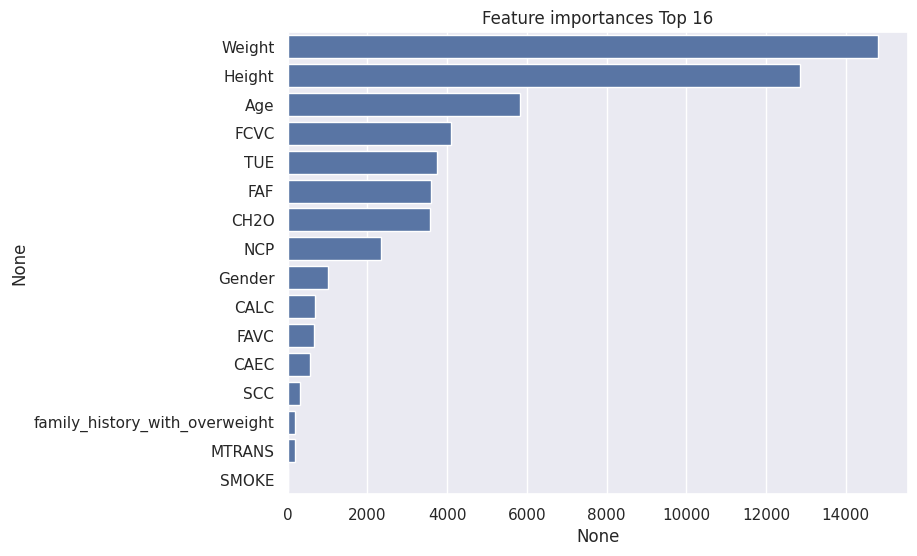

Weight                            14810
Height                            12852
Age                                5839
FCVC                               4103
TUE                                3736
FAF                                3586
CH2O                               3571
NCP                                2344
Gender                             1011
CALC                                677
FAVC                                670
CAEC                                567
SCC                                 300
family_history_with_overweight      194
MTRANS                              174
SMOKE                                 0
dtype: int32

In [ ]:
lgbm_model = lgbm_model_names[2].best_estimator_

ftr_top_lgbm = plot_feature_importance(lgbm_model, X_train.columns)
lgbm_fi_list.append(ftr_top_lgbm) # 특성중요도 리스트에 저장

ftr_top_lgbm

[LightGBM] [Warning] Unknown parameter: min_data_in_lea


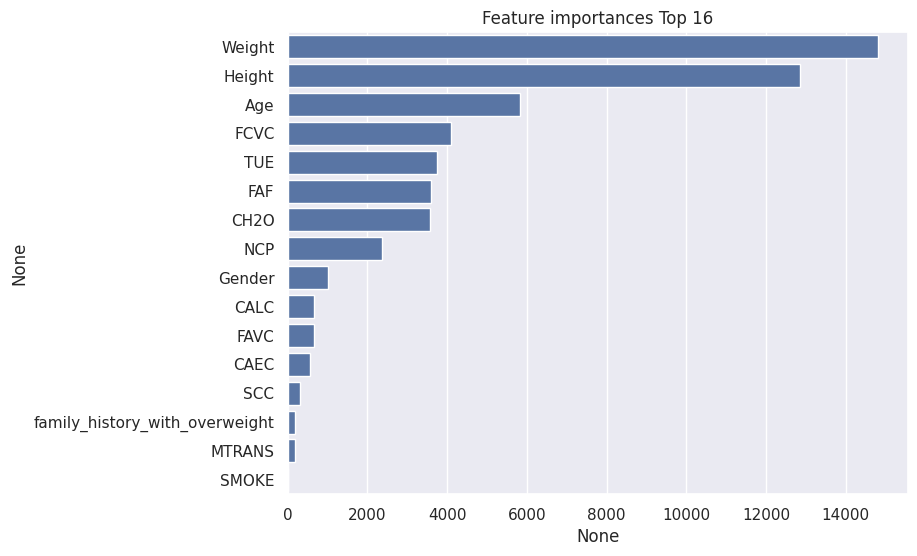

Weight                            14810
Height                            12850
Age                                5837
FCVC                               4103
TUE                                3736
FAF                                3586
CH2O                               3571
NCP                                2356
Gender                             1018
CALC                                674
FAVC                                670
CAEC                                555
SCC                                 300
family_history_with_overweight      194
MTRANS                              174
SMOKE                                 0
dtype: int32

In [ ]:
# 모델의 특성 중요도 확인
lgbm_model = LGBMClassifier(random_state=42, n_estimators=200, learning_rate=0.01, num_leaves=40, max_depth=100, metric='multi_logloss', min_data_in_lea=10, num_class=7, objective='multiclass').fit(X_train, y_train)

ftr_top_lgbm = plot_feature_importance(lgbm_model, X_train.columns)
lgbm_fi_list.append(ftr_top_lgbm) # 특성중요도 리스트에 저장

ftr_top_lgbm

- 몸무게와 키에 대한 특성 중요도가 높게 나왔다. GBM보다 둘을 더 고르게 보고 있다. 또한 SMOKE 이외에 전반적인 피처 데이터를 더 고르게 보고 있다.
- 그 다음으로 나이, 채소 섭취 빈도, 전자 기기 사용 시간, 신체활동 횟수, 물 섭취 횟수, 주식 섭취 횟수
- 그 다음으로 성별, 음주빈도, 고칼로리 자주 섭취 유무, 간식 섭취 빈도, 칼로리 소비 모니터링 여부
- 중요도가 낮게 나온 것은 과체중 가족력, 주요 교통수단, 흡연 유무이다.(GBM과 비슷)

- GBM과 비교했을 때 성별보다 나이를 더 중요하게 보고 전자기기 사용시간, 신체활동 횟수도 높은 중요도로 나온다.
- 채소 섭취 빈도, 물 섭취 횟수, 신체활동 횟수는 동일한 정도의 중요도를 가지는 편이다.
- 음주빈도, 간식 섭취 빈도가 훨씬 낮은 중요도를 가진다.